In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append('/home/fmuinos/projects/oriol/treatment_effects/simulations/scripts')
import gzip
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import json
from itertools import combinations
from sklearn import metrics
from scipy.spatial.distance import cosine
from scipy.optimize import minimize
import tqdm
from plot_signatures import plot_signature
from cotreatment import attribution, attribution_many_at_once

In [3]:
def plotParam():
    """
    plot parameters
    :return:
    """
    plt.rcParams['font.sans-serif'] = ['arial']
    plt.rcParams['font.size'] = 14
    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.cal'] = 'arial'
    plt.rcParams['mathtext.rm'] = 'arial'

plotParam()

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
! ls

 any_two.dirichlet.80.10000.svg
 any_two.svg
 cosinus_similarity_edbs5.svg
 cosinus_similarity_esbs1.svg
 cosinus_similarity_esbs20.svg
 cosinus_similarity.svg
 notebook.ipynb
 regression.py
'rough_['\''1_1'\'', '\''31_SBS17b_0.968799_1'\''].svg'
'rough_['\''13_SBS3_0.870929_1'\'', '\''14_1'\''].svg'
'rough_['\''13_SBS3_0.870929_1'\'', '\''21_SBS31_0.953955_1'\''].svg'
'rough_['\''14_1'\'', '\''21_SBS31_0.953955_1'\''].svg'
'rough_['\''14_1'\'', '\''24_1'\''].svg'
'rough_['\''14_1'\'', '\''37_1'\''].svg'
'rough_['\''14_1'\'', '\''44_1'\''].svg'
'rough_['\''14_1'\'', '\''61_1'\''].svg'
'rough_['\''19_SBS17b_0.932022_1'\'', '\''31_SBS17b_0.968799_1'\''].svg'
'rough_['\''2_1'\'', '\''14_1'\''].svg'
'rough_['\''2_1'\'', '\''21_SBS31_0.953955_1'\''].svg'
'rough_['\''2_1'\'', '\''31_SBS17b_0.968799_1'\''].svg'
'rough_['\''21_SBS31_0.953955_1'\'', '\''24_1'\''].svg'
'rough_['\''21_SBS31_0.953955_1'\'', '\''25_1'\''].svg'
'rough_['\''21_SBS31_0.953955_1'\'', '\''29_SBS22_0.893766_1'\''].svg'
'

In [99]:
signatures_SA = pd.read_csv('../simulations/SignatureAnalyzer_COMPOSITE_SBS_W96.signature.031918.txt', sep='\t')  # with Signature Analyzer
signatures_SP = pd.read_csv('../simulations/sigProfiler_SBS.csv', sep=',')                                        # with SigProfiler

In [100]:
del signatures_SA['feature']

# ChemoMut results

In [7]:
extraction_path = '/workspace/projects/mutfootprints/mutfootprints/data/HMF/20190502/signature_extraction/results'
sp_proc_path = os.path.join(extraction_path, 'SigProfiler/snvs/processes/PanNoSkinNoUnknown.snvs/PanNoSkinNoUnknown.snvs.processes.tsv')
sa_proc_path = os.path.join(extraction_path, 'SignatureAnalyzer/snvs/processes/Pan_full/Pan_full.processes.tsv')
sp_exp_path = os.path.join(extraction_path, 'SigProfiler/snvs/exposures/PanNoSkinNoUnknown.snvs/PanNoSkinNoUnknown.snvs.exposures.tsv')
sa_exp_path = os.path.join(extraction_path, 'SignatureAnalyzer/snvs/exposures/Pan_full/Pan_full.exposures.tsv')
sp_proc_dbs_path = '/workspace/projects/mutfootprints/mutfootprints/data/HMF/20190502/signature_extraction/results/SigProfiler/dbs/processes/PanNoSkinNoUnknown.dbs/PanNoSkinNoUnknown.dbs.processes.tsv'
sa_proc_dbs_path = os.path.join(extraction_path, 'SignatureAnalyzer/dbs/processes/Pan/Pan.processes.tsv')

In [8]:
# load processes

sp_proc = pd.read_csv(sp_proc_path, sep='\t', index_col=0)
sa_proc = pd.read_csv(sa_proc_path, sep='\t', index_col=0)

sp_exp = pd.read_csv(sp_exp_path, sep='\t', index_col=0)
sa_exp = pd.read_csv(sa_exp_path, sep='\t', index_col=0)

sig_dict = {
    'proc': {'sp': sp_proc, 'sa': sa_proc}, 
    'exp': {'sp': sp_exp, 'sa': sa_exp}
}

sp_proc_dbs = pd.read_csv(sp_proc_dbs_path, sep='\t', index_col=0)
sa_proc_dbs = pd.read_csv(sa_proc_dbs_path, sep='\t', index_col=0)


sig_dict_dbs = {'proc': {'sp': sp_proc_dbs, 'sa': sa_proc_dbs}}

In [9]:
# cosine similarity

columns_sa = sig_dict['proc']['sa'].columns
columns_sp = sig_dict['proc']['sp'].columns
columns_sp_dbs = sig_dict_dbs['proc']['sp'].columns
columns_sa_dbs = sig_dict_dbs['proc']['sa'].columns
columns_sa, columns_sp, columns_sa_dbs, columns_sp_dbs

(Index(['1_1', '2_1', '3_SBS12_0.915572_1', '4_1', '5_1', '6_SBS4_0.961549_1',
        '7_1', '8_SBS20_0.930799_1', '9_1', '10_1', '11_SBS33_0.989453_1',
        '12_1', '13_SBS3_0.870929_1', '14_1', '15_1', '16_1',
        '17_SBS1_0.995019_1', '18_1', '19_SBS17b_0.932022_1',
        '20_SBS13_0.948838_1', '21_SBS31_0.953955_1', '22_1',
        '23_SBS39_0.884544_1', '24_1', '25_1', '26_SBS38_0.95532_1', '27_1',
        '28_1', '29_SBS22_0.893766_1', '30_1', '31_SBS17b_0.968799_1', '32_1',
        '33_SBS17a_0.989723_1', '34_1', '35_1', '36_1', '37_1',
        '38_SBS2_0.996907_1', '39_SBS36_0.985735_1', '40_1',
        '41_SBS16_0.856273_1', '42_1', '43_SBS28_0.911686_1', '44_1',
        '45_SBS7c_0.966446_1', '46_SBS2_0.928264_1', '47_SBS21_0.950463_1',
        '48_SBS44_0.864247_1', '49_1', '50_SBS15_0.93882_1', '51_1',
        '52_SBS32_0.939281_1', '53_SBS11_0.988806_1', '54_SBS12_0.859843_1',
        '55_SBS26_0.943655_1', '56_SBS7a_0.996056_1', '57_1',
        '58_SBS44_0.89945

In [285]:
from scipy.spatial.distance import cosine

def cosine_labels(label_sp, label_sa):
    sig_sa = sig_dict['proc']['sa'][label_sa].values
    sig_sp = sig_dict['proc']['sp'][label_sp].values
    return 1 - cosine(sig_sa, sig_sp)

In [286]:
cosine_labels('1_SBS31_0.968153_0.98', '21_SBS31_0.953955_1')

0.9523468830084845

In [290]:
cosine_labels('1_SBS31_0.968153_0.98', '25_1')

0.283313640652474

In [287]:
cosine_labels('1_SBS31_0.968153_0.98', '14_1')

0.3579686142668015

In [288]:
cosine_labels('20_0.92', '14_1')

0.772523147702807

In [289]:
cosine_labels('20_0.92', '37_1')

0.7804778544222678

In [295]:
# dbs
label_sa = '3_1'
label_sp = '5_DBS5_0.944431_1.0'
sig_sa = sig_dict_dbs['proc']['sa'][label_sa].values
sig_sp = sig_dict_dbs['proc']['sp'][label_sp].values
1 - cosine(sig_sa, sig_sp)

0.6749223481382993

In [296]:
# dbs
label_sa = '9_1'
label_sp = '5_DBS5_0.944431_1.0'
sig_sa = sig_dict_dbs['proc']['sa'][label_sa].values
sig_sp = sig_dict_dbs['proc']['sp'][label_sp].values
1 - cosine(sig_sa, sig_sp)

0.7828109253942606

## checking p-value of cosine similarity vs specific signatures

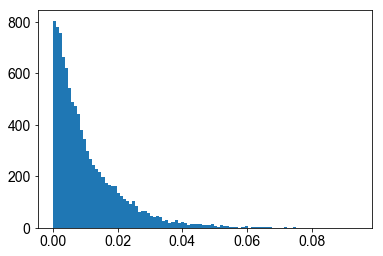

In [19]:
# first dummy checks

N = 96
x = np.random.dirichlet(alpha=[1 for _ in range(N)], size=10000)
y = np.random.dirichlet(alpha=[1 for _ in range(N)], size=10000)
plt.hist(y[:,0], bins=100)
plt.show()

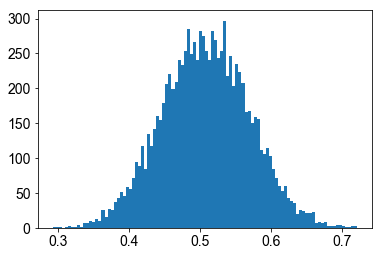

In [22]:
cosines = np.array(list(map(lambda x, y: 1 - cosine(x,y), x, y)))
plt.hist(cosines, bins=100)
plt.show()

In [116]:
# return lables, p-values and mean cosine similarity

def dirichlet_generator(n_draws, n_channels, alpha=1, method='sp'):
    
    signatures = signatures_SA.columns
    labels = []
    means  = []
    pvals  = []
    for c in tqdm.tqdm(signatures):
        sig = signatures_SA[c].values
        s_pool = np.random.dirichlet(alpha=[alpha for _ in range(n_channels)], size=n_draws)
        cosines = list(map(lambda x: 1-cosine(x, sig), s_pool))
        means.append(np.mean(cosines))
        pvals.append(sum((np.array(cosines) >= 0.8)) / n_draws)
        labels.append(c)
    logpvals = list(map(lambda x: -np.log10(x) if x > 0 else -np.log10(1/n_draws), pvals))
    return labels, logpvals, means

In [121]:
method = 'sa'
alpha = 0.001
n = 10000

In [122]:
labels, logpvals, means = dirichlet_generator(n, 96, alpha=alpha, method=method)





  0%|          | 0/60 [00:00<?, ?it/s]



  2%|▏         | 1/60 [00:00<00:30,  1.91it/s]



  3%|▎         | 2/60 [00:01<00:29,  1.94it/s]



  5%|▌         | 3/60 [00:01<00:29,  1.92it/s]



  7%|▋         | 4/60 [00:02<00:28,  1.95it/s]



  8%|▊         | 5/60 [00:02<00:27,  1.99it/s]



 10%|█         | 6/60 [00:03<00:27,  1.98it/s]



 12%|█▏        | 7/60 [00:03<00:27,  1.91it/s]



 13%|█▎        | 8/60 [00:04<00:28,  1.84it/s]



 15%|█▌        | 9/60 [00:04<00:26,  1.91it/s]



 17%|█▋        | 10/60 [00:05<00:25,  1.97it/s]



 18%|█▊        | 11/60 [00:05<00:24,  1.97it/s]



 20%|██        | 12/60 [00:06<00:23,  2.01it/s]



 22%|██▏       | 13/60 [00:06<00:23,  2.04it/s]



 23%|██▎       | 14/60 [00:07<00:22,  2.06it/s]



 25%|██▌       | 15/60 [00:07<00:22,  2.00it/s]



 27%|██▋       | 16/60 [00:08<00:23,  1.88it/s]



 28%|██▊       | 17/60 [00:08<00:23,  1.82it/s]



 30%|███       | 18/60 [00:09<00:24,  1.73it/s]



 32%|███▏      | 19/60 [00:10<00:24,  1.66it/

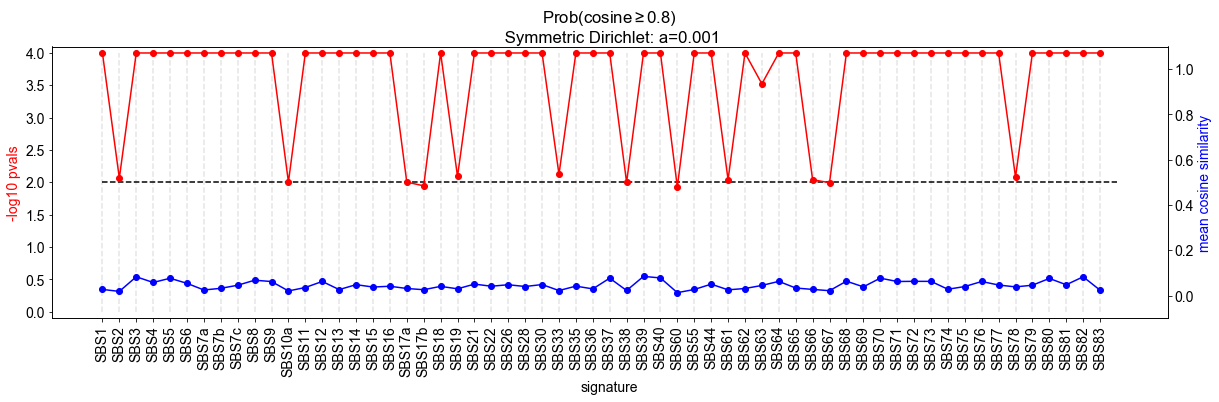

In [124]:
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(20, 5))

ax2 = ax1.twinx()

labels_split = list(map(lambda x: x.split('_')[3], labels))

x = range(len(labels))

ax1.plot(x, logpvals, 'ro-')
ax2.plot(x, means, 'bo-')

ax1.set_xlabel('signature')
ax1.set_xticks(x)
ax1.set_xticklabels(labels_split, rotation=90)
ax1.hlines(2, 0, len(logpvals), linestyles='dashed')

for t in x:
    ax1.vlines(t, 0, 4, linestyles='dashed', alpha=0.1)

ax1.set_ylabel('-log10 pvals', color='r')
ax1.set_ylim(-0.1, 4.1)
ax2.set_ylabel('mean cosine similarity', color='b')
ax2.set_ylim(-0.1, 1.1)
plt.title(f'Prob(cosine$\geq$0.8)\n Symmetric Dirichlet: a={alpha}')
plt.show()

In [125]:
10 ** - logpvals[labels_split.index('SBS17b')]

0.0113

In [45]:
10 ** -logpvals[30]

0.014999999999999996

In [12]:
def dirichlet_vs_dirichlet(n_draws, n_channels, alpha=1):
    
    N = 1000
    d = {}
    cosines = []
    sig_pool_1 = np.random.dirichlet(alpha=[alpha for _ in range(n_channels)], size=n_draws)
    sig_pool_2 = np.random.dirichlet(alpha=[alpha for _ in range(n_channels)], size=n_draws)
    cosines = list(map(lambda x, y: 1-cosine(x, y), sig_pool_1, sig_pool_2))
    return np.array(cosines)

In [240]:
means = []
pvals = []
N = 10000
x = np.linspace(0.1, 3.5, num=100)
for alpha in tqdm.tqdm(x):
    cosines = dirichlet_vs_dirichlet(N, 96, alpha=alpha)
    pvals.append(np.sum(cosines >= 0.8) / N)
    means.append(np.mean(cosines))
logpvals = list(map(lambda x: -np.log10(x) if x > 0 else -np.log10(1/N), pvals))


100%|██████████| 100/100 [00:51<00:00,  1.98it/s]

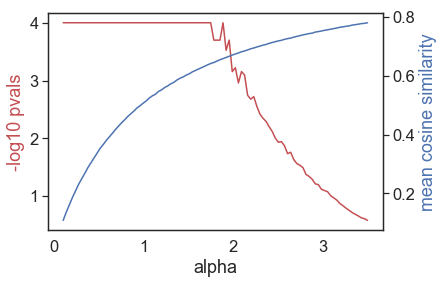

In [241]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, logpvals, 'r-')
ax2.plot(x, means, 'b-')

ax1.set_xlabel('alpha')
ax1.set_ylabel('-log10 pvals', color='r')
ax2.set_ylabel('mean cosine similarity', color='b')

plt.savefig('/home/fmuinos/projects/oriol/treatment_effects/reviews/any_two.svg', dpi=200, bbox_inches='tight')

## alternative urn-model: COSMIC shuffles

In [126]:
# return lables, p-values and mean cosine similarity

def cosmic_shuffles(n_draws, n_channels, method='sp'):
    
    signatures = signatures_SA.columns
    labels = []
    means  = []
    pvals  = []
    for c in tqdm.tqdm(signatures):
        sig = signatures_SA[c].values
        cosines = []
        for _ in range(n_draws):
            c_shuffle = np.random.choice(signatures, size=1)
            sig_shuffle = signatures_SA[c_shuffle].values
            sig_shuffle = sig_shuffle[np.random.permutation(96)]
            cosines.append(1 - cosine(sig, sig_shuffle))
        means.append(np.mean(cosines))
        pvals.append(sum((np.array(cosines) >= 0.8)) / n_draws)
        labels.append(c)
    logpvals = list(map(lambda x: -np.log10(x) if x > 0 else -np.log10(1 / n_draws), pvals))
    return labels, logpvals, means

In [127]:
method = 'sa'
number = 10000
labels, logpvals, means = cosmic_shuffles(number, 96, method=method)





  0%|          | 0/60 [00:00<?, ?it/s]



  2%|▏         | 1/60 [00:10<10:01, 10.20s/it]



  3%|▎         | 2/60 [00:21<10:05, 10.44s/it]



  5%|▌         | 3/60 [00:30<09:40, 10.19s/it]



  7%|▋         | 4/60 [00:40<09:23, 10.07s/it]



  8%|▊         | 5/60 [00:50<09:19, 10.17s/it]



 10%|█         | 6/60 [01:01<09:16, 10.30s/it]



 12%|█▏        | 7/60 [01:11<09:07, 10.32s/it]



 13%|█▎        | 8/60 [01:20<08:34,  9.90s/it]



 15%|█▌        | 9/60 [01:29<08:09,  9.59s/it]



 17%|█▋        | 10/60 [01:38<07:50,  9.41s/it]



 18%|█▊        | 11/60 [01:47<07:31,  9.22s/it]



 20%|██        | 12/60 [01:56<07:17,  9.12s/it]



 22%|██▏       | 13/60 [02:05<07:07,  9.09s/it]



 23%|██▎       | 14/60 [02:14<06:54,  9.01s/it]



 25%|██▌       | 15/60 [02:23<06:42,  8.95s/it]



 27%|██▋       | 16/60 [02:31<06:31,  8.89s/it]



 28%|██▊       | 17/60 [02:40<06:20,  8.84s/it]



 30%|███       | 18/60 [02:49<06:11,  8.84s/it]



 32%|███▏      | 19/60 [02:58<06:01,  8.81s/i

In [128]:
labels

['BI_COMPOSITE_SNV_SBS1_P',
 'BI_COMPOSITE_SNV_SBS2_P',
 'BI_COMPOSITE_SNV_SBS3_P',
 'BI_COMPOSITE_SNV_SBS4_P',
 'BI_COMPOSITE_SNV_SBS5_P',
 'BI_COMPOSITE_SNV_SBS6_S',
 'BI_COMPOSITE_SNV_SBS7a_S',
 'BI_COMPOSITE_SNV_SBS7b_S',
 'BI_COMPOSITE_SNV_SBS7c_S',
 'BI_COMPOSITE_SNV_SBS8_P',
 'BI_COMPOSITE_SNV_SBS9_P',
 'BI_COMPOSITE_SNV_SBS10a_S',
 'BI_COMPOSITE_SNV_SBS11_S',
 'BI_COMPOSITE_SNV_SBS12_P',
 'BI_COMPOSITE_SNV_SBS13_P',
 'BI_COMPOSITE_SNV_SBS14_S',
 'BI_COMPOSITE_SNV_SBS15_S',
 'BI_COMPOSITE_SNV_SBS16_P',
 'BI_COMPOSITE_SNV_SBS17a_P',
 'BI_COMPOSITE_SNV_SBS17b_P',
 'BI_COMPOSITE_SNV_SBS18_P',
 'BI_COMPOSITE_SNV_SBS19_P',
 'BI_COMPOSITE_SNV_SBS21_S',
 'BI_COMPOSITE_SNV_SBS22_P',
 'BI_COMPOSITE_SNV_SBS26_S',
 'BI_COMPOSITE_SNV_SBS28_P',
 'BI_COMPOSITE_SNV_SBS30_P',
 'BI_COMPOSITE_SNV_SBS33_P',
 'BI_COMPOSITE_SNV_SBS35_P',
 'BI_COMPOSITE_SNV_SBS36_P',
 'BI_COMPOSITE_SNV_SBS37_P',
 'BI_COMPOSITE_SNV_SBS38_S',
 'BI_COMPOSITE_SNV_SBS39_P',
 'BI_COMPOSITE_SNV_SBS40_P',
 'BI_COMPOSITE_SNV_

In [17]:
i = labels.index('19_SBS17b_0.961548_0.99')
10 ** (-logpvals[i])

0.0007000000000000001

In [97]:
labels

['BI_COMPOSITE_SNV_SBS1_P',
 'BI_COMPOSITE_SNV_SBS2_P',
 'BI_COMPOSITE_SNV_SBS3_P',
 'BI_COMPOSITE_SNV_SBS4_P',
 'BI_COMPOSITE_SNV_SBS5_P',
 'BI_COMPOSITE_SNV_SBS6_S',
 'BI_COMPOSITE_SNV_SBS7a_S',
 'BI_COMPOSITE_SNV_SBS7b_S',
 'BI_COMPOSITE_SNV_SBS7c_S',
 'BI_COMPOSITE_SNV_SBS8_P',
 'BI_COMPOSITE_SNV_SBS9_P',
 'BI_COMPOSITE_SNV_SBS10a_S',
 'BI_COMPOSITE_SNV_SBS11_S',
 'BI_COMPOSITE_SNV_SBS12_P',
 'BI_COMPOSITE_SNV_SBS13_P',
 'BI_COMPOSITE_SNV_SBS14_S',
 'BI_COMPOSITE_SNV_SBS15_S',
 'BI_COMPOSITE_SNV_SBS16_P',
 'BI_COMPOSITE_SNV_SBS17a_P',
 'BI_COMPOSITE_SNV_SBS17b_P',
 'BI_COMPOSITE_SNV_SBS18_P',
 'BI_COMPOSITE_SNV_SBS19_P',
 'BI_COMPOSITE_SNV_SBS21_S',
 'BI_COMPOSITE_SNV_SBS22_P',
 'BI_COMPOSITE_SNV_SBS26_S',
 'BI_COMPOSITE_SNV_SBS28_P',
 'BI_COMPOSITE_SNV_SBS30_P',
 'BI_COMPOSITE_SNV_SBS33_P',
 'BI_COMPOSITE_SNV_SBS35_P',
 'BI_COMPOSITE_SNV_SBS36_P',
 'BI_COMPOSITE_SNV_SBS37_P',
 'BI_COMPOSITE_SNV_SBS38_S',
 'BI_COMPOSITE_SNV_SBS39_P',
 'BI_COMPOSITE_SNV_SBS40_P',
 'BI_COMPOSITE_SNV_

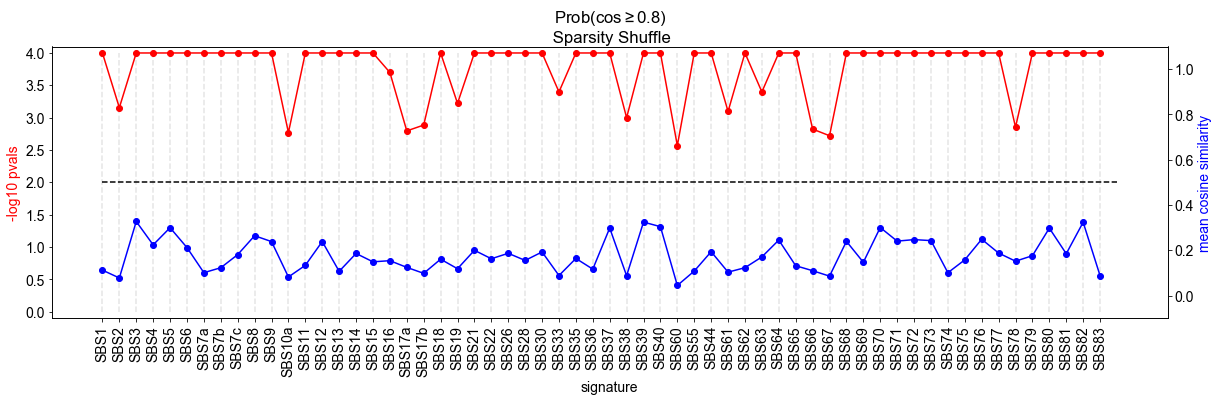

In [131]:
fig, ax1 = plt.subplots(figsize=(20, 5))

ax2 = ax1.twinx()

labels_split = list(map(lambda x: x.split('_')[3], labels))

x = range(len(labels_split))

ax1.plot(x, logpvals, 'ro-')
ax2.plot(x, means, 'bo-')

ax1.set_xlabel('signature')
ax1.set_xticks(x)
ax1.set_xticklabels(labels_split, rotation=90)
ax1.hlines(2, 0, len(logpvals), linestyles='dashed')

for t in x:
    ax1.vlines(t, 0, 4, linestyles='dashed', alpha=0.1)

ax1.set_ylabel('-log10 pvals', color='r')
ax1.set_ylim(-0.1, 4.1)
ax2.set_ylabel('mean cosine similarity', color='b')
ax2.set_ylim(-0.1, 1.1)
plt.title(f'Prob(cos$\geq$0.8)\n Sparsity Shuffle')

plt.savefig(f'/home/fmuinos/projects/oriol/treatment_effects/reviews/shuffle.{method}.80.{number}.svg', 
            dpi=200, bbox_inches='tight')

In [132]:
10 ** -logpvals[labels_split.index('SBS17b')]

0.0013000000000000006

## Optimization "a la Haradhvala"

Given two signatures $C_1$ and $C_2$ and a target signature $S$, we want to assert whether there is a good convex combination $C(a) = a C_1 + (1-a) C_2$ that approximates well $S$.

The following natural constraint must hold: $a \geq 0$ (positivity).

We use the cosine distance $\cos(C(a), S)$ as approximation criterion.

Finally, for any good combination candidate $C(\hat a)$, we must check whether there is some concordance between the per-sample exposures of the combination $C(\hat a)$ versus the target signature $S$.

In [76]:
def cosine_similarity_objective(c1, c2, target):
    
    def objective(w):
        
        comb = x * c1 + (1-x) * c2
        dot_prod = np.dot(comb, target)
        cosine = dot_prod / (np.linalg.norm(comb) * np.linalg.norm(target))
        return 1 - cosine
    
    return objective
    
    
def haradhvala_optimize(c1, c2, target):

    obj_func = cosine_similarity_objective(c1, c2, target)
    bnds = [(0, 1)]
    res = minimize(obj_func, [0.5], method='SLSQP', bounds=bnds)
    cosine_similarity = 1 - obj_func(res.x)
    return (res.x[0], 1-res.x[0]), cosine_similarity

In [78]:
def cosine_objective_many(c, target):
    """c: array-like with shape: n_processes x n_channels"""
    
    def objective(w):
        
        comb = np.dot(w, c)
        dot_prod = np.dot(comb, target)
        cosine = dot_prod / (np.linalg.norm(comb) * np.linalg.norm(target))
        return 1 - cosine
    
    return objective
    

def haradhvala_optimize_many(c, target):

    n_processes, n_channels = c.shape
    obj_func = cosine_objective_many(c, target)
    bnds = [(0, 1) for _ in range(n_processes)]
    cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = minimize(obj_func, 1/n_processes * np.ones(n_processes), method='SLSQP', bounds=bnds, constraints=cons)
    cosine_similarity = 1 - obj_func(res.x)
    return res.x, cosine_similarity

In [79]:
c1 = signatures_SP['SBS1'].values
c2 = signatures_SP['SBS3'].values
c3 = signatures_SP['SBS5'].values
target = 0.5 * c1 + 0.3 * c2 + 0.2 * c3
c = np.array([c1, c2, c3])
weights, cosine = haradhvala_optimize_many(c, target)
weights, cosine

(array([0.50007324, 0.30031638, 0.19961037]), 0.9999999917040253)

In [80]:
def closest_target(c, method='sp'):
    """c: array-like with shape: n_processes x n_channels
       returns the highest cosine of a combination of c against 
       any deconstructed signature following from method"""
    
    signatures = sig_dict[method].columns
    cosine = 0
    weights = None
    target = None
    for sig_label in signatures:
        s = sig_dict[method][sig_label].values
        x, cos = haradhvala_optimize_many(c, s)
        if cos > cosine:
            weights = x
            cosine  = cos
            target  = sig_label
    return weights, cosine, target


def closest_combination(s, n_processes, method='sa'):
    """size: int: number of processes allowed to find the best approximation to s"""
    
    pool = np.array(list(sig_dict['proc'][method].columns))
    cosine = 0
    c = np.empty((n_processes, len(s)))
    all_results = []
    for indices in tqdm.tqdm(combinations(range(len(pool)), n_processes)):
        indices = list(indices)
        w, cos = haradhvala_optimize_many(sig_dict['proc'][method].iloc[:, indices].values.T, s)
        cos = np.round(cos, 3)
        w = tuple(map(lambda x: np.round(x, 3), w))
        all_results.append((list(pool[indices]), w, cos))
        if cos > cosine:
            cosine = cos
            c = np.array(pool[indices])
            weights = w
            print(cosine, list(c), weights)
    all_results = sorted(all_results, key=lambda x: x[2], reverse=True)
    return list(c), weights, cosine, all_results

## catalogue of signatures extracted by SP

In [81]:
sig_dict['proc']['sa'].columns

Index(['1_1', '2_1', '3_SBS12_0.915572_1', '4_1', '5_1', '6_SBS4_0.961549_1',
       '7_1', '8_SBS20_0.930799_1', '9_1', '10_1', '11_SBS33_0.989453_1',
       '12_1', '13_SBS3_0.870929_1', '14_1', '15_1', '16_1',
       '17_SBS1_0.995019_1', '18_1', '19_SBS17b_0.932022_1',
       '20_SBS13_0.948838_1', '21_SBS31_0.953955_1', '22_1',
       '23_SBS39_0.884544_1', '24_1', '25_1', '26_SBS38_0.95532_1', '27_1',
       '28_1', '29_SBS22_0.893766_1', '30_1', '31_SBS17b_0.968799_1', '32_1',
       '33_SBS17a_0.989723_1', '34_1', '35_1', '36_1', '37_1',
       '38_SBS2_0.996907_1', '39_SBS36_0.985735_1', '40_1',
       '41_SBS16_0.856273_1', '42_1', '43_SBS28_0.911686_1', '44_1',
       '45_SBS7c_0.966446_1', '46_SBS2_0.928264_1', '47_SBS21_0.950463_1',
       '48_SBS44_0.864247_1', '49_1', '50_SBS15_0.93882_1', '51_1',
       '52_SBS32_0.939281_1', '53_SBS11_0.988806_1', '54_SBS12_0.859843_1',
       '55_SBS26_0.943655_1', '56_SBS7a_0.996056_1', '57_1',
       '58_SBS44_0.899453_1', '59_1', '

In [82]:
def key_func(r):
    return (r[2]+r[4], r[0]+r[-1])

for k, v in sig_dict['proc'].items():
    sig_dict['proc'][k].index = v.index.map(key_func)

In [83]:
sig_dict['proc']['sa'].head()

1_1       2_1  3_SBS12_0.915572_1       4_1       5_1  \
CA AA  0.003916  0.000956            0.000980  0.013249  0.005760   
   AC  0.002219  0.299153            0.001154  0.009886  0.004538   
   AG  0.001295  0.000396            0.000089  0.000724  0.000500   
   AT  0.000726  0.071025            0.004942  0.001658  0.005662   
CG AA  0.007652  0.000080            0.002297  0.005312  0.004337   

       6_SBS4_0.961549_1       7_1  8_SBS20_0.930799_1       9_1      10_1  \
CA AA           0.061912  0.001540            0.000925  0.004524  0.018942   
   AC           0.027182  0.000745            0.007159  0.001736  0.006963   
   AG           0.015121  0.000072            0.000048  0.000774  0.002537   
   AT           0.038854  0.000698            0.002378  0.001751  0.010355   
CG AA           0.013205  0.000661            0.000258  0.002629  0.006900   

       ...      64_1  65_SBS44_0.903138_1  66_SBS7b_0.984914_1      67_1  \
CA AA  ...  0.000252             0.000795             0.004900  0.002320   
   AC  ...  0.000204             0.000910             0.000264  0.001879   
   AG  ...  0.000063             0.000044             0.000059  0.000155   
   AT  ...  0.000105             0.002027             0.002013  0.002328   
CG AA  ...  0.000012             0.003144             0.000356  0.003992   

           68_1      69_1      70_1  71_SBS44_0.865933_1  72_SBS55_0.987381_1  \
CA AA  0.000869  0.005480  0.004848             0.001027             0.006490   
   AC  0.000950  0.002806  0.001031             0.007718             0.001817   
   AG  0.000065  0.000416  0.000448             0.000432             0.000540   
   AT  0.001405  0.001984  0.005139             0.012226             0.000949   
CG AA  0.001396  0.001189  0.001395             0.007533             0.000725   

           73_1  
CA AA  0.000916  
   AC  0.002840  
   AG  0.000154  
   AT  0.005758  
CG AA  0.000630  

[5 rows x 73 columns]

In [84]:
res_siganalyzer_dict = {sig: dict(zip(list(sig_dict['proc']['sa'][sig].index), list(sig_dict['proc']['sa'][sig].values))) for sig in sig_dict['proc']['sa'].columns}

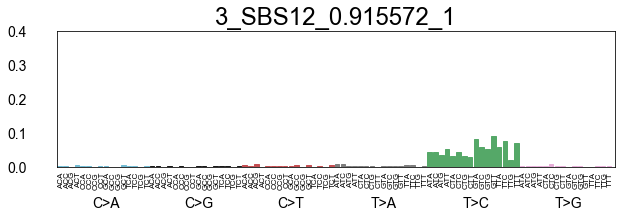

In [85]:
# test... how to plot signatures

fig, ax = plt.subplots(figsize=(10, 2.5))
col = '3_SBS12_0.915572_1'
plot_signature(res_siganalyzer_dict[col], title=col, ymax=0.4, ax=ax)
plt.show()

# Correspondance between sets of signatures

In [263]:
# exposure plots

def rough_concordance(c, target_label, weights):

    columns_sa = set(sig_dict['exp']['sa'].columns)
    columns_sp = set(sig_dict['exp']['sp'].columns)
    samples = columns_sa.intersection(columns_sp)

    sa_exposure = sig_dict['exp']['sa'][samples]
    sp_exposure = sig_dict['exp']['sp'][samples]

    y = sp_exposure.loc[target_label].values
    index1 = [i for i, a in enumerate(y) if a > 0]

    c_vector = sa_exposure.loc[list(c),:].values
    x = np.dot(np.ones(c_vector.shape[0]), c_vector)
    
    index2 = [i for i, a in enumerate(x) if a > 0]
    index = list(set(index1).intersection(set(index2)))

    plt.scatter(np.log10(x+1), np.log10(y+1), color='black', s=1)
    
    plt.plot(np.linspace(0, 5, 100), np.linspace(0, 5, 100), 'r--')
    
    plt.xlim(-0.1, 5)
    plt.ylim(-0.1, 5)
    plt.xlabel('combination: SignatureAnalyzer')
    plt.ylabel('SigProfiler')
    plt.title(f'{"+".join(list(map(lambda x: x.split("_")[0], c)))} ~ {target_label.split("_")[0]}')
    
    plt.savefig(f'rough_{str(c)}.svg', dpi=200, bbox_anchor='tight')
    plt.show()

In [34]:
# dictionary between signature analyzer and sigprofiler
# the computation is based on looking at the number of mutations per sample in sigprofiler in two different ways
# 1) straighforward computation with SP matrix
# 2) using a SA-to-SP transformation

columns_sa = set(sig_dict['exp']['sa'].columns)
columns_sp = set(sig_dict['exp']['sp'].columns)
samples = columns_sa.intersection(columns_sp)

# mutations per sample according to SP
Sa = sig_dict['exp']['sa'][samples].values.T
Sp = sig_dict['exp']['sp'][samples].values.T

index_dict_sa = {v: i for i, v in enumerate(sig_dict['exp']['sa'].index)}
index_dict_sp = {v: i for i, v in enumerate(sig_dict['exp']['sp'].index)}

In [35]:
Sa.shape, Sp.shape

((3145, 73), (3145, 25))

In [37]:
def single_lsq(A, b):
    
    lb = np.zeros(A.shape[1])  # lower bound
    ub = lb + 1    
    res = scipy.optimize.lsq_linear(A, b, bounds=(lb, ub))
    return res.x / np.sum(res.x)

In [175]:
def deconstruct_splits(sp_signature, columns=None):
    if columns is None:
        indexes = list(range(Sa.shape[1]))
    else:
        indexes = [index_dict_sa[c] for c in columns]
    j = index_dict_sp[sp_signature]
    x = single_lsq(Sa[:, indexes], Sp[:, j])
    return x

In [176]:
deconstruct_splits('1_SBS31_0.968153_0.98', columns=['14_1', '21_SBS31_0.953955_1'])

array([0.42415575, 0.57584425])

In [184]:
deconstruct_splits('20_0.92', columns=['14_1', '37_1'])

array([0.5, 0.5])

In [67]:
def get_splits_sp(signature_label):
    j = index_dict_sp[signature_label]
    return U[:, j]

In [68]:
index_dict_sp.keys()

dict_keys(['1_SBS31_0.968153_0.98', '2_SBS44_2_2_toremove_0.63_', '3_0.96', '4_SBS11_0.985989_0.97', '5_0.92', '6_SBS17b_0.879886_0.93', '7_SBS36_0.979943_0.84', '8_SBS2_0.999321_1.0', '9_0.97', '10_0.94', '11_SBS32_11_11_toremove_0.59_', '12_SBS13_0.988529_0.95', '13_SBS7a_0.9327_1.0', '14_SBS21_0.935793_1.0', '15_0.99', '16_0.92', '17_SBS4_0.935484_0.97', '18_SBS15_0.917425_0.87', '19_SBS17b_0.961548_0.99', '20_0.92', '21_SBS29_21_21_toremove_0.27_', '22_SBS14_22_22_toremove_0.77_', '23_SBS1_0.996494_1.0', '24_0.96', '25_SBS13_25_25_toremove_-0.5_'])

In [69]:
index_dict_sa.items()

dict_items([('1_1', 0), ('2_1', 1), ('3_SBS12_0.915572_1', 2), ('4_1', 3), ('5_1', 4), ('6_SBS4_0.961549_1', 5), ('7_1', 6), ('8_SBS20_0.930799_1', 7), ('9_1', 8), ('10_1', 9), ('11_SBS33_0.989453_1', 10), ('12_1', 11), ('13_SBS3_0.870929_1', 12), ('14_1', 13), ('15_1', 14), ('16_1', 15), ('17_SBS1_0.995019_1', 16), ('18_1', 17), ('19_SBS17b_0.932022_1', 18), ('20_SBS13_0.948838_1', 19), ('21_SBS31_0.953955_1', 20), ('22_1', 21), ('23_SBS39_0.884544_1', 22), ('24_1', 23), ('25_1', 24), ('26_SBS38_0.95532_1', 25), ('27_1', 26), ('28_1', 27), ('29_SBS22_0.893766_1', 28), ('30_1', 29), ('31_SBS17b_0.968799_1', 30), ('32_1', 31), ('33_SBS17a_0.989723_1', 32), ('34_1', 33), ('35_1', 34), ('36_1', 35), ('37_1', 36), ('38_SBS2_0.996907_1', 37), ('39_SBS36_0.985735_1', 38), ('40_1', 39), ('41_SBS16_0.856273_1', 40), ('42_1', 41), ('43_SBS28_0.911686_1', 42), ('44_1', 43), ('45_SBS7c_0.966446_1', 44), ('46_SBS2_0.928264_1', 45), ('47_SBS21_0.950463_1', 46), ('48_SBS44_0.864247_1', 47), ('49_1',

In [70]:
def components(sp_signature):
    
    x = get_splits_sp(sp_signature)
    l = np.where(x > 0)[0]
    components = [(v, x[i]) for v, i in index_dict_sa.items() if i in l]
    return components

In [71]:
components('1_SBS31_0.968153_0.98')

[('14_1', 0.10727421161031411),
 ('21_SBS31_0.953955_1', 0.17399042761753242),
 ('27_1', 0.13457072136043524),
 ('45_SBS7c_0.966446_1', 0.1565913848557792),
 ('46_SBS2_0.928264_1', 0.1565913848557792)]

In [72]:
components('20_0.92')

[('2_1', 0.10051122200237067),
 ('14_1', 0.10051122200237067),
 ('29_SBS22_0.893766_1', 0.10051122200237067)]

In [73]:
components('19_SBS17b_0.961548_0.99')

[('27_1', 0.12294373953369937),
 ('31_SBS17b_0.968799_1', 0.24172528458577489),
 ('45_SBS7c_0.966446_1', 0.16450501275664015),
 ('57_1', 0.12262775509217558)]

## what is the combination of two signatures from SA that best explains SP-E-SBS1?

In [274]:
target_label = '19_SBS17b_0.961548_0.99'
sig = sig_dict['proc']['sp'][target_label].values
c, weights, cosine, all_results = closest_combination(sig, 2, method='sa')

86it [00:00, 366.65it/s]

0.017 ['1_1', '2_1'] (0.682, 0.318)
0.071 ['1_1', '3_SBS12_0.915572_1'] (0.09, 0.91)
0.084 ['1_1', '7_1'] (0.148, 0.852)
0.127 ['1_1', '10_1'] (0.0, 1.0)
0.131 ['1_1', '13_SBS3_0.870929_1'] (0.0, 1.0)
0.908 ['1_1', '19_SBS17b_0.932022_1'] (0.0, 1.0)
0.996 ['1_1', '31_SBS17b_0.968799_1'] (0.0, 1.0)


1223it [00:02, 471.24it/s]

0.997 ['19_SBS17b_0.932022_1', '31_SBS17b_0.968799_1'] (0.13, 0.87)


1783it [00:04, 500.19it/s]

0.999 ['31_SBS17b_0.968799_1', '33_SBS17a_0.989723_1'] (0.9, 0.1)


2628it [00:05, 452.87it/s]


In [266]:
all_results[:10]

[(['14_1', '21_SBS31_0.953955_1'], (0.295, 0.705), 0.978),
 (['21_SBS31_0.953955_1', '25_1'], (0.732, 0.268), 0.974),
 (['21_SBS31_0.953955_1', '37_1'], (0.694, 0.306), 0.971),
 (['8_SBS20_0.930799_1', '21_SBS31_0.953955_1'], (0.134, 0.866), 0.967),
 (['6_SBS4_0.961549_1', '21_SBS31_0.953955_1'], (0.328, 0.672), 0.966),
 (['2_1', '21_SBS31_0.953955_1'], (0.165, 0.835), 0.964),
 (['21_SBS31_0.953955_1', '24_1'], (0.668, 0.332), 0.962),
 (['21_SBS31_0.953955_1', '29_SBS22_0.893766_1'], (0.749, 0.251), 0.962),
 (['13_SBS3_0.870929_1', '21_SBS31_0.953955_1'], (0.322, 0.678), 0.96),
 (['21_SBS31_0.953955_1', '61_1'], (0.733, 0.267), 0.959)]

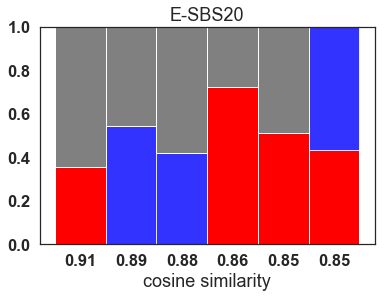

In [262]:
# stacked barplot

# libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
 
# y-axis in bold
rc('font', weight='bold')

# groups: ESBS14, ESBS37, other 

# Values of each group
s14 = [0.355, 0, 0, 0.724, 0.51, 0.433]
s37 = [0, 0.546, 0.419, 0, 0, 0.567]
other = [0.645, 0.454, 0.581, 0.276, 0.49, 0]

# Heights of bars1 + bars2
bars1 = np.add(s14, s37).tolist()
 
# The position of the bars on the x-axis
r = [0,1,2,3,4, 5]
 
# Names of group and bar width
names = ['0.91','0.89','0.88','0.86','0.85', '0.85']
barWidth = 1

# Create brown bars
plt.bar(r, s14, color='red', edgecolor='white', width=barWidth)
# Create green bars (middle), on top of the firs ones
plt.bar(r, s37, bottom=s14, color='blue', alpha=0.8, edgecolor='white', width=barWidth)
# Create green bars (top)
plt.bar(r, other, bottom=bars1, color='grey', edgecolor='white', width=barWidth)
 
# Custom X axis
plt.xticks(r, names, fontweight='bold')
plt.xlabel("cosine similarity")

plt.title('E-SBS20')

plt.savefig('/home/fmuinos/projects/oriol/treatment_effects/reviews/cosinus_similarity_esbs20.svg', bbox_inches='tight', dpi=200)

In [ ]:
# stacked barplot

# libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
 
# y-axis in bold
rc('font', weight='bold')

# groups: ESBS14, ESBS21, ESBS37, other 

# Values of each group
s14 = [0.295, 0, 0, 0, 0]
s21 = [0.705, 0.732, 0.694, 0.866, 0.672]
s37 = [0, 0, 0.306, 0, 0]
other = [0, 0.268, 0, 0.134, 0.328]

# Heights of bars1 + bars2
bars1 = np.add(s14, s21).tolist()
bars2 = np.add(bars, s37).tolist()
 
# The position of the bars on the x-axis
r = [0,1,2,3,4]
 
# Names of group and bar width
names = ['0.97','0.97','0.97','0.96','0.96']
barWidth = 1

# Create brown bars
plt.bar(r, s14, color='red', edgecolor='white', width=barWidth)
# Create green bars (middle), on top of the firs ones
plt.bar(r, s21, bottom=s14, color='blue', alpha=0.8, edgecolor='white', width=barWidth)
# Create green bars (top)
plt.bar(r, s37, bottom=bars1, color='green', edgecolor='white', width=barWidth)
# Create green bars (top)
plt.bar(r, other, bottom=bars2, color='grey', edgecolor='white', width=barWidth)
 
# Custom X axis
plt.xticks(r, names, fontweight='bold')
plt.xlabel("cosine similarity")

plt.title('E-SBS1')

plt.savefig('/home/fmuinos/projects/oriol/treatment_effects/reviews/cosinus_similarity_esbs1.svg', bbox_inches='tight', dpi=200)

## what are the proportions of exposures across samples

In [230]:
import seaborn as sns

def pair_plot_exposures(sig1, sig2, sig_sp):
    
    s1 = sig_dict['exp']['sa'].loc[sig1,:]
    s2 = sig_dict['exp']['sa'].loc[sig2,:]
    s3 = sig_dict['exp']['sp'].loc[sig_sp,:]
    mask1 = s1 > 1
    mask2 = s2 > 1
    mask = mask1 & mask2
    l = s1[mask] / (s1[mask] + s2[mask])
    m = np.median(l)
    # plt.hist(l, bins=100, density=True)
    # plt.vlines(m, 0, 1, linestyles='dashed')
    g = sns.regplot(s1[mask] + s2[mask], s3[mask], robust=True)
    return g

In [231]:
g = pair_plot_exposures('14_1', '21_SBS31_0.953955_1', '1_SBS31_0.968153_0.98')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=g.get_lines()[0].get_xdata(), y=g.get_lines()[0].get_ydata())
print(slope)

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match

In [80]:
# best combination
c, weights, cosine

(['14_1', '21_SBS31_0.953955_1'], (0.295, 0.705), 0.978)

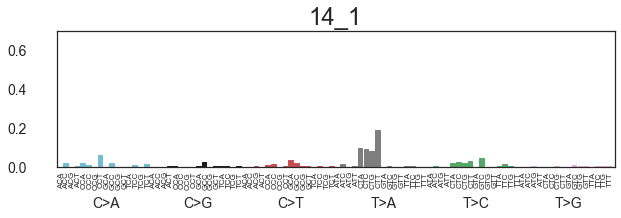

In [82]:
fig, ax = plt.subplots(figsize=(10, 2.5))
col = '14_1'
plot_signature(res_siganalyzer_dict[col], title=col, ymax=0.7, ax=ax)
plt.show()

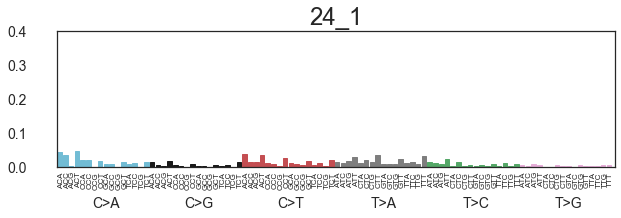

In [97]:
fig, ax = plt.subplots(figsize=(10, 2.5))
col = '24_1'
plot_signature(res_siganalyzer_dict[col], title=col, ymax=0.4, ax=ax)
plt.show()

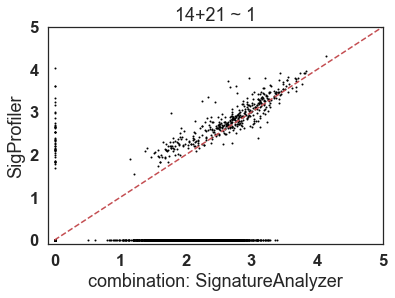

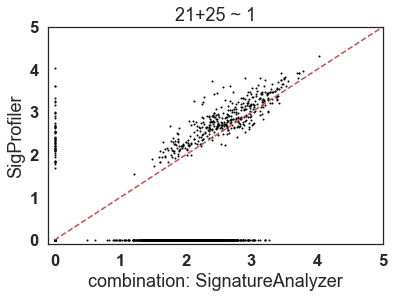

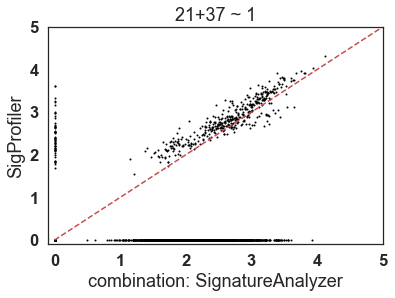

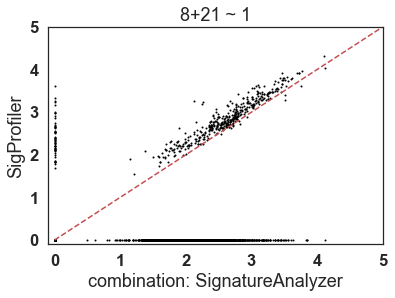

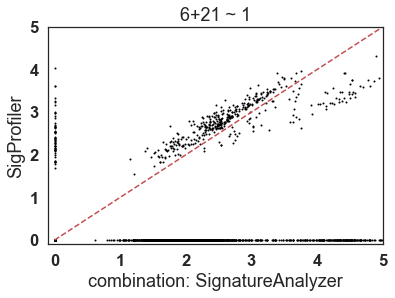

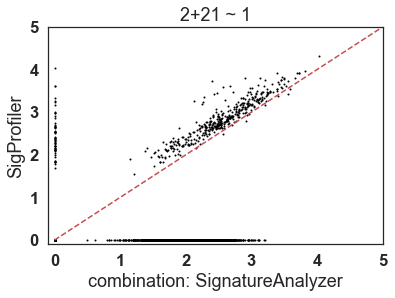

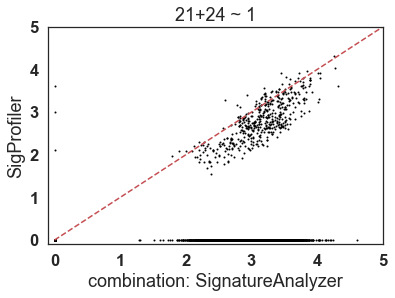

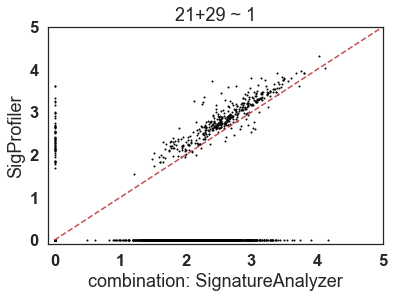

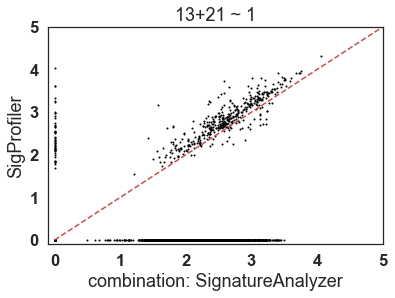

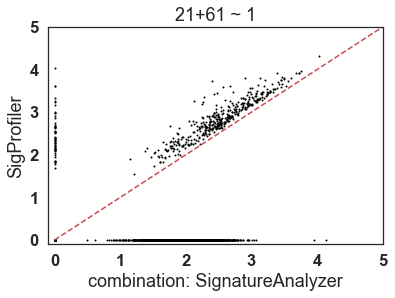

In [267]:
for c, weights, cos in all_results[:10]:
    rough_concordance(c, target_label, weights)

## what is the combination of two signatures from SA that best explains SP-E-SBS14?

In [98]:
sig = sig_dict['proc']['sp']['20_0.92'].values
c, weights, cosine, all_results = closest_combination(sig, 3, method='sa')


0it [00:00, ?it/s]
23it [00:00, 228.84it/s]
48it [00:00, 234.22it/s]

0.521 ['1_1', '2_1', '3_SBS12_0.915572_1'] (0.17, 0.526, 0.304)
0.548 ['1_1', '2_1', '4_1'] (0.056, 0.428, 0.516)
0.64 ['1_1', '2_1', '6_SBS4_0.961549_1'] (0.023, 0.224, 0.753)
0.668 ['1_1', '2_1', '13_SBS3_0.870929_1'] (0.0, 0.216, 0.784)
0.86 ['1_1', '2_1', '14_1'] (0.075, 0.255, 0.669)



83it [00:00, 259.98it/s]
117it [00:00, 279.01it/s]
158it [00:00, 308.34it/s]
204it [00:00, 341.43it/s]
244it [00:00, 356.97it/s]
284it [00:00, 367.50it/s]
335it [00:00, 399.82it/s]
380it [00:01, 411.94it/s]
422it [00:01, 409.08it/s]
466it [00:01, 414.31it/s]
508it [00:01, 410.80it/s]
550it [00:01, 364.91it/s]
593it [00:01, 381.36it/s]
640it [00:01, 403.22it/s]
682it [00:01, 398.46it/s]
725it [00:01, 406.30it/s]
774it [00:01, 426.37it/s]
818it [00:02, 426.98it/s]
862it [00:02, 429.55it/s]

0.906 ['1_1', '14_1', '24_1'] (0.0, 0.355, 0.645)



906it [00:02, 431.87it/s]
952it [00:02, 439.91it/s]
997it [00:02, 437.89it/s]
1041it [00:02, 423.52it/s]
1084it [00:02, 379.14it/s]
1130it [00:02, 398.30it/s]
1172it [00:02, 402.76it/s]
1214it [00:03, 407.68it/s]
1256it [00:03, 410.50it/s]
1298it [00:03, 402.04it/s]
1342it [00:03, 410.10it/s]
1398it [00:03, 444.30it/s]
1444it [00:03, 444.59it/s]
1490it [00:03, 443.32it/s]
1535it [00:03, 418.53it/s]
1578it [00:03, 387.09it/s]
1623it [00:04, 403.65it/s]
1665it [00:04, 408.08it/s]
1707it [00:04, 408.88it/s]
1754it [00:04, 425.38it/s]
1801it [00:04, 436.91it/s]
1846it [00:04, 411.00it/s]
1893it [00:04, 425.07it/s]
1941it [00:04, 438.90it/s]
1986it [00:04, 437.42it/s]
2031it [00:04, 405.16it/s]
2073it [00:05, 408.78it/s]
2115it [00:05, 410.56it/s]
2161it [00:05, 422.97it/s]
2204it [00:05, 419.85it/s]
2249it [00:05, 426.97it/s]
2292it [00:05, 421.29it/s]
2337it [00:05, 426.88it/s]
2380it [00:05, 420.28it/s]
2423it [00:05, 421.42it/s]
2466it [00:06, 411.68it/s]
2509it [00:06, 415.14it/s]
255

0.929 ['2_1', '14_1', '24_1'] (0.108, 0.36, 0.532)



3381it [00:08, 411.12it/s]
3426it [00:08, 419.90it/s]
3470it [00:08, 424.43it/s]
3515it [00:08, 428.99it/s]
3560it [00:08, 434.55it/s]
3604it [00:08, 428.71it/s]
3648it [00:08, 431.47it/s]
3693it [00:08, 434.11it/s]
3737it [00:09, 433.37it/s]
3782it [00:09, 435.42it/s]
3826it [00:09, 419.30it/s]
3870it [00:09, 424.07it/s]
3920it [00:09, 442.74it/s]
3965it [00:09, 438.88it/s]
4010it [00:09, 436.11it/s]
4056it [00:09, 441.12it/s]
4102it [00:09, 445.77it/s]
4150it [00:09, 452.70it/s]
4196it [00:10, 441.39it/s]
4241it [00:10, 415.25it/s]
4288it [00:10, 428.13it/s]
4332it [00:10, 425.04it/s]
4375it [00:10, 421.72it/s]
4421it [00:10, 431.61it/s]
4465it [00:10, 386.31it/s]
4505it [00:10, 360.92it/s]
4548it [00:10, 378.10it/s]
4587it [00:11, 360.70it/s]
4624it [00:11, 349.64it/s]
4669it [00:11, 373.91it/s]
4713it [00:11, 389.45it/s]
4756it [00:11, 399.94it/s]
4799it [00:11, 408.06it/s]
4843it [00:11, 415.09it/s]
4886it [00:11, 417.55it/s]
4929it [00:11, 413.42it/s]
4971it [00:12, 415.33it/s]


27159it [01:04, 458.01it/s]
27205it [01:05, 450.23it/s]
27251it [01:05, 450.63it/s]
27300it [01:05, 460.66it/s]
27348it [01:05, 464.86it/s]
27397it [01:05, 470.22it/s]
27445it [01:05, 466.32it/s]
27495it [01:05, 475.42it/s]
27546it [01:05, 484.47it/s]
27595it [01:05, 474.74it/s]
27647it [01:05, 487.17it/s]
27696it [01:06, 474.92it/s]
27744it [01:06, 470.66it/s]
27795it [01:06, 481.23it/s]
27844it [01:06, 477.63it/s]
27892it [01:06, 438.25it/s]
27937it [01:06, 437.37it/s]
27983it [01:06, 442.98it/s]
28028it [01:06, 437.89it/s]
28073it [01:06, 436.88it/s]
28117it [01:07, 437.80it/s]
28162it [01:07, 440.71it/s]
28211it [01:07, 453.17it/s]
28259it [01:07, 458.64it/s]
28306it [01:07, 461.61it/s]
28353it [01:07, 457.28it/s]
28402it [01:07, 464.75it/s]
28449it [01:07, 451.10it/s]
28495it [01:07, 438.32it/s]
28540it [01:07, 441.02it/s]
28586it [01:08, 446.47it/s]
28632it [01:08, 448.41it/s]
28681it [01:08, 458.57it/s]
28727it [01:08, 455.32it/s]
28773it [01:08, 448.85it/s]
28822it [01:08, 459.

51425it [02:00, 429.61it/s]
51471it [02:00, 437.33it/s]
51516it [02:01, 440.63it/s]
51561it [02:01, 435.72it/s]
51605it [02:01, 403.47it/s]
51650it [02:01, 415.28it/s]
51693it [02:01, 388.71it/s]
51740it [02:01, 408.51it/s]
51790it [02:01, 429.79it/s]
51835it [02:01, 432.81it/s]
51879it [02:01, 434.01it/s]
51926it [02:01, 442.60it/s]
51972it [02:02, 445.85it/s]
52017it [02:02, 442.99it/s]
52062it [02:02, 438.08it/s]
52110it [02:02, 448.03it/s]
52155it [02:02, 440.42it/s]
52200it [02:02, 435.64it/s]
52244it [02:02, 430.21it/s]
52288it [02:02, 383.02it/s]
52334it [02:02, 401.17it/s]
52380it [02:03, 417.17it/s]
52423it [02:03, 389.85it/s]
52463it [02:03, 343.15it/s]
52499it [02:03, 333.93it/s]
52536it [02:03, 343.89it/s]
52581it [02:03, 370.02it/s]
52626it [02:03, 389.72it/s]
52673it [02:03, 408.87it/s]
52719it [02:03, 421.03it/s]
52765it [02:04, 431.52it/s]
52811it [02:04, 436.90it/s]
52856it [02:04, 440.39it/s]
52901it [02:04, 434.65it/s]
52945it [02:04, 371.57it/s]
52990it [02:04, 390.

In [99]:
all_results[:20]

[(['2_1', '14_1', '24_1'], (0.108, 0.36, 0.532), 0.929),
 (['14_1', '24_1', '37_1'], (0.252, 0.523, 0.224), 0.927),
 (['24_1', '29_SBS22_0.893766_1', '37_1'], (0.378, 0.276, 0.346), 0.925),
 (['2_1', '29_SBS22_0.893766_1', '37_1'], (0.12, 0.443, 0.437), 0.914),
 (['14_1', '24_1', '25_1'], (0.319, 0.611, 0.07), 0.912),
 (['14_1', '24_1', '29_SBS22_0.893766_1'], (0.297, 0.576, 0.127), 0.912),
 (['14_1', '24_1', '30_1'], (0.364, 0.584, 0.052), 0.911),
 (['14_1', '24_1', '33_SBS17a_0.989723_1'], (0.333, 0.63, 0.037), 0.91),
 (['6_SBS4_0.961549_1', '14_1', '24_1'], (0.092, 0.349, 0.559), 0.908),
 (['14_1', '24_1', '39_SBS36_0.985735_1'], (0.353, 0.617, 0.03), 0.908),
 (['14_1', '24_1', '44_1'], (0.353, 0.564, 0.083), 0.908),
 (['14_1', '24_1', '45_SBS7c_0.966446_1'], (0.353, 0.618, 0.029), 0.908),
 (['13_SBS3_0.870929_1', '14_1', '24_1'], (0.062, 0.346, 0.592), 0.907),
 (['14_1', '23_SBS39_0.884544_1', '24_1'], (0.342, 0.07, 0.588), 0.907),
 (['14_1', '24_1', '28_1'], (0.346, 0.622, 0.032),

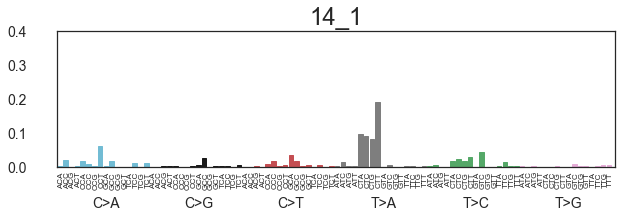

In [64]:
fig, ax = plt.subplots(figsize=(10, 2.5))
col = '14_1'
plot_signature(res_siganalyzer_dict[col], title=col, ymax=0.4, ax=ax)
plt.show()

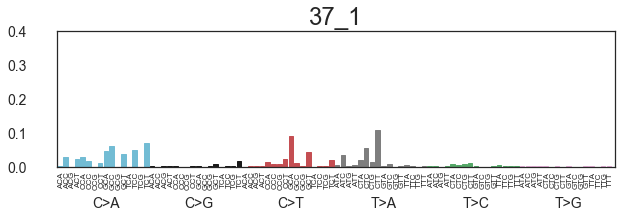

In [76]:
fig, ax = plt.subplots(figsize=(10, 2.5))
col = '37_1'
plot_signature(res_siganalyzer_dict[col], title=col, ymax=0.4, ax=ax)
plt.show()

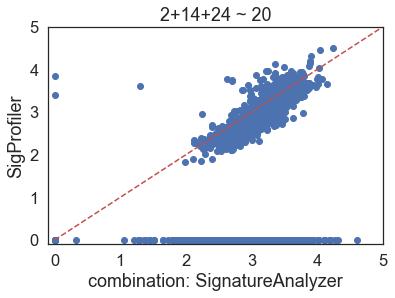

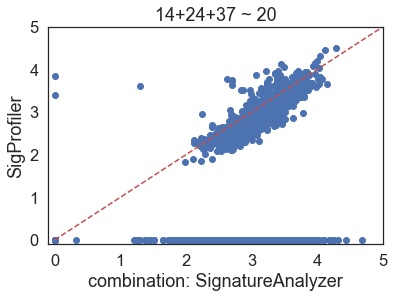

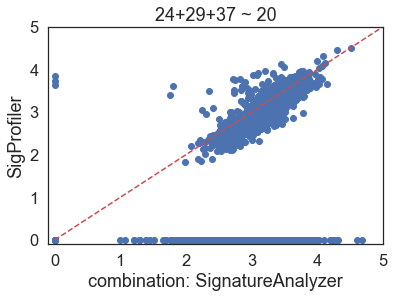

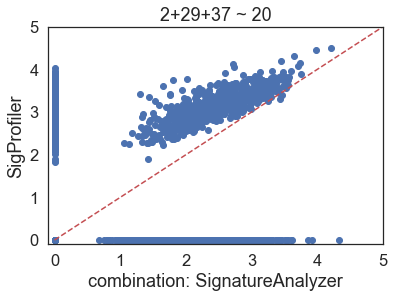

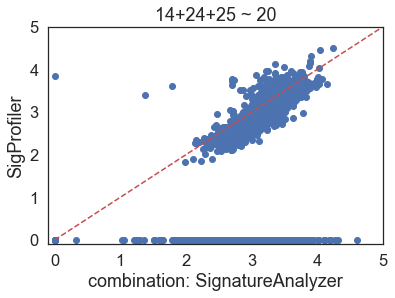

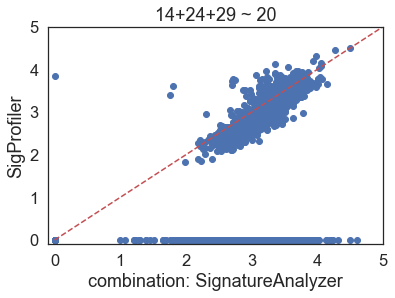

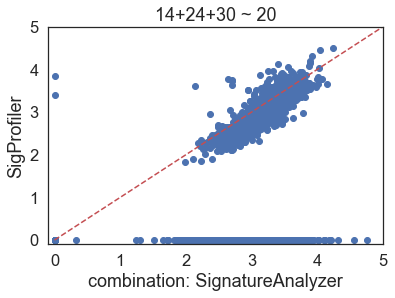

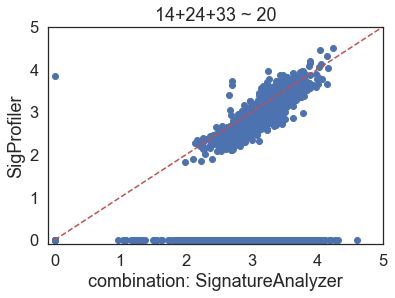

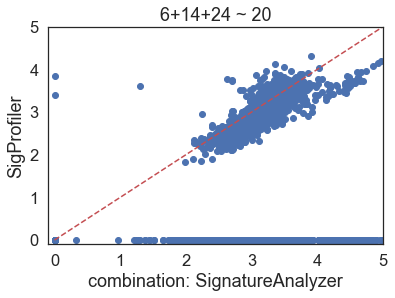

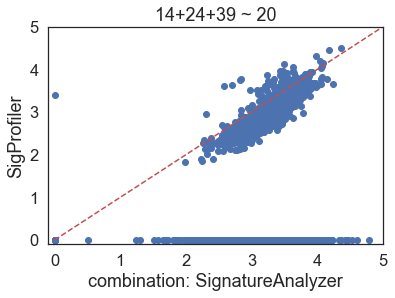

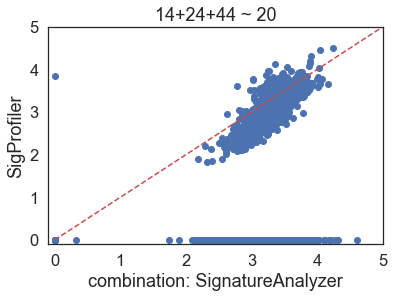

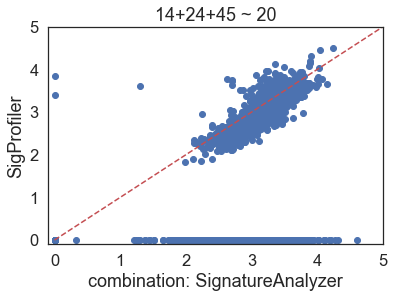

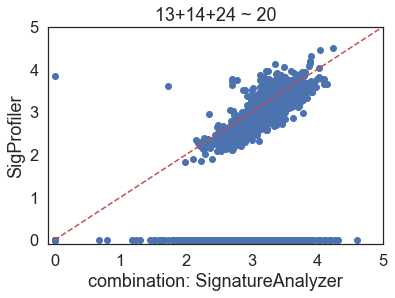

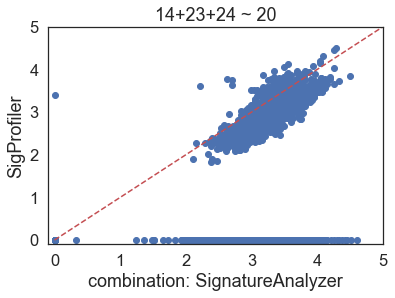

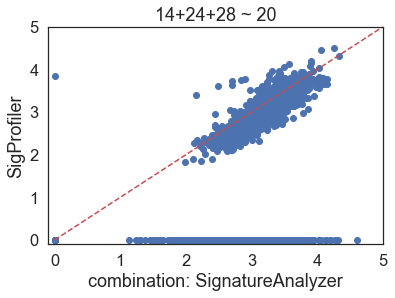

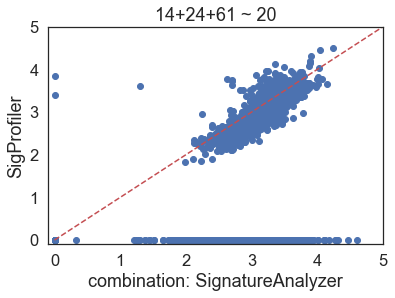

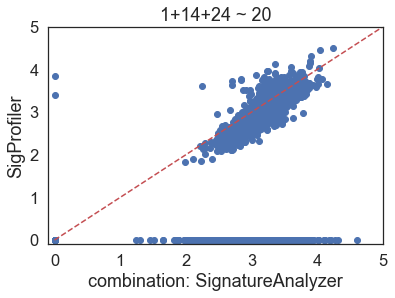

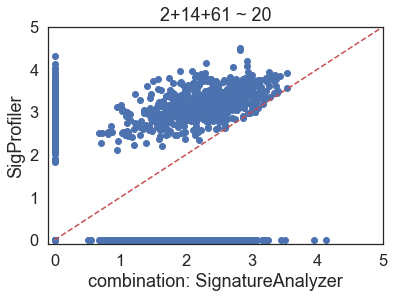

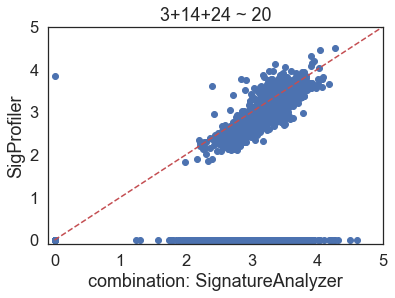

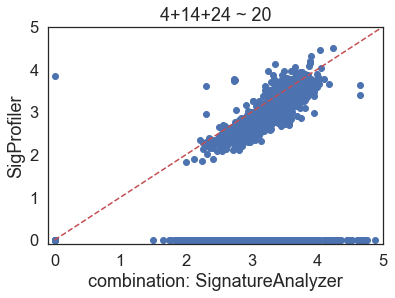

In [103]:
target_label = '20_0.92'
for c, weights, cos in all_results[:20]:
    rough_concordance(c, target_label, weights)

## doublets

In [203]:
from itertools import product

res_sigprofiler_dbs = pd.read_csv(sp_proc_dbs_path, sep='\t', index_col=0)
res_siganalyzer_dbs = pd.read_csv(sa_proc_dbs_path, sep='\t', index_col=0)
sig_dbs_dict = {'sp': res_sigprofiler_dbs, 'sa': res_siganalyzer_dbs}


def closest_dbs_combination(s, method='sa'):
    
    pool = sig_dbs_dict[method].columns
    cosine = 0
    c1, c2 = None, None
    target = None
    all_results = []
    for i, j in product(range(len(pool)), repeat=2):
        if i < j:
            w, cos = haradhvala_optimize(sig_dbs_dict[method].iloc[:,i].values, sig_dbs_dict[method].iloc[:,j].values, s)
            cos = np.round(cos, 3)
            w = tuple(map(lambda x: np.round(x, 3), w))
            all_results.append((pool[i], pool[j], w, cos))
            if cos > cosine:
                cosine = cos
                c1, c2 = pool[i], pool[j]
                weights = w
    all_results = sorted(all_results, key=lambda x: x[3], reverse=True)
    return c1, c2, weights, cosine, all_results

In [204]:
sig_dbs_dict['sp'].columns

Index(['1_DBS1_0.999509_1.0', '2_1.0', '3_1.0', '4_DBS2_0.996242_1.0',
       '5_DBS5_0.944431_1.0'],
      dtype='object')

In [205]:
sig = sig_dbs_dict['sp']['5_DBS5_0.944431_1.0'].values
c1, c2, weights, cosine, all_results = closest_dbs_combination(sig, method='sa')

ValueError: operands could not be broadcast together with shapes (73,) (78,) 

In [166]:
c1, c2, weights, cosine

('3_1', '9_1', (0.358, 0.642), 0.998)

In [167]:
all_results[:20]

[('3_1', '9_1', (0.358, 0.642), 0.998),
 ('9_1', '10_1', (0.828, 0.172), 0.791),
 ('1_DBS2_0.998322_1', '9_1', (0.0, 1.0), 0.783),
 ('2_DBS8_0.898997_1', '9_1', (0.0, 1.0), 0.783),
 ('4_1', '9_1', (0.0, 1.0), 0.783),
 ('5_DBS7_0.942649_1', '9_1', (0.026, 0.974), 0.783),
 ('6_1', '9_1', (0.0, 1.0), 0.783),
 ('7_DBS1_0.999445_1', '9_1', (0.0, 1.0), 0.783),
 ('8_1', '9_1', (0.0, 1.0), 0.783),
 ('9_1', '11_1', (1.0, 0.0), 0.783),
 ('9_1', '12_1', (1.0, 0.0), 0.783),
 ('9_1', '13_1', (1.0, 0.0), 0.783),
 ('9_1', '14_DBS6_0.949501_1', (0.966, 0.034), 0.783),
 ('3_1', '4_1', (0.515, 0.485), 0.707),
 ('3_1', '13_1', (0.796, 0.204), 0.684),
 ('3_1', '5_DBS7_0.942649_1', (0.852, 0.148), 0.678),
 ('3_1', '6_1', (0.912, 0.088), 0.678),
 ('3_1', '12_1', (0.837, 0.163), 0.678),
 ('3_1', '11_1', (0.867, 0.133), 0.677),
 ('3_1', '14_DBS6_0.949501_1', (0.867, 0.133), 0.677)]

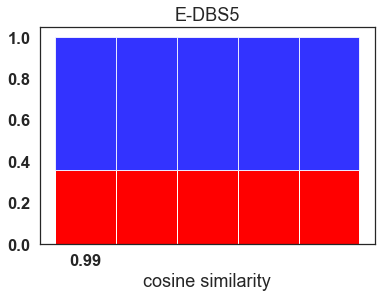

In [229]:
# stacked barplot

# libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
 
# y-axis in bold
rc('font', weight='bold')

# groups: ESBS14, ESBS37, other 

# Values of each group
dbs3 = [0.358]
dbs9 = [0.642]


# Names of group and bar width
names = ['0.99']
barWidth = 1

# Create brown bars
plt.bar(r, dbs3, color='red', edgecolor='white', width=barWidth)
# Create green bars (middle), on top of the firs ones
plt.bar(r, dbs9, bottom=dbs3, color='blue', alpha=0.8, edgecolor='white', width=barWidth)
 
# Custom X axis
plt.xticks(r, names, fontweight='bold')
plt.xlabel("cosine similarity")

plt.title('E-DBS5')

plt.savefig('/home/fmuinos/projects/oriol/treatment_effects/reviews/cosinus_similarity_edbs5.svg', bbox_inches='tight', dpi=200)

In [269]:
sp_exp_dbs_path = '/workspace/projects/mutfootprints/mutfootprints/data/HMF/20190502/signature_extraction/results/SigProfiler/dbs/exposures/PanNoSkinNoUnknown.dbs/PanNoSkinNoUnknown.dbs.exposures.tsv'
sa_exp_dbs_path = '/workspace/projects/mutfootprints/mutfootprints/data/HMF/20190502/signature_extraction/results/SignatureAnalyzer/dbs/exposures/Pan/Pan.exposures.tsv'

In [270]:
exp_sigprofiler_dbs = pd.read_csv(sp_exp_dbs_path, sep='\t', index_col=0)
exp_siganalyzer_dbs = pd.read_csv(sa_exp_dbs_path, sep='\t', index_col=0)

In [271]:
columns_sa = set(exp_sigprofiler_dbs.columns)
columns_sp = set(exp_siganalyzer_dbs.columns)
samples = columns_sa.intersection(columns_sp)

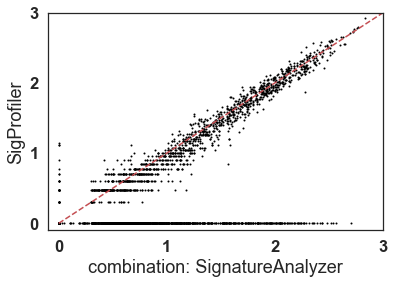

In [272]:
sa_exposure = exp_siganalyzer_dbs[samples]
sp_exposure = exp_sigprofiler_dbs[samples]

y = sp_exposure.loc['5_DBS5_0.944431_1.0'].values
index1 = [i for i, a in enumerate(y) if a > 0]

c_vector = sa_exposure.loc[['3_1', '9_1'],:].values
x = np.dot(np.ones(c_vector.shape[0]), c_vector)

index2 = [i for i, a in enumerate(x) if a > 0]
index = list(set(index1).intersection(set(index2)))

plt.scatter(np.log10(x+1), np.log10(y+1), color='black', s=1)

plt.plot(np.linspace(0, 5, 100), np.linspace(0, 5, 100), 'r--')

plt.xlim(-0.1, 3)
plt.ylim(-0.1, 3)
plt.xlabel('combination: SignatureAnalyzer')
plt.ylabel('SigProfiler')
plt.savefig(f'rough_dbs_{str(c)}.svg', dpi=200, bbox_anchor='tight')
plt.show()

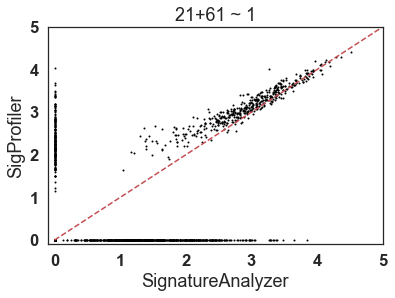

In [273]:
# compare exposures of capecitabine

columns_sa = set(sig_dict['exp']['sa'].columns)
columns_sp = set(sig_dict['exp']['sp'].columns)
samples = columns_sa.intersection(columns_sp)

sa_exposure = sig_dict['exp']['sa'][samples]
sp_exposure = sig_dict['exp']['sp'][samples]

y = sp_exposure.loc['19_SBS17b_0.961548_0.99'].values
x = sa_exposure.loc['31_SBS17b_0.968799_1'].values

plt.scatter(np.log10(x+1), np.log10(y+1), color='black', s=1)

plt.plot(np.linspace(0, 5, 100), np.linspace(0, 5, 100), 'r--')

plt.xlim(-0.1, 5)
plt.ylim(-0.1, 5)
plt.xlabel('SignatureAnalyzer')
plt.ylabel('SigProfiler')
plt.title(f'{"+".join(list(map(lambda x: x.split("_")[0], c)))} ~ {target_label.split("_")[0]}')

plt.savefig('rough_capecitabines.svg', dpi=200, bbox_anchor='tight')
plt.show()

## plot signatures

In [25]:
def false_discovery_combination(n_draws, n_channels, pool_size=12):
    
    signatures = [c for c in signatures_SP.columns if c.startswith('SBS')]
    
    # create pool of random signatures
    pool = []
    random_labels = np.random.choice(signatures, size=n_draws*pool_size)
    shuffled_sigs = [signatures_SP[label].values[np.random.permutation(n_channels)] for label in random_labels]
    
    cosines = []
    for i in tqdm.tqdm(range(n_draws)):
        cosine = closest_to_cosmic_pool(shuffled_sigs[i*pool_size: (i+1)*pool_size])
        cosines.append(cosine)
    return cosines

In [26]:
cosines = false_discovery_combination(100, 96)

100%|██████████| 100/100 [04:21<00:00,  2.63s/it]


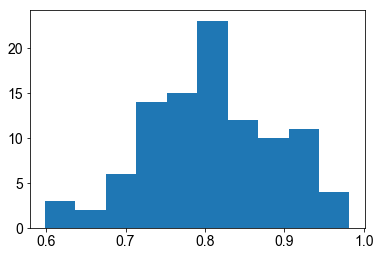

In [27]:
plt.hist(cosines, bins=10)
plt.show()

### check signatures

In [168]:
def key_func(r):
    subs = r['Type']
    triplet = r['SubType']
    return (subs[0]+subs[-1], triplet[0]+triplet[-1])
signatures_SP['key'] = signatures_SP.apply(lambda r: key_func(r), axis=1)
signatures_SP.set_index('key', inplace=True)
del signatures_SP['Type']
del signatures_SP['SubType']

In [169]:
signatures_SP.head()

SBS1          SBS2     SBS3    SBS4     SBS5      SBS6  \
key                                                                    
(CA, AA)  0.000886  5.800000e-07  0.02080  0.0422  0.01200  0.000425   
(CA, AC)  0.002280  1.480000e-04  0.01650  0.0333  0.00944  0.000524   
(CA, AG)  0.000177  5.230000e-05  0.00175  0.0156  0.00185  0.000052   
(CA, AT)  0.001280  9.780000e-05  0.01220  0.0295  0.00661  0.000180   
(CA, CA)  0.000312  2.080000e-04  0.02250  0.0807  0.00743  0.001820   

             SBS7a     SBS7b     SBS7c     SBS7d  ...    SBS51    SBS52  \
key                                               ...                     
(CA, AA)  0.000067  0.002330  0.004830  0.000040  ...  0.14100  0.01520   
(CA, AC)  0.000179  0.000461  0.001150  0.000765  ...  0.00169  0.00654   
(CA, AG)  0.000071  0.000186  0.000377  0.000250  ...  0.00480  0.00414   
(CA, AT)  0.000248  0.000710  0.001960  0.004050  ...  0.02120  0.00924   
(CA, CA)  0.000455  0.001140  0.000109  0.014500  ...  0.00698  0.05740   

             SBS53     SBS54     SBS55     SBS56    SBS57     SBS58     SBS59  \
key                                                                             
(CA, AA)  0.005380  0.002160  0.005880  0.012600  0.01230  0.058900  0.003590   
(CA, AC)  0.001960  0.000796  0.002050  0.015700  0.00143  0.006750  0.002370   
(CA, AG)  0.038100  0.001640  0.000045  0.000206  0.00333  0.000825  0.000142   
(CA, AT)  0.000017  0.000414  0.001170  0.023000  0.00864  0.005580  0.014500   
(CA, CA)  0.334000  0.000063  0.006250  0.002480  0.00870  0.006180  0.002230   

                 SBS60  
key                     
(CA, AA)  6.150000e-03  
(CA, AC)  7.790000e-04  
(CA, AG)  2.230000e-16  
(CA, AT)  4.440000e-04  
(CA, CA)  1.180000e-03  

[5 rows x 65 columns]

In [170]:
signatures_SP_dict = {sig: dict(zip(list(signatures_SP.index), list(signatures_SP[sig].values))) for sig in signatures_SP.columns}

In [171]:
def key_func(r):
    subs, triplet = tuple(r['feature'].split('_at_'))
    return (subs[0]+subs[-1], triplet[0]+triplet[-1])
signatures_SA['feature'] = signatures_SA.apply(lambda r: key_func(r), axis=1)
signatures_SA.set_index('feature', inplace=True)

In [172]:
signatures_SA.head()

SBS1      SBS2      SBS3      SBS4      SBS5      SBS6  \
feature                                                                
(TG, TT)  0.002352  0.000704  0.008163  0.000791  0.002148  0.007309   
(TG, GT)  0.000272  0.000124  0.011065  0.000384  0.000633  0.001776   
(TG, CT)  0.000005  0.000294  0.007135  0.000540  0.002113  0.003573   
(TG, AT)  0.001271  0.000180  0.004720  0.000310  0.000665  0.000428   
(TG, TG)  0.000728  0.000389  0.007332  0.002588  0.002410  0.002752   

             SBS7a     SBS7b     SBS7c      SBS8  ...         SBS74     SBS75  \
feature                                           ...                           
(TG, TT)  0.000074  0.003474  0.029112  0.002665  ...  1.690000e-05  0.002038   
(TG, GT)  0.001181  0.003073  0.008440  0.002112  ...  1.140000e-23  0.008463   
(TG, CT)  0.000195  0.001463  0.007640  0.000289  ...  1.586250e-04  0.000673   
(TG, AT)  0.000282  0.000797  0.001684  0.000586  ...  1.411910e-04  0.003473   
(TG, TG)  0.000060  0.002246  0.004244  0.006159  ...  2.770400e-04  0.000553   

             SBS76     SBS77     SBS78     SBS79     SBS80         SBS81  \
feature                                                                    
(TG, TT)  0.013811  0.076015  0.242135  0.004122  0.008277  0.000000e+00   
(TG, GT)  0.010325  0.000578  0.009526  0.049626  0.002799  6.587655e-03   
(TG, CT)  0.004447  0.003256  0.032032  0.024046  0.001569  6.430000e-19   
(TG, AT)  0.008278  0.007627  0.020323  0.005942  0.015103  1.785634e-03   
(TG, TG)  0.006216  0.013041  0.005429  0.002558  0.004270  2.453640e-04   

             SBS82  SBS83  
feature                    
(TG, TT)  0.009197    0.0  
(TG, GT)  0.008781    0.0  
(TG, CT)  0.011743    0.0  
(TG, AT)  0.015120    0.0  
(TG, TG)  0.010543    0.0  

[5 rows x 60 columns]

In [176]:
signatures_SA_dict = {sig: dict(zip(list(signatures_SA.index), list(signatures_SA[sig].values))) for sig in signatures_SA.columns}

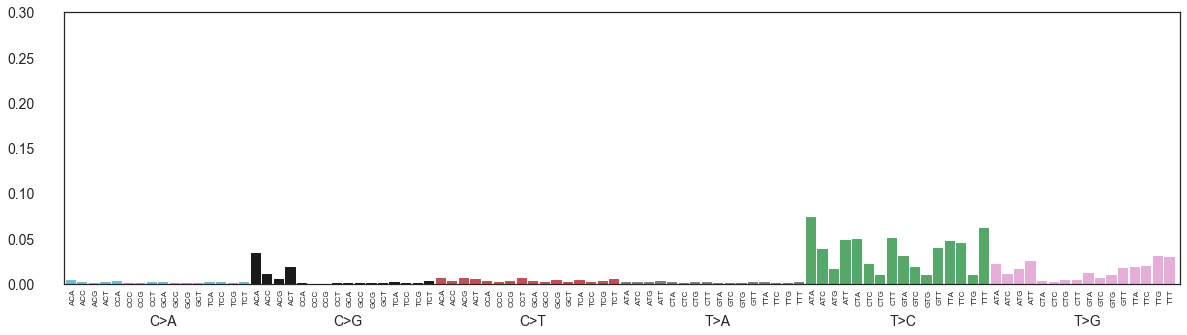

In [184]:
fig, ax = plt.subplots(figsize=(20, 5))
plot_signature(signatures_SP_dict['SBS37'], ax=ax)
plt.show()
#fig.savefig(f'figures/profile.svg', dpi=200, bbox_inches='tight')

### plots 

In [174]:
def plot_profiles(etiology, **kwargs):
    sig = synthetic.etiologies[etiology]
    fig, ax = plt.subplots(figsize=(20, 5))
    plot_signature(signatures_SP_dict[sig], ax=ax, **kwargs)
    fig.savefig(f'figures/profile_{etiology}.svg', dpi=200, bbox_inches='tight')

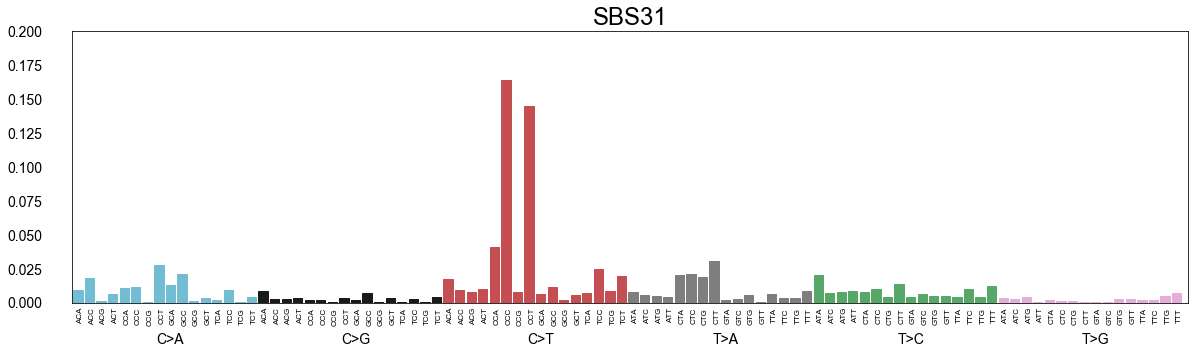

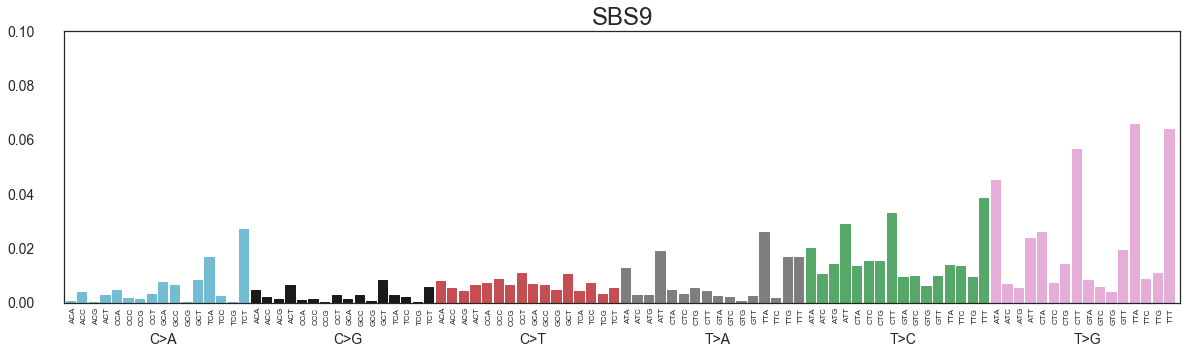

In [50]:
# plot_profiles('flat', ymax=0.06, title=synthetic.etiologies['flat'])
# plot_profiles('capecitabine', ymax=0.6, title=synthetic.etiologies['capecitabine'])
plot_profiles('platinum', ymax=0.2, title=synthetic.etiologies['platinum'])
# plot_profiles('benzo', ymax=0.15, title=synthetic.etiologies['benzo'])
# plot_profiles('apobec', ymax=0.4, title=synthetic.etiologies['apobec'])
plot_profiles('poleta', ymax=0.1, title=synthetic.etiologies['poleta'])


### Merge & dump signature tables 

In [17]:
signatures = pd.concat([signatures_SA, signatures_SP.loc[:, [c for c in signatures_SP.columns if c not in signatures_SA.columns]]], axis=1, sort=False)

In [18]:
with gzip.open('signatures.pickle.gz', 'wb') as f:
    pickle.dump(signatures, f)

In [19]:
signatures.head()

SBS1      SBS2      SBS3      SBS4      SBS5      SBS6     SBS7a  \
TG TT  0.002352  0.000704  0.008163  0.000791  0.002148  0.007309  0.000074   
   GT  0.000272  0.000124  0.011065  0.000384  0.000633  0.001776  0.001181   
   CT  0.000005  0.000294  0.007135  0.000540  0.002113  0.003573  0.000195   
   AT  0.001271  0.000180  0.004720  0.000310  0.000665  0.000428  0.000282   
   TG  0.000728  0.000389  0.007332  0.002588  0.002410  0.002752  0.000060   

          SBS7b     SBS7c      SBS8  ...     SBS49     SBS50    SBS51  \
TG TT  0.003474  0.029112  0.002665  ...  0.000364  0.001600  0.00291   
   GT  0.003073  0.008440  0.002112  ...  0.000102  0.036500  0.00209   
   CT  0.001463  0.007640  0.000289  ...  0.000093  0.000471  0.00230   
   AT  0.000797  0.001684  0.000586  ...  0.000126  0.000103  0.00213   
   TG  0.002246  0.004244  0.006159  ...  0.000112  0.008720  0.00276   

          SBS52    SBS53     SBS54         SBS56    SBS57     SBS58  \
TG TT  0.002530  0.00705  0.000499  2.900000e-02  0.11900  0.021700   
   GT  0.000864  0.00203  0.000012  1.140000e-04  0.00283  0.016900   
   CT  0.000863  0.00272  0.000886  6.780000e-18  0.00516  0.000473   
   AT  0.001860  0.00206  0.000340  5.750000e-03  0.00597  0.002080   
   TG  0.001480  0.00615  0.007690  1.010000e-04  0.00540  0.006740   

              SBS59  
TG TT  1.300000e-17  
   GT  7.450000e-03  
   CT  2.120000e-02  
   AT  3.440000e-03  
   TG  1.960000e-03  

[5 rows x 88 columns]

# ChemoMut: burden distributions 

In [20]:
def capecitabine(r):
    if r['CAPECITABINE'] > 0:
        return r['CAPECITABINE'] / (r['CAPECITABINE'] + r['CARBOPLATIN'] + r['CISPLATIN'] + r['OXALIPLATIN'])
    else:
        return 0

def platinum(r):
    if r['CARBOPLATIN'] + r['CISPLATIN'] + r['OXALIPLATIN'] > 0:
        return 1 - (r['CAPECITABINE'] / (r['CAPECITABINE'] + r['CARBOPLATIN'] + r['CISPLATIN'] + r['OXALIPLATIN']))
    else:
        return 0

In [21]:
df = pd.read_csv('./TableS2.csv', sep='\t')
df.fillna(0, inplace=True)
df.rename(columns={'Proportion treatment related mutations': 'proportion'}, inplace=True)
df.rename(columns={'Total treatment related mutations': 'treatment'}, inplace=True)
df['capecitabine_specific'] = df.apply(capecitabine, axis=1)
df['platinum_specific'] = df.apply(platinum, axis=1)
df.head()

Sample_ID Tumor type       AGING  CAPECITABINE  CARBOPLATIN    CISPLATIN  \
0        212     Breast  398.392526      0.000000          0.0     0.000000   
1       2881       Lung    0.000000      0.000000          0.0  4364.180287   
2        216     Breast  315.569017      0.000000          0.0     0.000000   
3       1433       Lung  609.368970      0.000000          0.0  1263.983105   
4        220     Breast  227.850259   1280.712857          0.0     0.000000   

   OXALIPLATIN  Gene-affecting AGING  Gene-affecting CAPECITABINE  \
0          0.0              5.664681                     0.000000   
1          0.0              0.000000                     0.000000   
2          0.0              4.487027                     0.000000   
3          0.0              0.000000                     0.000000   
4          0.0              3.239767                    18.210257   

   Gene-affecting CARBOPLATIN  ...  Gene-affecting OXALIPLATIN  \
0                         0.0  ...                         0.0   
1                         0.0  ...                         0.0   
2                         0.0  ...                         0.0   
3                         0.0  ...                         0.0   
4                         0.0  ...                         0.0   

   CGC-affecting AGING  CGC-affecting CAPECITABINE  CGC-affecting CARBOPLATIN  \
0             0.279327                    0.000000                        0.0   
1             0.000000                    0.000000                        0.0   
2             0.221257                    0.000000                        0.0   
3             0.000000                    0.000000                        0.0   
4             0.159754                    0.897954                        0.0   

   CGC-affecting CISPLATIN  CGC-affecting OXALIPLATIN  proportion  treatment  \
0                      0.0                        0.0    0.000000        0.0   
1                      0.0                        0.0    0.040567     4364.5   
2                      0.0                        0.0    0.000000        0.0   
3                      0.0                        0.0    0.058099     1264.0   
4                      0.0                        0.0    0.205241     1280.5   

   capecitabine_specific  platinum_specific  
0                    0.0                0.0  
1                    0.0                1.0  
2                    0.0                0.0  
3                    0.0                1.0  
4                    1.0                0.0  

[5 rows x 21 columns]

### capecitabine: burden distribution 

Check the burden distribution of capecitabine in Breast

In [22]:
df_cap = df[df['capecitabine_specific'] == 1].copy()
df_cap['total'] = df_cap.apply(lambda r: r['treatment'] / r['proportion'], axis=1)
df_cap = df_cap[df_cap['total'] < 1e5]
prop_cap = df_cap[['proportion']].copy()
p_cap = prop_cap.values[:, 0]

### platinum-based drugs: burden distribution

In [23]:
df_platinum = df[df['platinum_specific'] == 1].copy()
df_platinum['total'] = df_platinum.apply(lambda r: r['treatment'] / r['proportion'], axis=1)
df_platinum = df_platinum.loc[lambda x: x.total < 1e5]
prop_platinum = df_platinum[['proportion']].copy()
p_platinum = prop_platinum.values[:, 0]

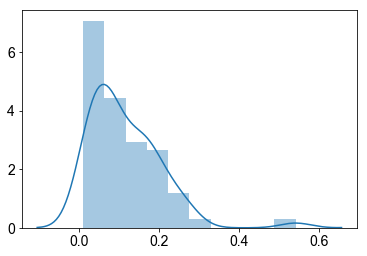

In [24]:
import seaborn
seaborn.distplot(p_cap, bins=10)
plt.show()

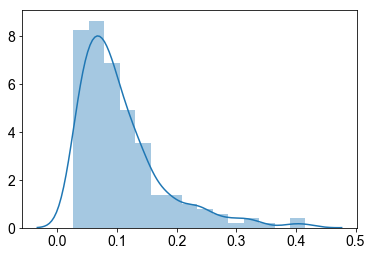

In [25]:
seaborn.distplot(p_platinum, bins=15)
plt.show()

### Beta-parameters: capecitabine & platinum-based

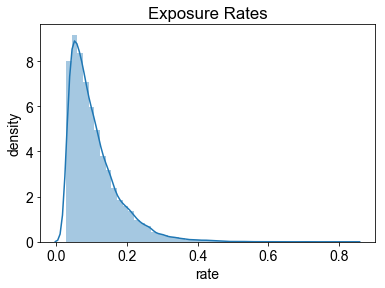

In [27]:
params = {}
params = scipy.stats.beta.fit(p_platinum)
a, b, loc, scale = params
random = scipy.stats.beta.rvs(a, b, loc=loc, scale=scale, size=10000)
seaborn.distplot(random)
plt.title('Exposure Rates')
plt.ylabel('density')
plt.xlabel('rate')
plt.savefig('figures/beta_exposure_rates.svg', dpi=200)

In [28]:
a, b, loc, scale

(1.2784718035988452,
 833471.2073843926,
 0.02667450686140428,
 51675.285728556075)

# Generate Synthetic Catalogue

Each sample of the synthetic dataset results from the following generating process:

### Primary Signal comes from PCAWG_Breast_AdenoCA

- randomly pick one sample from PCAWG_Breast_AdenoCA dataset as template
- take the templates profile and burden N
- sample N mutations according to the profile

### Treatment Signal

For each sample assigned to treatment
- pick Ts samples as treated
- for each treated sample, draw a value p in [0,1] that corresponds to the proportion of mutations that will be explained to treatment 
- then for each sample s compute the number of mutations n(s) explained by treatment
- for each sample s, sample n(s) mutations from the treatment profile

In [29]:
class Synthetic:
    
    def __init__(self, act, proc, params):
        
        self.sample_index  = np.array(act.columns)
        self.process_index = np.array(act.index)
        self.channel_index = np.array(proc.index)
        self.act  = act.values                    # cols=samples; rows=processes
        self.proc = proc[list(act.index)].values  # cols=processes; rows=channels
        self.params = params
        self.etiologies = {'platinum': 'SBS31', 'poleta': 'SBS9'}
        
    @property
    def templates(self):
        
        channel_exposure = np.dot(self.proc, self.act)
        return dict(zip(self.sample_index, list(channel_exposure.T)))
        
    def pick_samples(self, n_samples):
        
        return list(np.random.choice(self.sample_index, size=n_samples, replace=True))
    
    def primary_draw(self, n_samples):
        
        samples = self.pick_samples(n_samples)
        df_dict = {}
        for i, s in enumerate(samples):
            template = self.templates[s]
            total = np.sum(template)
            profile = template / total
            df_dict[f'sample_{i+1}_{s.split("__")[0]}'] = list(np.random.multinomial(int(total), pvals=profile))
        return pd.DataFrame(df_dict)

    def proportion_treated(self, n, treatment):

        # these parameters are obtained upon fitting the estimated
        # proportions observed in Hartwig Breast samples
        
        a, b, loc, scale = self.params
        return scipy.stats.beta.rvs(a, b, loc=loc, scale=scale, size=n)

    
    def full_draw(self, n_samples, n_treated, treatment):
        
        catalogue = self.primary_draw(n_samples)
        catalogue.rename(columns=dict(zip(list(catalogue.columns)[:n_treated], list(map(lambda s: s + '_t', list(catalogue.columns)[:n_treated])))), inplace=True)
        
        beta_p = self.proportion_treated(n_samples, treatment)
        all_burden = catalogue.sum(axis=0).values
        burden = np.array([b*(beta_p[i]/(1 - beta_p[i])) if i < n_treated else 0 for i, b in enumerate(all_burden)])
        sig = self.etiologies[treatment]
        index_sig = list(self.process_index).index(sig)
        profile = self.proc[:, index_sig]
        
        df_dict = {}
        for i, s in enumerate(catalogue.columns):
            df_dict[s] = list(np.random.multinomial(int(burden[i]), pvals=profile))
        treat_df = pd.DataFrame(df_dict)
        catalogue.loc[:,:] += treat_df.loc[:,:]
        res = {'catalogue': catalogue, 'burden': burden}
        return res

In [30]:
# select activities in breast cancer

breastlungcolon_cols = list(filter(lambda x: x.split('__')[0] in ['Breast_AdenoCA', 'Lung_AdenoCA', 'ColoRect_AdenoCA'], activities.columns))
breastlungcolon = activities.reindex(index=signatures.columns, fill_value=0)
breastlungcolon = breastlungcolon.loc[signatures.columns, breastlungcolon_cols]
breastlungcolon.fillna(0, inplace=True)


breast_cols = list(filter(lambda x: x.split('__')[0] in ['Breast_AdenoCA'], activities.columns))
breast = activities.reindex(index=signatures.columns, fill_value=0)
breast = breast.loc[signatures.columns, breast_cols]
breast.fillna(0, inplace=True)

# Heatmap of activitites

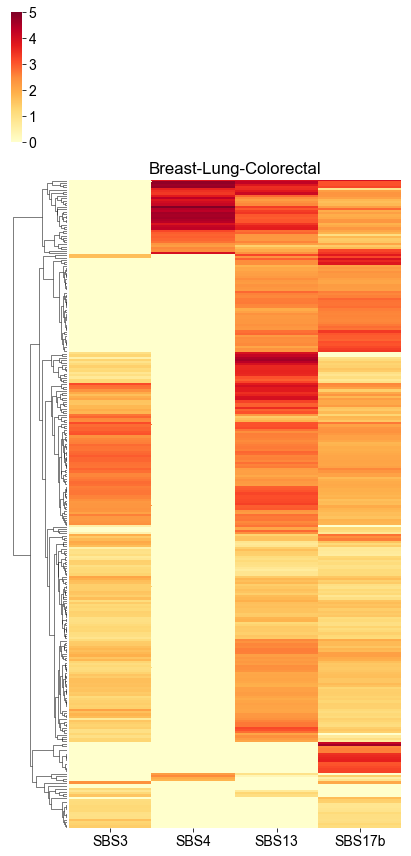

In [74]:
active_breastlungcolon = ['SBS3', 'SBS4', 'SBS13', 'SBS17b']
log_breastlungcolon = pd.DataFrame(columns=breastlungcolon.columns, index=active_breastlungcolon)
log_breastlungcolon.loc[active_breastlungcolon, :] = np.log10(breastlungcolon.loc[active_breastlungcolon, :].values + 1)
g = seaborn.clustermap(log_breastlungcolon.transpose(), figsize=(7, 15), yticklabels=False, col_cluster=False, cmap="YlOrRd", cbar='right', vmin=0, vmax=5)
g.ax_heatmap.set_title('Breast-Lung-Colorectal')
plt.savefig('./figures/heatmap_breastlungcolon.svg', dpi=200)

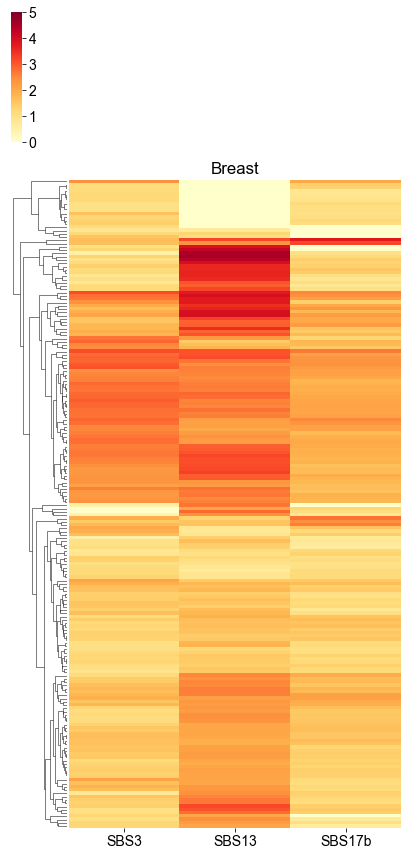

In [75]:
active_breast = ['SBS3', 'SBS13', 'SBS17b']
log_breast = pd.DataFrame(columns=breast.columns, index=active_breast)
log_breast.loc[active_breast, :] = np.log10(breast.loc[active_breast, :].values + 1)
g = seaborn.clustermap(log_breast.transpose(), figsize=(7, 15), yticklabels=False, col_cluster=False, cmap="YlOrRd", cbar='right', vmin=0, vmax=5)
g.ax_heatmap.set_title('Breast')
plt.savefig('./figures/heatmap_breast.svg', dpi=200)

In [31]:
synthetic = Synthetic(breastlungcolon, signatures, params)

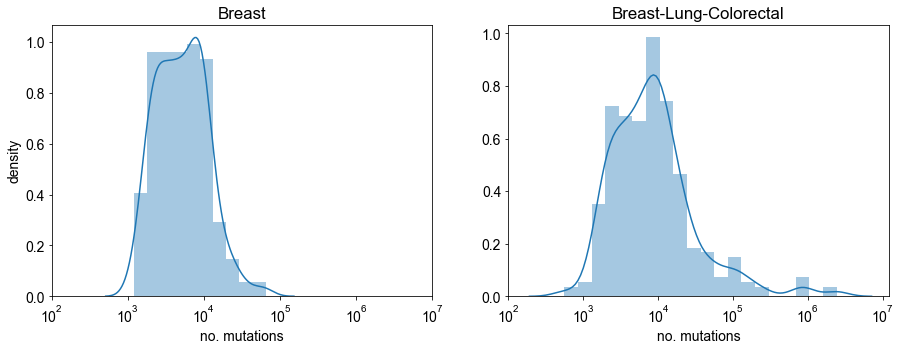

In [32]:
# burden distribution

breast_burden = np.log10(breast.sum(axis=0).values)
fig, ax = plt.subplots(figsize=(15, 5), ncols=2)
breastlungcolon_burden = np.log10(breastlungcolon.sum(axis=0).values)
seaborn.distplot(breast_burden, ax=ax[0])
seaborn.distplot(breastlungcolon_burden, ax=ax[1])

ax[0].set_title('Breast')
xticks = [2, 3, 4, 5, 6, 7]
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(labels=ax[0].set_xticklabels(labels=list(map(lambda x: f'$10^{str(x)}$', xticks))))
ax[0].set_xlabel('no. mutations')
ax[0].set_ylabel('density')

ax[1].set_xticks(xticks)
ax[1].set_xticklabels(labels=ax[1].set_xticklabels(labels=list(map(lambda x: f'$10^{str(x)}$', xticks))))
ax[1].set_title('Breast-Lung-Colorectal')
ax[1].set_xlabel('no. mutations')
plt.savefig('figures/burden_distribution.png', dpi=200, bbox_inches='tight')

plt.show()

In [33]:
len(breast_cols)

198

In [34]:
len(breastlungcolon_burden)

296

tumor types = breast, lung, colon-rectum

samples = 300

n_treatments = [10, 25, 50, 100, 150]

replicates = 25

In [50]:
with open('catalogues/keys.json', 'wt') as f:
    json.dump(list(synthetic.channel_index), f)

np.random.seed(42)
for etiology in synthetic.etiologies:
    for n_treated in [10, 25, 50, 100, 150]:
        for replicate in range(25):
            res = synthetic.full_draw(300, n_treated, etiology)
            res['catalogue'].to_csv(f'catalogues/breastlungcolon/{etiology}.{n_treated}.{replicate}.catalogue.tsv', sep='\t', index=False)
            with open(f'catalogues/breastlungcolon/{etiology}.{n_treated}.{replicate + 1}.burden.json', 'wt') as f:
                json.dump(list(res['burden']), f)

In [51]:
example = synthetic.full_draw(300, 5, 'capecitabine')
example['catalogue'].head()

sample_1_Breast_AdenoCA_t  sample_2_ColoRect_AdenoCA_t  \
0                        145                         1041   
1                         97                          759   
2                        394                         2929   
3                         63                          482   
4                         17                          209   

   sample_3_Breast_AdenoCA_t  sample_4_ColoRect_AdenoCA_t  \
0                        310                        31210   
1                        215                         3407   
2                        878                        13480   
3                        152                         6247   
4                         62                          556   

   sample_5_ColoRect_AdenoCA_t  sample_6_Breast_AdenoCA  \
0                          460                      123   
1                          312                       52   
2                         1440                      107   
3                          201                       60   
4                           67                       89   

   sample_7_ColoRect_AdenoCA  sample_8_Breast_AdenoCA  \
0                     146108                       35   
1                       4459                       15   
2                      17039                       22   
3                      28319                       23   
4                       3380                       18   

   sample_9_Breast_AdenoCA  sample_10_Lung_AdenoCA  ...  \
0                       28                      64  ...   
1                        6                      21  ...   
2                       17                      47  ...   
3                       12                      47  ...   
4                        8                      27  ...   

   sample_291_Lung_AdenoCA  sample_292_ColoRect_AdenoCA  \
0                      156                          113   
1                       57                           24   
2                      149                          170   
3                       64                           35   
4                      122                           52   

   sample_293_Breast_AdenoCA  sample_294_ColoRect_AdenoCA  \
0                         25                          199   
1                          4                           79   
2                         13                          330   
3                         16                           73   
4                         12                           80   

   sample_295_Lung_AdenoCA  sample_296_Breast_AdenoCA  \
0                       71                        125   
1                       28                         55   
2                       65                         90   
3                       32                         48   
4                       35                         86   

   sample_297_Breast_AdenoCA  sample_298_ColoRect_AdenoCA  \
0                        124                          102   
1                         49                           42   
2                         91                          198   
3                         56                           31   
4                         81                           50   

   sample_299_ColoRect_AdenoCA  sample_300_Lung_AdenoCA  
0                          421                      165  
1                           57                       51  
2                          211                      164  
3                           83                       88  
4                          138                      133  

[5 rows x 300 columns]

# Recovery of synthetic signatures

In [35]:
deconstruction_folder = '/workspace/users/fmuinos/treatment_effects/simulations/deconstruction/breastlungcolon'

channel_index = synthetic.channel_index

def signature_recovery(etiology, n_treated, replicate, plot=False):
    
    twin_signals = False
    case = f'{etiology}.{n_treated}.{replicate}.catalogue.tsv'
    df = pd.read_csv(os.path.join(deconstruction_folder, f'{case}/{case}.processes.tsv'), sep='\t')
    cosines = []
    for col in df.columns:
        reference = signatures[synthetic.etiologies[etiology]].values
        profile = df[col].values 
        cosine = metrics.pairwise.cosine_similarity([reference], [profile])[0][0]
        profile_dict = dict(zip(channel_index, profile))
        cosines.append(cosine)
    similar = [c for c in cosines if c > 0.8]
    if len(similar) > 1:
        twin_signals = True
    cosine = max(cosines)
    index = [np.argmax(cosines)]
    if len(similar) > 1:
        index += list(np.argsort(cosines)[::-1][1: len(similar)])
    if plot:
        fig, ax = plt.subplots(figsize=(20, 5))
        plot_signature(profile_dict, title=f'{etiology}:{n_treated}:{np.round(cosine, 3)}', ax=ax)
        plt.show()
    return index, cosine, twin_signals

In [36]:
def scatter_cosine(etiology):
    
    fig, ax = plt.subplots()
    major_labels = [10, 25, 50, 100, 150]  # representing n_treated

    # scatter plot
    cosines = []
    x = []
    twin_signals = []
    for i, n_treated in enumerate(major_labels):
        cos = list(map(lambda x: signature_recovery(etiology, n_treated, x), range(25)))
        cosines += list(zip(*cos))[1]
        twin_signals += list(zip(*cos))[2]
        x += [i] * len(cos)
    colors = ['red' if s else 'black' for s in twin_signals]
    seaborn.violinplot(x, cosines, alpha=0.3, color='#DCDCDC', scale='count', inner=None, ax=ax)
    ax.scatter(x, cosines, color=colors, alpha=0.6)
    
    # plot layout
    major_ticks = np.arange(5)
    ax.set_ylim(0.7, 1.03)
    ax.set_xticks(ticks=major_ticks)
    ax.set_xticklabels(labels=map(str, major_labels))
    ax.set_xlabel('no. samples exposed')
    ax.set_ylabel('cosine similarity')
    ax.set_title(synthetic.etiologies[etiology])
    
    fig.savefig(f'figures/{etiology}.cosine.svg', dpi=200, bbox_inches='tight')
    plt.show()

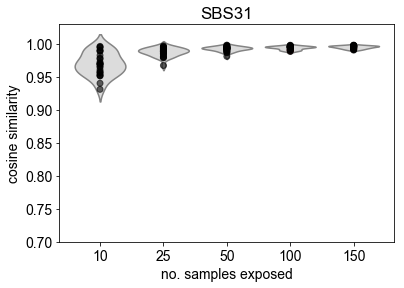

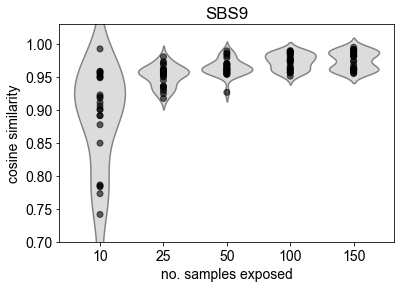

In [85]:
for etiology in synthetic.etiologies:
    scatter_cosine(etiology)

# Recovery of exposure

In [537]:
catalogue_folder = '/home/fmuinos/projects/oriol/treatment_effects/simulations/catalogues/breastlungcolon'
deconstruction_folder = '/workspace/users/fmuinos/treatment_effects/simulations/deconstruction/breastlungcolon'

channel_index = synthetic.channel_index

def exposure_recovery(etiology, n_treated, replicate):
    
    # load synthetic burden
    burden_fn = f'{etiology}.{n_treated}.{replicate+1}.burden.json'   # tsv / replicate +1 for breastlungcolon
    with open(os.path.join(catalogue_folder, burden_fn), 'rt') as f:
        burden = json.load(f)
    burden = np.array(burden[:n_treated])
    
    # load exposures
    case = f'{etiology}.{n_treated}.{replicate}.catalogue.tsv'
    exposure = pd.read_csv(os.path.join(deconstruction_folder, f'{case}/{case}.exposures.tsv'), sep='\t')
    index, cosine, twin_signals = signature_recovery(etiology, n_treated, replicate)  # replicate +1 for breast
    exposure = exposure.iloc[index[0], :n_treated].values
    return burden, exposure, twin_signals

def exposure_recovery_nontreated(etiology, n_treated, replicate):
    
    # load exposures
    case = f'{etiology}.{n_treated}.{replicate}.catalogue.tsv'
    exposure = pd.read_csv(os.path.join(deconstruction_folder, f'{case}/{case}.exposures.tsv'), sep='\t')
    index, cosine, twin_signals = signature_recovery(etiology, n_treated, replicate)
    exposure = exposure.iloc[index[0], n_treated + 1:].values
    return exposure, twin_signals

In [538]:
def exposure_recovery_plot(etiology, n_treated):

    fig, ax = plt.subplots()    
    
    for replicate in range(25):
        burden, exposure, twin_signals = exposure_recovery(etiology, n_treated, replicate)
        ax.scatter(list(burden), list(exposure), alpha=0.3, color='black')
        
    ax.set_xlabel('synthetic')
    ax.set_ylabel('reconstructed')
    ax.set_title(f'Exposure Recovery\n{synthetic.etiologies[etiology]}: {n_treated} samples exposed')
    ax.set_ylim(0, 5000)
    ax.set_xlim(0, 5000)
    x = np.linspace(0, 5000, 5000)
    diagonal = ax.plot(x, x, '--', color='red', alpha=0.5)
    fig.savefig(f'figures/exposure_recovery.{etiology}.{n_treated}.svg', dpi=200, bbox_inches='tight')






  0%|          | 0/2 [00:00<?, ?it/s]




 50%|█████     | 1/2 [00:12<00:12, 12.46s/it]




100%|██████████| 2/2 [00:23<00:00, 12.01s/it]

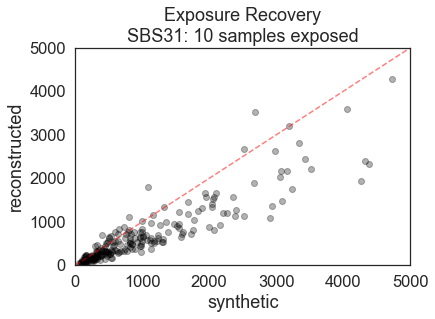

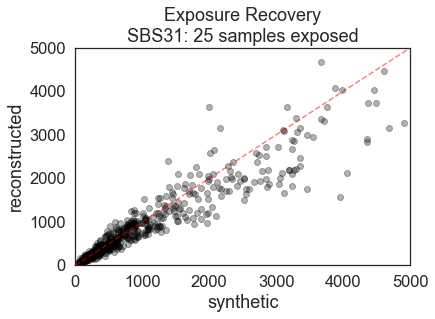

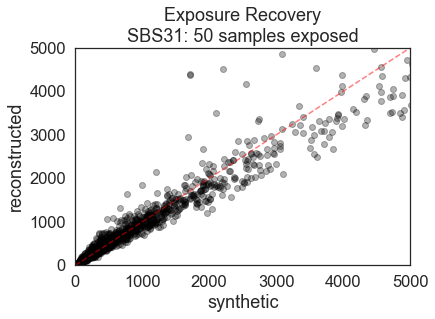

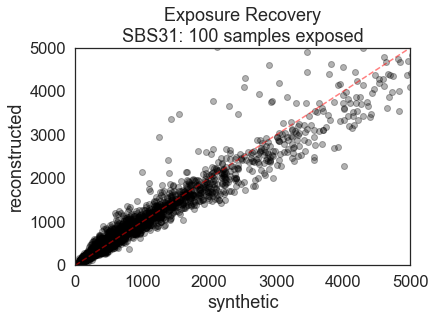

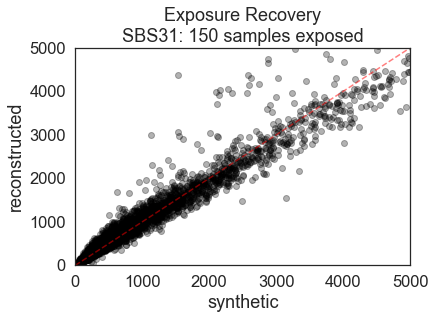

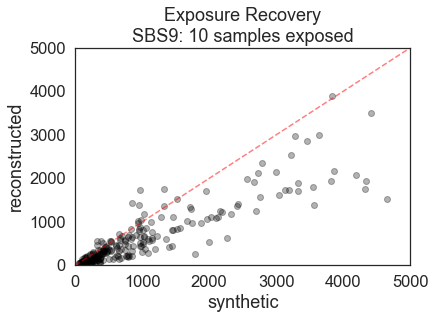

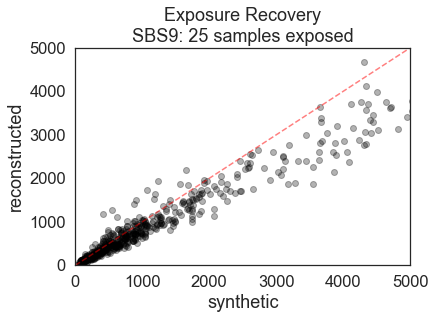

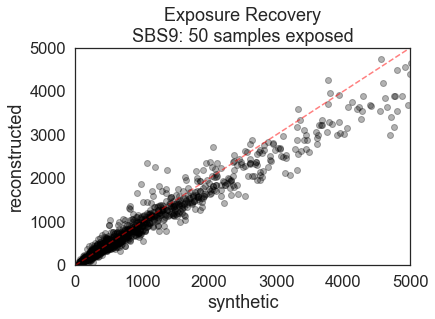

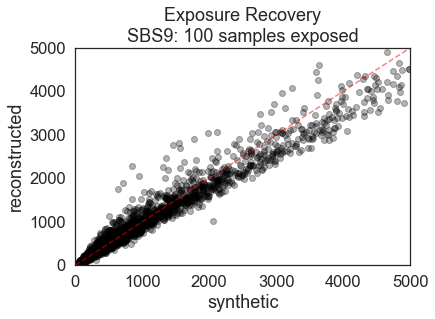

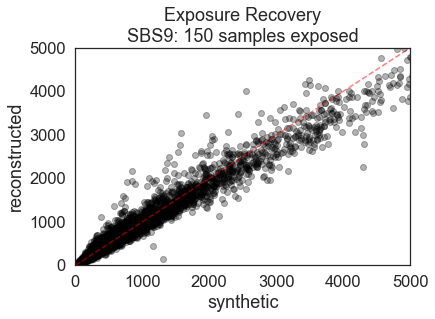

In [539]:
for etiology in tqdm.tqdm(synthetic.etiologies):
    for n_treated in [10, 25, 50, 100, 150]:
        exposure_recovery_plot(etiology, n_treated)

In [540]:
def scatter_error(etiology, option='error'):
    """
    option: 'error', 'correlation', 'concordance'
    """
    
    fig, ax = plt.subplots()
    
    # plot layout
    major_labels = [10, 25, 50, 100, 150]  # representing n_treated
    if option == 'error':
        ax.set_ylabel('mean relative error (%)')
    elif option == 'correlation':
        ax.set_ylabel('correlation')
    elif option == 'deviance':
        ax.set_ylabel('relative residual')
    elif option == 'concordance':
        ax.set_ylabel('concordance')
    # scatter plot
    values = []
    x = []
    colors = []
    for i, n_treated in enumerate(major_labels):
        for replicate in range(25):
            burden, exposure, twin_signals = exposure_recovery(etiology, n_treated, replicate)
            if option == 'error':
                value = np.mean(np.abs((burden - exposure) / burden))
            elif option == 'correlation':
                value = scipy.stats.pearsonr(burden, exposure)[0]
            elif option == 'deviance':
                value = (burden - exposure) / burden
            elif option == 'concordance':
                value = concordance_correlation_coefficient(exposure, burden)
            if twin_signals: 
                colors.append('red') 
            else: 
                colors.append('black')
            x += [i]*len(value)
            values += list(value)
            
    seaborn.violinplot(x, values, alpha=0.3, color='#DCDCDC', scale='count', inner=None, ax=ax)
    ax.scatter(x, values, alpha=0.1, color='black')
    major_ticks = np.arange(5)
    if option == 'error':
        ax.set_yticks([0, 1, 2, 3])
        ax.set_yticklabels(labels=map(str, [0, 100, 200, 300]))
    ax.set_xticks(ticks=major_ticks)
    ax.set_xticklabels(labels=map(str, major_labels))
    ax.set_title(synthetic.etiologies[etiology])
    # ax.set_ylim(-0.5, 1)
    ax.hlines(0, -0.5, 4.5, color='red', linestyles='dashed')
    ax.set_xlabel('no. exposed samples')
    fig.savefig(f'figures/{etiology}.exposure_{option}.png', dpi=200, bbox_inches='tight')
    plt.show()


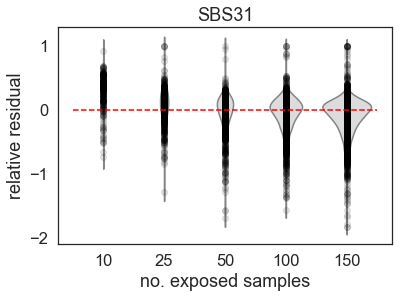

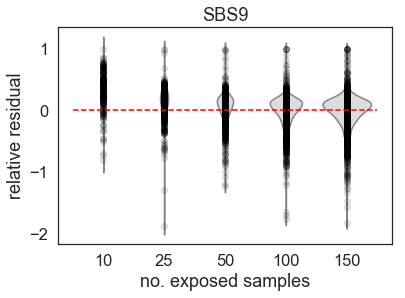

In [541]:
for etiology in synthetic.etiologies:
    scatter_error(etiology, option='deviance')

# Predicting the true exposure from the reconstructed 

In [387]:
from statsmodels.robust.robust_linear_model import RLM
from statsmodels.regression.linear_model import OLS

def provide_exog(x):
    exog_data = np.array(np.concatenate((np.array(x), np.ones_like(x))).reshape(2, len(x)))
    return np.transpose(exog_data)

# model_irls = RLM(y_coords, exog_data)
# res_irls = model_irls.fit()

def exposure_recovery_plot(etiology, n_treated):

    fig, ax = plt.subplots(ncols=2, figsize=(18, 5))    
        
    x, y = [], []
    
    for replicate in range(10):
        burden, exposure, twin_signals = exposure_recovery(etiology, n_treated, replicate + 1)
        x += list(exposure)
        y += list(burden[: n_treated])

    ax[0].scatter(x, y, alpha=0.1, color='black')
    ax[0].set_title('Conditional Expectation')
    ax[0].set_xlabel('Reconstructed')
    ax[0].set_ylabel('Synthetic')
    
    # regression: evaluate conditional expectation
    X = provide_exog(x)
    model = RLM(y, X)
    res = model.fit()
    print(res.summary2())
    ax[0].plot(x, model.predict(res.params), '--', color='blue')
        
    # regression: evaluate conditional variance
    squared_residuals = (np.array(y) - model.predict(res.params)) ** 2   

    ax[1].scatter(x, squared_residuals, alpha=0.1, color='black')
    ax[1].set_title('Conditional Variance')
    ax[1].set_xlabel('Reconstructed')
    ax[1].set_ylabel('Residuals')

    model_residuals = RLM(squared_residuals, X)
    res_residuals   = model_residuals.fit()
    print(res_residuals.summary2())
    ax[1].plot(x, model_residuals.predict(res.params), '--', color='blue')
    ax[1].set_xlim(0, 500)
    ax[1].set_ylim(0, 30000)
    
    # fig.savefig(f'figures/exposure_recovery.{etiology}.{n_treated}.png', dpi=200, bbox_inches='tight')
    plt.show()

               Results: Robust linear model
Model:               RLM              Df Residuals: 998   
Dependent Variable:  y                Norm:         HuberT
Date:                2019-05-10 17:15 Scale Est.:   mad   
No. Observations:    1000             Cov. Type:    H1    
Df Model:            1                Scale:        1096.4
----------------------------------------------------------
        Coef.   Std.Err.    z    P>|z|   [0.025    0.975] 
----------------------------------------------------------
x1       0.0007   0.0016  0.4354 0.6633  -0.0025    0.0039
const 1031.5601  34.5133 29.8887 0.0000 963.9152 1099.2050

                       Results: Robust linear model
Model:                   RLM                  Df Residuals:     998       
Dependent Variable:      y                    Norm:             HuberT    
Date:                    2019-05-10 17:15     Scale Est.:       mad       
No. Observations:        1000                 Cov. Type:        H1        
Df Model:    

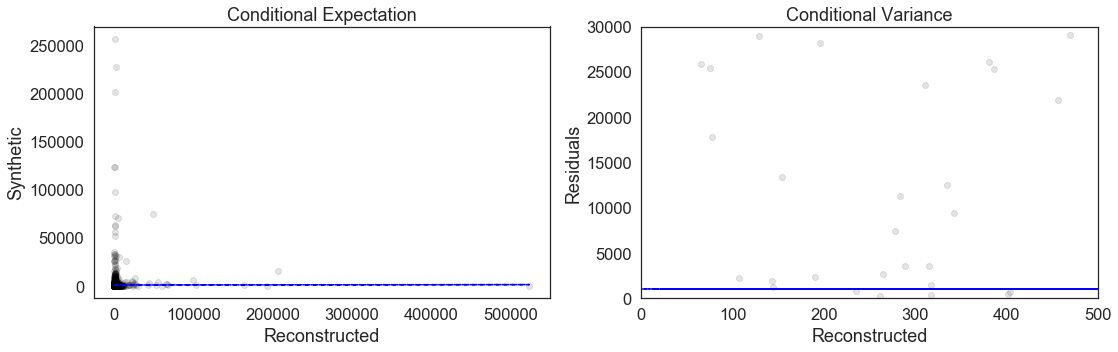

In [388]:
exposure_recovery_plot('poleta', 100)

In [156]:
def exposure_recovery_nontreated_plot(etiology):

    fig, ax = plt.subplots()    
    major_labels = [10, 25, 50, 100, 150]  # representing n_treated
    
    x = []
    values = []
    colors = []
    
    for i, n_treated in enumerate(major_labels):
        for replicate in range(10):
            
            # load synthetic burden
            burden_fn = f'{etiology}.{n_treated}.{replicate+1}.burden.tsv'
            with open(os.path.join(catalogue_folder, burden_fn), 'rt') as f:
                burden = json.load(f)
            burden = np.array(burden[:n_treated])

            exposure, twin_signals = exposure_recovery_nontreated(etiology, n_treated, replicate + 1)
            print(len(exposure))
            print(len(burden))
            print(burden)
            x += [i] * len(exposure)
            values += (exposure - burden) / burden
            if twin_signals:
                colors.append('red') 
            else: 
                colors.append('black')

    seaborn.violinplot(x, values, alpha=0.3, color='#DCDCDC', scale='count', inner=None, ax=ax)
    ax.scatter(x, values, alpha=0.3, color=colors)
    
    major_ticks = np.arange(5)
    ax.set_xticks(ticks=major_ticks)
    ax.set_xticklabels(labels=map(str, major_labels))
    ax.set_title(synthetic.etiologies[etiology])
    ax.set_xlabel('no. exposed samples')
    ax.set_ylabel('average exposure over\naverage injected burden')
    ax.set_ylim(-0.08, 0.6)
    fig.savefig(f'figures/exposure_recovery_notreated.{etiology}.png', dpi=200, bbox_inches='tight')

In [382]:
catalogue_folder = '/home/fmuinos/projects/oriol/treatment_effects/simulations/catalogues/breastlungcolon'
deconstruction_folder = '/workspace/users/fmuinos/treatment_effects/simulations/deconstruction/breastlungcolon'

channel_index = synthetic.channel_index

def exposure_recovery(etiology, n_treated, replicate):
    
    # load synthetic burden
    burden_fn = f'{etiology}.{n_treated}.{replicate}.burden.json'
    with open(os.path.join(catalogue_folder, burden_fn), 'rt') as f:
        burden = json.load(f)
    burden = np.array(burden[:n_treated])
    
    # load exposures
    case = f'{etiology}.{n_treated}.{replicate}.catalogue.tsv'
    exposure = pd.read_csv(os.path.join(deconstruction_folder, f'{case}/{case}.exposures.tsv'), sep='\t')
    index, cosine, twin_signals = signature_recovery(etiology, n_treated, replicate)
    exposure = exposure.iloc[index[0], :n_treated].values
    return burden, exposure, twin_signals

def exposure_recovery_nontreated(etiology, n_treated, replicate):
    
    # load exposures
    case = f'{etiology}.{n_treated}.{replicate}.catalogue.tsv'
    exposure = pd.read_csv(os.path.join(deconstruction_folder, f'{case}/{case}.exposures.tsv'), sep='\t')
    index, cosine, twin_signals = signature_recovery(etiology, n_treated, replicate)
    exposure = exposure.iloc[index[0], n_treated + 1:].values
    return exposure, twin_signals

# def exposure_recovery_plot(etiology, n_treated):

#     fig, ax = plt.subplots()    
    
#     for replicate in range(10):
#         burden, exposure, twin_signals = exposure_recovery(etiology, n_treated, replicate+1)
#         ax.scatter(list(burden), list(exposure), alpha=0.3, color='black')
        
#     ax.set_xlabel('synthetic')
#     ax.set_ylabel('reconstructed')
#     ax.set_title(f'Exposure Recovery\n{synthetic.etiologies[etiology]}: {n_treated} samples exposed')
#     ax.set_ylim(0, 5000)
#     ax.set_xlim(0, 5000)
#     x = np.linspace(0, 5000, 5000)
#     diagonal = ax.plot(x, x, '--', color='red', alpha=0.5)
#     fig.savefig(f'figures/exposure_recovery.{etiology}.{n_treated}.svg', dpi=200, bbox_inches='tight')
    
def exposure_recovery_plot(etiology):

    fig, ax = plt.subplots()    
    major_labels = [10, 25, 50, 100, 150]  # representing n_treated
    
    x = []
    values = []
    
    for i, n_treated in enumerate(major_labels):
        for replicate in range(25):
            try:
                # load synthetic burden
                burden_fn = f'{etiology}.{n_treated}.{replicate}.burden.json'
                with open(os.path.join(catalogue_folder, burden_fn), 'rt') as f:
                    burden = json.load(f)
                burden = np.array(burden[:n_treated])
                burden, exposure, twin_signals = exposure_recovery(etiology, n_treated, replicate)
                x.append(i)
                values.append(np.median((exposure - burden) / burden))
            except:
                pass
    
    seaborn.violinplot(x, values, alpha=0.3, color='#DCDCDC', scale='count', inner=None, ax=ax)
    ax.scatter(x, values, alpha=0.3, color='black')
    
    major_ticks = np.arange(5)
    ax.set_xticks(ticks=major_ticks)
    ax.set_xticklabels(labels=map(str, major_labels))
    ax.set_title(synthetic.etiologies[etiology])
    ax.set_xlabel('no. exposed samples')
    ax.set_ylabel('median relative residual')
    ax.hlines(0, -0.5, 4.5, color='red', linestyles='dashed')
    #ax.set_ylim(-3, 5)
    fig.savefig(f'figures/breastlungcolon.exposure_recovery.{etiology}.png', dpi=200, bbox_inches='tight')

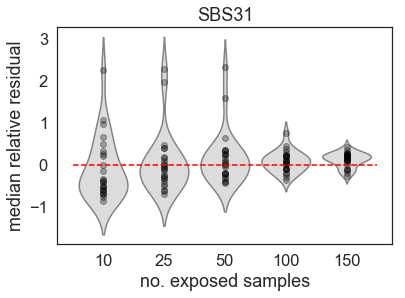

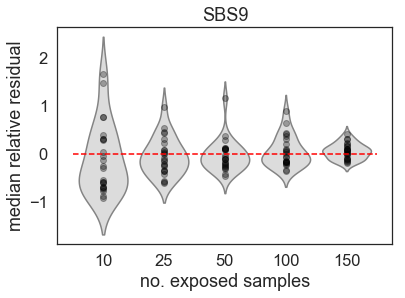

In [378]:
for etiology in synthetic.etiologies:
    exposure_recovery_plot(etiology)

In [381]:
def concordance_correlation_coefficient(y_true, y_pred, sample_weight=None, multioutput='uniform_average'):
    
    """Concordance correlation coefficient.
    The concordance correlation coefficient is a measure of inter-rater agreement.
    It measures the deviation of the relationship between predicted and true values
    from the 45 degree angle.
    Read more: https://en.wikipedia.org/wiki/Concordance_correlation_coefficient
    Original paper: Lawrence, I., and Kuei Lin. "A concordance correlation coefficient to evaluate reproducibility." Biometrics (1989): 255-268.  
    Parameters
    ----------
    y_true : array-like of shape = (n_samples) or (n_samples, n_outputs)
        Ground truth (correct) target values.
    y_pred : array-like of shape = (n_samples) or (n_samples, n_outputs)
        Estimated target values.
    Returns
    -------
    loss : A float in the range [-1,1]. A value of 1 indicates perfect agreement
    between the true and the predicted values.
    Examples
    --------
    >>> from sklearn.metrics import concordance_correlation_coefficient
    >>> y_true = [3, -0.5, 2, 7]
    >>> y_pred = [2.5, 0.0, 2, 8]
    >>> concordance_correlation_coefficient(y_true, y_pred)
    0.97678916827853024
    """
    cor=np.corrcoef(y_true,y_pred)[0][1]
    
    mean_true=np.mean(y_true)
    mean_pred=np.mean(y_pred)
    
    var_true=np.var(y_true)
    var_pred=np.var(y_pred)
    
    sd_true=np.std(y_true)
    sd_pred=np.std(y_pred)
    
    numerator=2*cor*sd_true*sd_pred
    
    denominator=var_true+var_pred+(mean_true-mean_pred)**2

    return numerator/denominator


In [385]:
def scatter_error(etiology, option='error'):
    """
    option: 'error', 'correlation', 'concordance'
    """
    
    fig, ax = plt.subplots()
    
    # plot layout
    major_labels = [10, 25, 50, 100, 150]  # representing n_treated
    if option == 'error':
        ax.set_ylabel('mean relative error (%)')
    elif option == 'correlation':
        ax.set_ylabel('correlation')
    elif option == 'deviance':
        ax.set_ylabel('ratio deviant samples')
    elif option == 'concordance':
        ax.set_ylabel('concordance')
    # scatter plot
    values = []
    x = []
    colors = []
    for i, n_treated in enumerate(major_labels):
        for replicate in range(25):
            try:
                burden, exposure, twin_signals = exposure_recovery(etiology, n_treated, replicate)
                if option == 'error':
                    value = np.mean(np.abs((burden - exposure) / burden))
                elif option == 'correlation':
                    value = scipy.stats.pearsonr(burden, exposure)[0]
                elif option == 'deviance':
                    value = np.median((exposure - burden) / burden)
                elif option == 'concordance':
                    value = concordance_correlation_coefficient(exposure, burden)
                if twin_signals: 
                    colors.append('red') 
                else: 
                    colors.append('black')
                x.append(i)
                values.append(value)
            except:
                pass
            
    seaborn.violinplot(list(x), list(values), alpha=0.3, color='#DCDCDC', scale='count', inner=None, ax=ax)
    ax.scatter(list(x), list(values), alpha=0.5, color='black')
    major_ticks = np.arange(5)
    ax.set_ylim(-0.1, 1.1)
    if option == 'error':
        ax.set_yticks([0, 1, 2, 3])
        ax.set_yticklabels(labels=map(str, [0, 100, 200, 300]))
    ax.set_xticks(ticks=major_ticks)
    ax.set_xticklabels(labels=map(str, major_labels))
    ax.set_title(synthetic.etiologies[etiology])
    ax.set_xlabel('no. exposed samples')
    fig.savefig(f'figures/{etiology}.exposure_{option}.png', dpi=200, bbox_inches='tight')
    plt.show()

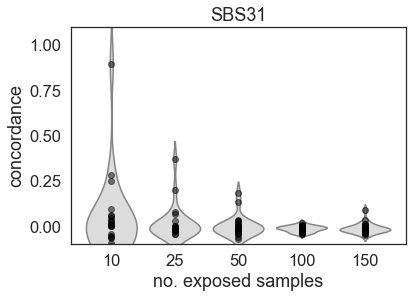

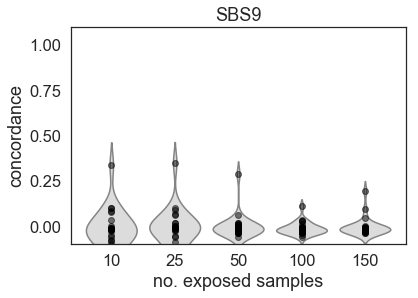

In [386]:
for etiology in synthetic.etiologies:
    scatter_error(etiology, option='concordance')

# Recovering Treatment Dependence of Signatures 

In [67]:
regression_folder = '/home/fmuinos/projects/oriol/treatment_effects/simulations/regression_results/breastlungcolon'
deconstruction_folder = '/workspace/users/fmuinos/treatment_effects/simulations/deconstruction/breastlungcolon'

channel_index = synthetic.channel_index

def plot_lor(etiology, n_treated, replicate):

    index, cosine, twin_signal = signature_recovery(etiology, n_treated, replicate, plot=False)
    
    with open(os.path.join(regression_folder, f'regression_lor.{etiology}.{n_treated}.{replicate}.json'), 'rt') as f:
        merge_res = json.load(f)

    fig, ax = plt.subplots()
    pval_red   = []
    pval_pink  = []
    pval_other = []
    for k in sorted(merge_res, key=lambda v: np.mean(merge_res[v]), reverse=True):
        x, y = [], []
        for lor in merge_res[k]:
            x.append(k)
            y.append(lor)
        pval = np.sum(np.array(y) < 0) / len(y)
        color = 'black'
        if k == str(index[0]):
            color = 'red'
            pval_red.append(pval)
        elif k in list(map(str, index)):
            color = 'pink'
            pval_pink.append(pval)
        else:
            pval_other.append(pval)
            
        ax.scatter(x, y, alpha=0.2, color=color)
        
    ax.set_xlabel('signatures')
    ax.set_ylabel('log odds ratio')
    ax.set_title(f'{etiology}:{n_treated}:{replicate}')
    fig.savefig(f'figures/{etiology}.{n_treated}.logodds_test.png', bbox_inches='tight')
    plt.close(fig)
    return pval_red, pval_pink, pval_other

In [76]:
def plot_all_lor(etiology, n_treated):
    pvals_red = []
    pvals_pink = []
    pvals_other = []
    for replicate in range(25):
        p_red, p_pink, p_other = plot_lor(etiology, n_treated, replicate)
        pvals_red += p_red
        pvals_pink += p_pink
        pvals_other += p_other
    return pvals_red, pvals_pink, pvals_other

def roc_curve_plot(p_red, p_pink, p_other, ax=None):

    y_true = [1]*len(p_red) + [0]*(len(p_pink)+len(p_other))
    y_score = list(map(lambda x: -x, p_red + p_pink + p_other))
    fprs, tprs, thresholds = metrics.roc_curve(y_true, y_score)
    auc = metrics.roc_auc_score(y_true, y_score)
    ax.plot(fprs, tprs)
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), '--')
    ax.set_title(f'Receiver Operating Characteristic\nAUC: {np.round(auc, 2)}')
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')

In [65]:
def roc_plot(etiology, n_treated):
    pvals_red, pvals_pink, pvals_other = plot_all_lor(etiology, n_treated)
    fig, ax = plt.subplots()
    auc = roc_curve_plot(pvals_red, pvals_pink, pvals_other, ax=ax)
    plt.show()

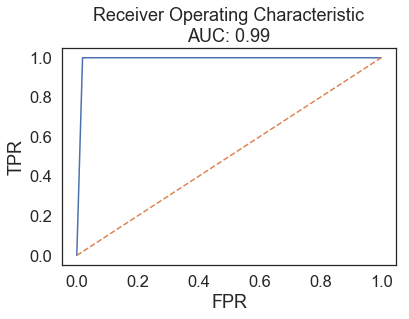

In [77]:
def lor_mean(etiology, n_treated, replicate):

    index, cosine, twin_signal = signature_recovery(etiology, n_treated, replicate, plot=False)

    with open(os.path.join(regression_folder, f'regression_lor.{etiology}.{n_treated}.{replicate}.json'), 'rt') as f:
        merge_res = json.load(f)

    mean_lor, x = [], []
    for k in sorted(merge_res, key=lambda v: np.mean(merge_res[v]), reverse=True):
        if k in list(map(str, index)):
            mean_lor.append(np.mean(merge_res[k]))
            x.append(0)
        else:
            mean_lor.append(np.mean(merge_res[k]))
            x.append(1)

    return x, mean_lor


def plot_lor_mean(etiology):

    fig, ax = plt.subplots(figsize=(10, 3))
    all_x = []
    values = []
    for i, n_treated in enumerate([10, 25, 50, 100, 150]):
        for replicate in range(25):
            x, mean_lor = lor_mean(etiology, n_treated, replicate)
            all_x += list((np.array(x) - 0.5) * (0.2 / 0.5) + i)
            values += list(mean_lor)
    ax.scatter(all_x, values, alpha=0.5, color='black')
    ax.hlines(0, -0.4, 4.4, linestyles='dashed', color='red', alpha=0.5)
    ax.set_ylabel('mean log odds ratio')
    ax.set_title(f'{synthetic.etiologies[etiology]}')
    ax.tick_params(length=0, which='major', pad=65, labelsize=14, axis='x')
    ax.tick_params(length=0, which='minor', pad=5, labelsize=14, rotation=90)
    ax.set_xticks(sum([[i - 0.2, i + 0.2] for i in range(5)], []), minor=True)
    ax.set_xticklabels([synthetic.etiologies[etiology], 'other'] * 5, minor=True)
    ax.set_xticks(range(5), minor=False)
    ax.set_xticklabels(list(map(lambda x: f'{x} exposed', [10, 25, 50, 100, 150])))
    fig.savefig(f'figures/{etiology}.mean_logodds_plot.png', dpi=200, bbox_inches='tight')
    plt.show()
    
    
def plot_lor_significance(etiology):

    fig, ax = plt.subplots(figsize=(10, 3))
    all_x = []
    values = []
    colors = []
    for i, n_treated in enumerate([10, 25, 50, 100, 150]):
        x = []
        pvals_red, pvals_pink, pvals_other = plot_all_lor(etiology, n_treated)
        values += list(map(lambda x: -np.log10(x + 1e-4), pvals_red))
        x += [0] * len(pvals_red)
        
        colors += ['red'] * len(pvals_red)
        values += list(map(lambda x: -np.log10(x + 1e-4), pvals_pink + pvals_other))
        
        x += [1] * len(pvals_pink)
        colors += ['pink'] * len(pvals_pink)
        
        x += [1] * len(pvals_other)
        colors += ['black'] * len(pvals_other)
        
        all_x += list((np.array(x) - 0.5) * (0.2 / 0.5) + i) 
        
    ax.scatter(all_x, values, alpha=0.7, color=colors)
    ax.hlines(3, -0.4, 4.4, linestyles='dashed', color='red', alpha=0.5)
    ax.set_ylabel('-log pvalue')
    ax.set_title(f'{synthetic.etiologies[etiology]}')
    ax.tick_params(length=0, which='major', pad=50, labelsize=14, axis='x')
    ax.tick_params(length=0, which='minor', pad=5, labelsize=14, rotation=90)
    ax.set_xticks(sum([[i - 0.2, i + 0.2] for i in range(5)], []), minor=True)
    ax.set_xticklabels(['true', 'false'] * 5, minor=True)
    ax.set_xticks(range(5), minor=False)
    ax.set_xticklabels(list(map(lambda x: f'{x} exposed', [10, 25, 50, 100, 150])))
    ax.set_yticks([0, 1, 2, 3, 4])
    ax.set_yticklabels([0, 1, 2, 3, '$\infty$'])
    fig.savefig(f'figures/{etiology}.significance_plot.png', dpi=200, bbox_inches='tight')
    plt.show()

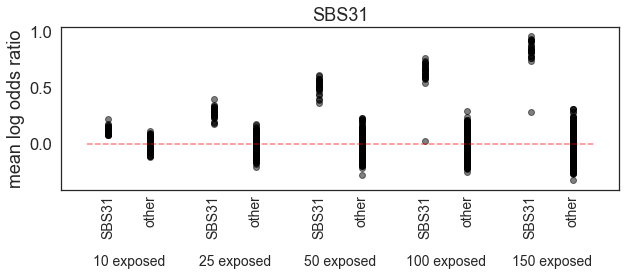

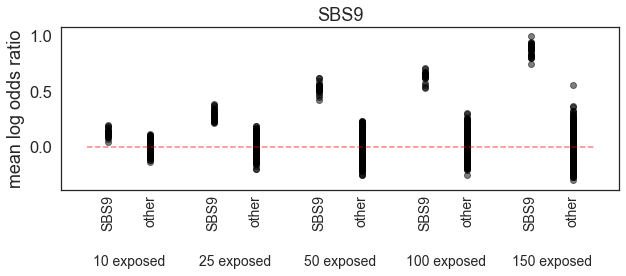

In [72]:
for etiology in synthetic.etiologies:
    plot_lor_mean(etiology)

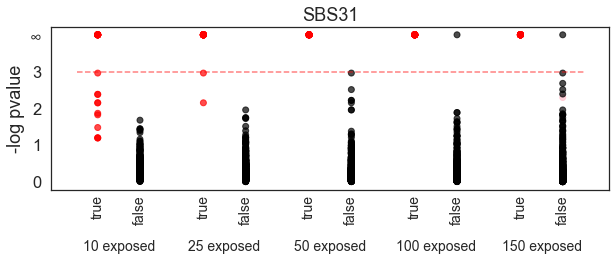

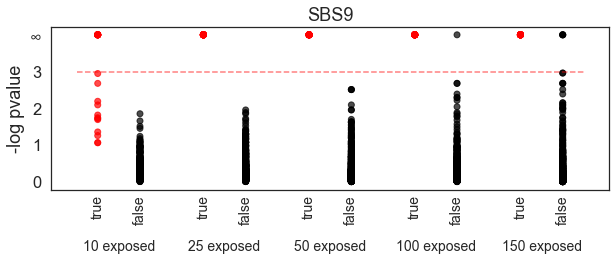

In [78]:
# TODO: matrix with AUCs for each signature and n_treated

for etiology in synthetic.etiologies:
    plot_lor_significance(etiology)

# ... now with fold-change

In [117]:
regression_folder = '/home/fmuinos/projects/oriol/treatment_effects/simulations/regression_results'

channel_index = synthetic.channel_index


def fold_change(etiology, n_treated, replicate):

    index, cosine, twin_signal = signature_recovery(etiology, n_treated, replicate, plot=False)
    df = pd.read_csv(os.path.join(regression_folder, f'regression_summary.{etiology}.{n_treated}.{replicate}.tsv'), sep='\t')
    x, y = [], []
    x.append(0)
    y.append(df.loc[index[0], 'effect_size'])
    x += [1 for i in df.loc[:, 'signature'] if i not in [index[0]]]
    y += list(df[~df.signature.isin([index[0]])]['effect_size'].values)
    
    return x, y


def plot_fold_change(etiology):

    fig, ax = plt.subplots(figsize=(10, 3))
    ax.tick_params(length=0, which='major', pad=100, labelsize=14, axis='x')
    ax.tick_params(length=0, which='minor', pad=5, labelsize=14, rotation=90)

    ax.set_xticks(sum([[i - 0.2, i + 0.2] for i in range(5)], []), minor=True)
    ax.set_xticklabels([etiology, 'other'] * 5, minor=True)
    ax.set_xticks(range(5), minor=False)
    ax.set_xticklabels(list(map(lambda x: f'treated={x}', [10, 25, 50, 100, 150])))
    
    for i, n_treated in enumerate([10, 25, 50, 100, 150]):
        for replicate in range(1, 11):
            x, y = fold_change(etiology, n_treated, replicate)
            ax.scatter((np.array(x) - 0.5) * (0.2 / 0.5) + i, y, alpha=0.5, color='green')
    ax.hlines(2, -0.4, 4.4, linestyles='dashed', color='red', alpha=0.5)
    ax.set_ylabel('fold change')
    ax.set_title(f'{etiology}')
    fig.savefig(f'figures/{etiology}.fold_change_plot.svg', dpi=200, bbox_inches='tight')
    plt.show()

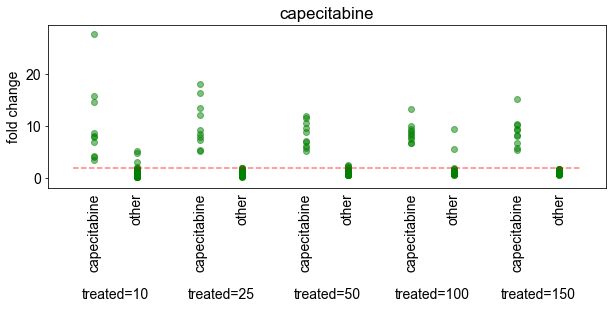

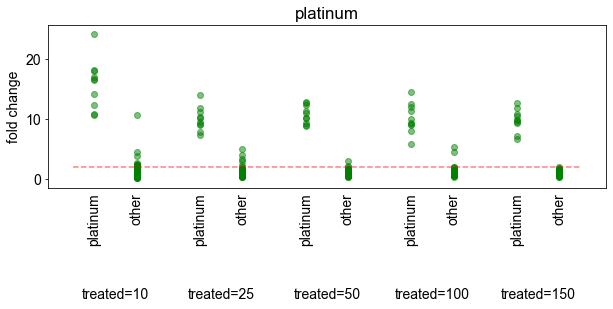

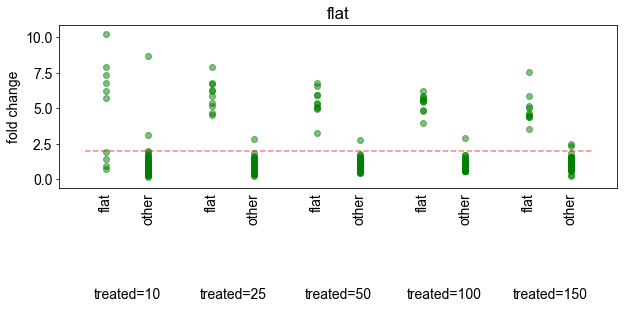

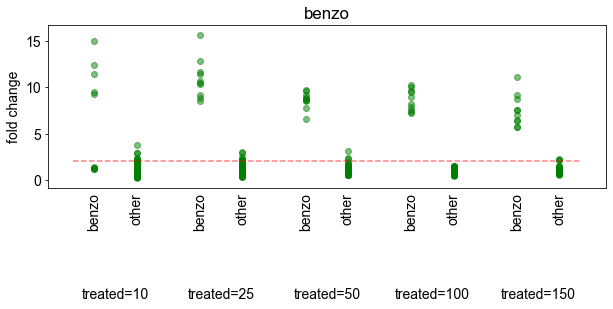

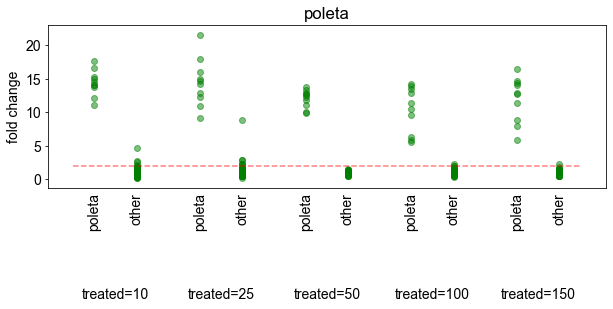

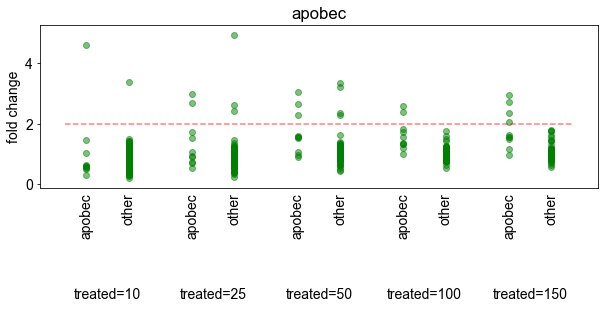

In [118]:
for etiology in synthetic.etiologies:
    plot_fold_change(etiology)

# Volcano Plot

In [81]:
regression_folder = '/home/fmuinos/projects/oriol/treatment_effects/simulations/regression_results/breastlungcolon'
deconstruction_folder = '/workspace/users/fmuinos/treatment_effects/simulations/deconstruction/breastlungcolon'

def get_effects_pvals(etiology, n_treated, replicate):

    index, cosine, twin_signal = signature_recovery(etiology, n_treated, replicate, plot=False)
    with open(os.path.join(regression_folder, f'regression_lor.{etiology}.{n_treated}.{replicate}.json'), 'rt') as f:
        merge_res = json.load(f)
    summary = pd.read_csv(os.path.join(regression_folder, f'regression_summary.{etiology}.{n_treated}.{replicate}.tsv'), sep='\t')
    
    effects, pvals, colors = [], [], []
    for k in sorted(merge_res, key=lambda v: np.mean(merge_res[v]), reverse=True):
        y = []
        for lor in merge_res[k]:
            y.append(lor)
        pval = np.sum(np.array(y) < 0) / len(y)
        pvals.append(pval)
        if int(k) == index[0]:
            colors.append('red')
        else:
            colors.append('black')
        effects.append(summary.loc[int(k), 'effect_size'])
        
    return effects, pvals, colors

    
def plot_volcano(etiology):

    fig, ax = plt.subplots(figsize=(6, 6))
    x, y, c = [], [], []
    for n_treated in [10, 25, 50, 100, 150]:
        for replicate in range(25):
            effects, pvals, colors = get_effects_pvals(etiology, n_treated, replicate)
            x += effects
            y += list(map(lambda x: -np.log10(x + 1e-4), pvals))
            c += colors
    ax.scatter(x, y, alpha=0.5, color=c)
    ax.hlines(3, -0.1, np.max(x), linestyles='dashed', color='red', alpha=0.5)
    ax.vlines(2, -0.1, np.max(y), linestyles='dashed', color='red', alpha=0.5)
    ax.set_yticks([0, 1, 2, 3, 4])
    ax.set_yticklabels([0, 1, 2, 3, '$\infty$'])    
    ax.set_ylabel('$-\log_{10}$ p-value')
    ax.set_xlabel('effect size (fold change)')
    ax.set_title(synthetic.etiologies[etiology])
    fig.savefig(f'figures/{etiology}.volcano.png', dpi=200, bbox_inches='tight')
    plt.show()

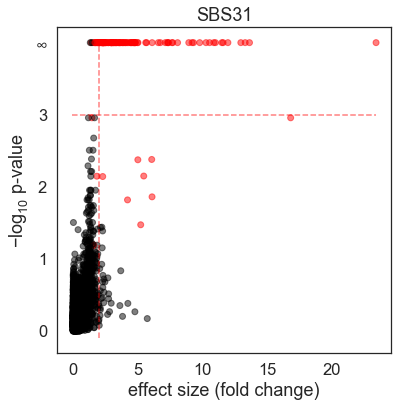

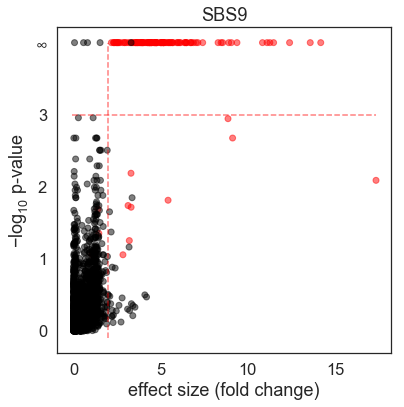

In [82]:
for etiology in synthetic.etiologies:
    plot_volcano(etiology)

# %%% Breast-Lung-Colorectal %%%

# Recovery of synthetic signatures

In [374]:
deconstruction_folder = '/workspace/users/fmuinos/treatment_effects/simulations/deconstruction/'

channel_index = synthetic.channel_index

def signature_recovery(etiology, n_treated, replicate, plot=False):
    
    twin_signals = False
    case = f'{etiology}.{n_treated}.{replicate}.catalogue.tsv'
    df = pd.read_csv(os.path.join(deconstruction_folder, f'{case}/{case}.processes.tsv'), sep='\t')
    cosines = []
    for col in df.columns:
        reference = signatures[synthetic.etiologies[etiology]].values
        profile = df[col].values 
        cosine = metrics.pairwise.cosine_similarity([reference], [profile])[0][0]
        profile_dict = dict(zip(channel_index, profile))
        cosines.append(cosine)
    similar = [c for c in cosines if c > 0.8]
    if len(similar) > 1:
        twin_signals = True
    cosine = max(cosines)
    index = [np.argmax(cosines)]
    if len(similar) > 1:
        index += list(np.argsort(cosines)[::-1][1: len(similar)])
    if plot:
        fig, ax = plt.subplots(figsize=(20, 5))
        plot_signature(profile_dict, title=f'{etiology}:{n_treated}:{np.round(cosine, 3)}', ax=ax)
        plt.show()
    return index, cosine, twin_signals

In [404]:
for replicate in range(10):
    index, cosine, twin_signals = signature_recovery('capecitabine', 100, replicate + 1)

In [368]:
def scatter_cosine(etiology):
    
    fig, ax = plt.subplots()
    major_labels = [10, 25, 50, 100, 150]  # representing n_treated

    # scatter plot
    cosines = []
    x = []
    twin_signals = []
    for i, n_treated in enumerate(major_labels):
        cos = list(map(lambda x: signature_recovery(etiology, n_treated, x + 1), range(10)))
        cosines += list(zip(*cos))[1]
        twin_signals += list(zip(*cos))[2]
        x += [i] * len(cos)
    colors = ['red' if s else 'black' for s in twin_signals]
    seaborn.violinplot(x, cosines, alpha=0.3, color='#DCDCDC', scale='count', inner=None, ax=ax)
    ax.scatter(x, cosines, color=colors, alpha=0.6)
    
    # plot layout
    major_ticks = np.arange(5)
    ax.set_ylim(0.7, 1.03)
    ax.set_xticks(ticks=major_ticks)
    ax.set_xticklabels(labels=map(str, major_labels))
    ax.set_xlabel('no. samples exposed')
    ax.set_ylabel('cosine similarity')
    ax.set_title(synthetic.etiologies[etiology])
    
    fig.savefig(f'figures/{etiology}.cosine.png', dpi=200, bbox_inches='tight')
    plt.show()

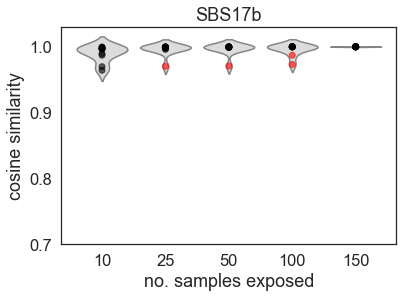

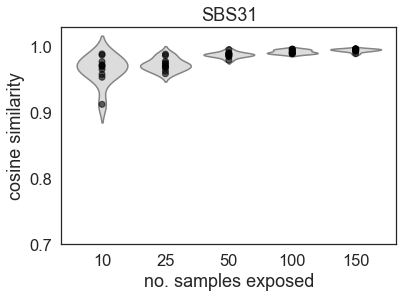

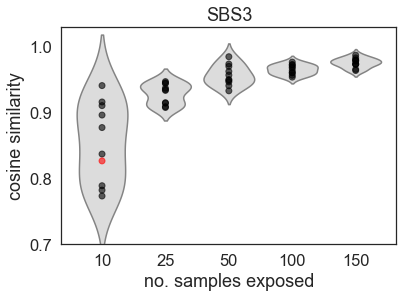

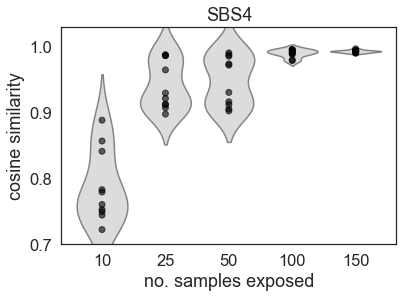

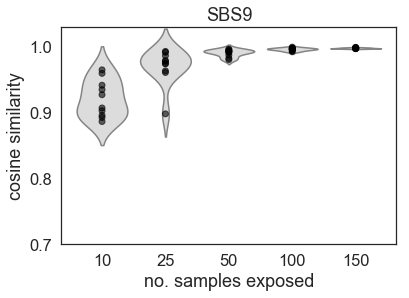

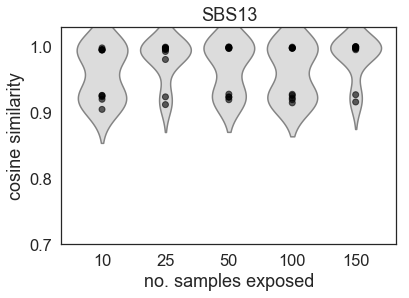

In [362]:
for etiology in synthetic.etiologies:
    scatter_cosine(etiology)

# Recovery of exposure

In [337]:
catalogue_folder = '/home/fmuinos/projects/oriol/treatment_effects/simulations/catalogues/breastlungcolon'
deconstruction_folder = '/workspace/users/fmuinos/treatment_effects/simulations/deconstruction/breastlungcolon'

channel_index = synthetic.channel_index

def exposure_recovery(etiology, n_treated, replicate):
    
    # load synthetic burden
    burden_fn = f'{etiology}.{n_treated}.{replicate}.burden.tsv'
    with open(os.path.join(catalogue_folder, burden_fn), 'rt') as f:
        burden = json.load(f)
    burden = np.array(burden[:n_treated])
    
    # load exposures
    case = f'{etiology}.{n_treated}.{replicate}.catalogue.tsv'
    exposure = pd.read_csv(os.path.join(deconstruction_folder, f'{case}/{case}.exposures.tsv'), sep='\t')
    index, cosine, twin_signals = signature_recovery(etiology, n_treated, replicate)
    exposure = exposure.iloc[index[0], :n_treated].values
    return burden, exposure, twin_signals

def exposure_recovery_nontreated(etiology, n_treated, replicate):
    
    # load exposures
    case = f'{etiology}.{n_treated}.{replicate}.catalogue.tsv'
    exposure = pd.read_csv(os.path.join(deconstruction_folder, f'{case}/{case}.exposures.tsv'), sep='\t')
    index, cosine, twin_signals = signature_recovery(etiology, n_treated, replicate)
    exposure = exposure.iloc[index[0], n_treated + 1:].values
    return exposure, twin_signals

In [406]:
def exposure_recovery_plot(etiology, n_treated):

    fig, ax = plt.subplots()    
    
    for replicate in range(10):
        burden, exposure, twin_signals = exposure_recovery(etiology, n_treated, replicate + 1)
        ax.scatter(list(burden), list(exposure), alpha=0.3, color='black')
   
    ax.set_xlabel('synthetic')
    ax.set_ylabel('reconstructed')
    ax.set_title(f'Exposure Recovery\n{synthetic.etiologies[etiology]}: {n_treated} samples exposed')
    ax.set_ylim(0, 5000)
    ax.set_xlim(0, 5000)
    x = np.linspace(0, 5000, 5000)
    diagonal = ax.plot(x, x, '--', color='red', alpha=0.5)
    fig.savefig(f'figures/exposure_recovery.{etiology}.{n_treated}.png', dpi=200, bbox_inches='tight')

100%|██████████| 6/6 [00:03<00:00,  1.68it/s]


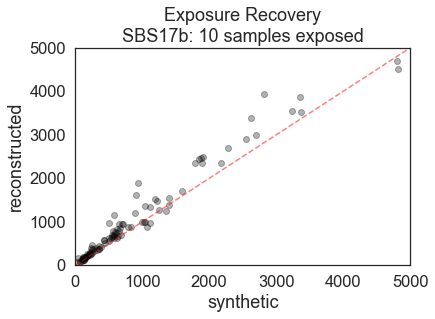

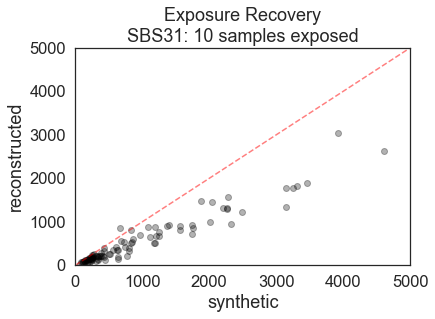

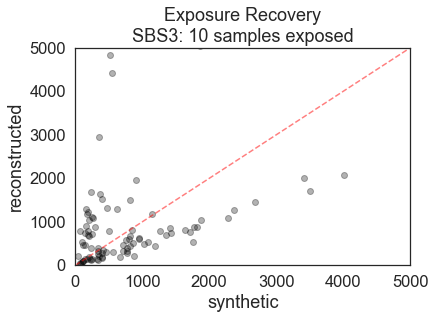

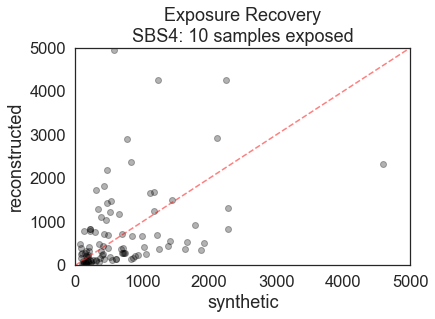

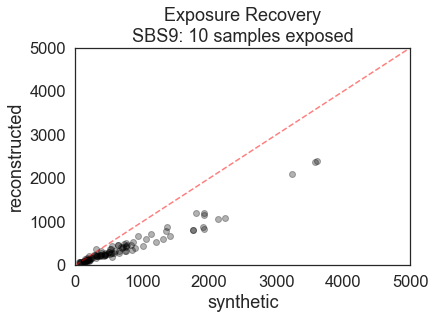

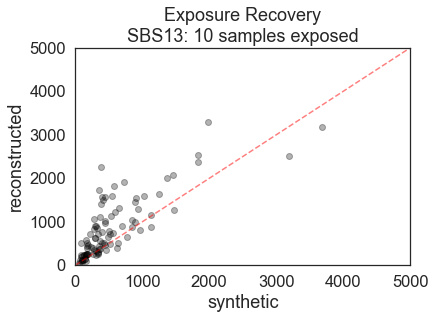

In [407]:
for etiology in tqdm.tqdm(synthetic.etiologies):
    for n_treated in [10]:
        exposure_recovery_plot(etiology, n_treated)

In [344]:
catalogue_folder = '/home/fmuinos/projects/oriol/treatment_effects/simulations/catalogues'
deconstruction_folder = '/workspace/users/fmuinos/treatment_effects/simulations/deconstruction'

def exposure_recovery_nontreated_plot(etiology):

    fig, ax = plt.subplots()    
    major_labels = [10, 25, 50, 100, 150]  # representing n_treated
    
    x = []
    values = []
    colors = []
    
    for i, n_treated in enumerate(major_labels):
        for replicate in range(10):
            
            
            # load synthetic burden
            burden_fn = f'{etiology}.{n_treated}.{replicate+1}.burden.tsv'
            with open(os.path.join(catalogue_folder, burden_fn), 'rt') as f:
                burden = json.load(f)
            burden = np.array(burden[:n_treated])

            exposure, twin_signals = exposure_recovery_nontreated(etiology, n_treated, replicate+1)
            x += [i]
            values.append(np.mean(exposure) / np.mean(burden))
            if twin_signals:
                colors.append('red') 
            else: 
                colors.append('black')

    seaborn.violinplot(x, values, alpha=0.3, color='#DCDCDC', scale='count', inner=None, ax=ax)
    ax.scatter(x, values, alpha=0.3, color=colors)
    
    major_ticks = np.arange(5)
    ax.set_xticks(ticks=major_ticks)
    ax.set_xticklabels(labels=map(str, major_labels))
    ax.set_title(synthetic.etiologies[etiology])
    ax.set_ylim(-0.1, 0.25)
    ax.set_xlabel('no. exposed samples')
    ax.set_ylabel('average exposure over\naverage injected burden')
    fig.savefig(f'figures/breast.exposure_recovery_notreated.{etiology}.svg', dpi=200, bbox_inches='tight')

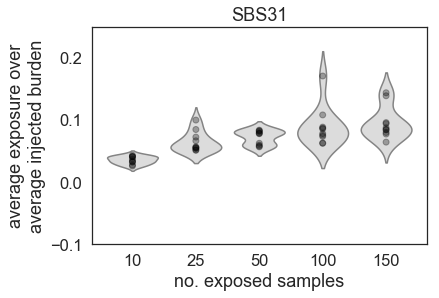

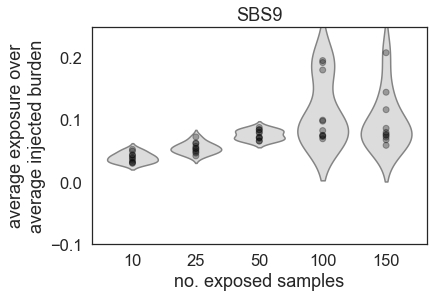

In [345]:
for etiology in synthetic.etiologies:
    exposure_recovery_nontreated_plot(etiology)

In [80]:
def concordance_correlation_coefficient(y_true, y_pred, sample_weight=None, multioutput='uniform_average'):
    
    """Concordance correlation coefficient.
    The concordance correlation coefficient is a measure of inter-rater agreement.
    It measures the deviation of the relationship between predicted and true values
    from the 45 degree angle.
    Read more: https://en.wikipedia.org/wiki/Concordance_correlation_coefficient
    Original paper: Lawrence, I., and Kuei Lin. "A concordance correlation coefficient to evaluate reproducibility." Biometrics (1989): 255-268.  
    Parameters
    ----------
    y_true : array-like of shape = (n_samples) or (n_samples, n_outputs)
        Ground truth (correct) target values.
    y_pred : array-like of shape = (n_samples) or (n_samples, n_outputs)
        Estimated target values.
    Returns
    -------
    loss : A float in the range [-1,1]. A value of 1 indicates perfect agreement
    between the true and the predicted values.
    Examples
    --------
    >>> from sklearn.metrics import concordance_correlation_coefficient
    >>> y_true = [3, -0.5, 2, 7]
    >>> y_pred = [2.5, 0.0, 2, 8]
    >>> concordance_correlation_coefficient(y_true, y_pred)
    0.97678916827853024
    """
    cor=np.corrcoef(y_true,y_pred)[0][1]
    
    mean_true=np.mean(y_true)
    mean_pred=np.mean(y_pred)
    
    var_true=np.var(y_true)
    var_pred=np.var(y_pred)
    
    sd_true=np.std(y_true)
    sd_pred=np.std(y_pred)
    
    numerator=2*cor*sd_true*sd_pred
    
    denominator=var_true+var_pred+(mean_true-mean_pred)**2

    return numerator/denominator


In [83]:
def scatter_error(etiology, option='error'):
    """
    option: 'error', 'correlation', 'concordance'
    """
    
    fig, ax = plt.subplots()
    
    # plot layout
    major_labels = [10, 25, 50, 100, 150]  # representing n_treated
    if option == 'error':
        ax.set_ylabel('mean relative error (%)')
    elif option == 'correlation':
        ax.set_ylabel('correlation')
    elif option == 'deviance':
        ax.set_ylabel('ratio deviant samples')
    elif option == 'concordance':
        ax.set_ylabel('concordance')
    # scatter plot
    values = []
    x = []
    colors = []
    for i, n_treated in enumerate(major_labels):
        for replicate in range(10):
            burden, exposure, twin_signals = exposure_recovery(etiology, n_treated, replicate + 1)
            if option == 'error':
                value = np.mean(np.abs((burden - exposure) / burden))
            elif option == 'correlation':
                value = scipy.stats.pearsonr(burden, exposure)[0]
            elif option == 'deviance':
                deviance = np.abs((burden - exposure) / burden)
                value = np.sum(deviance > 0.15) / len(deviance)
            elif option == 'concordance':
                value = concordance_correlation_coefficient(exposure, burden)
            if twin_signals: 
                colors.append('red') 
            else: 
                colors.append('black')
            x.append(i)
            values.append(value)
    seaborn.violinplot(x, values, alpha=0.3, color='#DCDCDC', scale='count', inner=None, ax=ax)
    ax.scatter(x, values, color=colors, alpha=0.5)
    major_ticks = np.arange(5)
    ax.set_ylim(-0.1, 1.1)
    if option == 'error':
        ax.set_yticks([0, 1, 2, 3])
        ax.set_yticklabels(labels=map(str, [0, 100, 200, 300]))
    ax.set_xticks(ticks=major_ticks)
    ax.set_xticklabels(labels=map(str, major_labels))
    ax.set_title(synthetic.etiologies[etiology])
    ax.set_xlabel('no. exposed samples')
    fig.savefig(f'figures/{etiology}.exposure_{option}.png', dpi=200, bbox_inches='tight')
    plt.show()

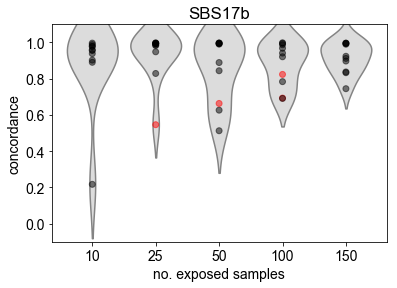

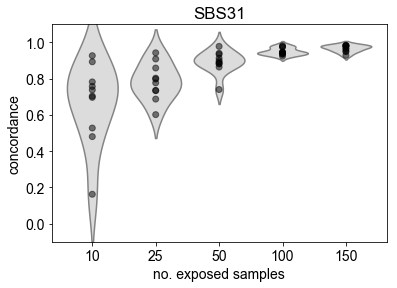

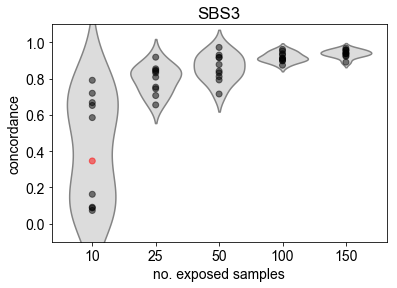

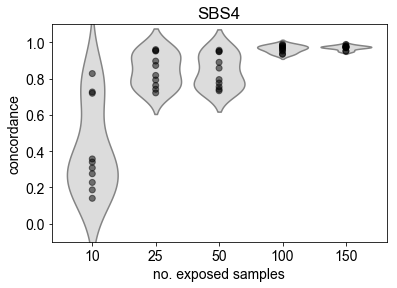

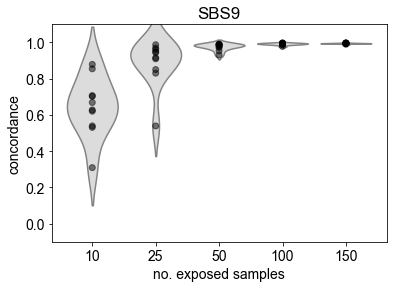

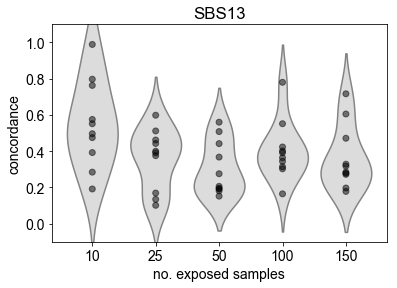

In [84]:
for etiology in synthetic.etiologies:
    scatter_error(etiology, option='concordance')

# Recovering Treatment Dependence of Signatures 

In [338]:
regression_folder = '/home/fmuinos/projects/oriol/treatment_effects/simulations/regression_results/breastlungcolon'

channel_index = synthetic.channel_index

def plot_lor(etiology, n_treated, replicate):

    index, cosine, twin_signal = signature_recovery(etiology, n_treated, replicate, plot=False)
    
    with open(os.path.join(regression_folder, f'regression_lor.{etiology}.{n_treated}.{replicate}.json'), 'rt') as f:
        merge_res = json.load(f)

    fig, ax = plt.subplots()
    pval_red   = []
    pval_pink  = []
    pval_other = []
    for k in sorted(merge_res, key=lambda v: np.mean(merge_res[v]), reverse=True):
        x, y = [], []
        for lor in merge_res[k]:
            x.append(k)
            y.append(lor)
        pval = np.sum(np.array(y) < 0) / len(y)
        color = 'black'
        if k == str(index[0]):
            color = 'red'
            pval_red.append(pval)
        elif k in list(map(str, index)):
            color = 'pink'
            pval_pink.append(pval)
        else:
            pval_other.append(pval)
            
        ax.scatter(x, y, alpha=0.2, color=color)
        
    ax.set_xlabel('signatures')
    ax.set_ylabel('log odds ratio')
    ax.set_title(f'{etiology}:{n_treated}:{replicate}')
    fig.savefig(f'figures/breastlungcolon.{etiology}.{n_treated}.logodds_test.png', bbox_inches='tight')
    plt.close(fig)
    return pval_red, pval_pink, pval_other

def plot_all_lor(etiology, n_treated):
    pvals_red = []
    pvals_pink = []
    pvals_other = []
    for replicate in range(10):
        p_red, p_pink, p_other = plot_lor(etiology, n_treated, replicate + 1)
        pvals_red += p_red
        pvals_pink += p_pink
        pvals_other += p_other
    return pvals_red, pvals_pink, pvals_other

def roc_curve_plot(p_red, p_pink, p_other, ax=None):

    y_true = [1]*len(p_red) + [0]*(len(p_pink)+len(p_other))
    y_score = list(map(lambda x: -x, p_red + p_pink + p_other))
    fprs, tprs, thresholds = metrics.roc_curve(y_true, y_score)
    auc = metrics.roc_auc_score(y_true, y_score)
    ax.plot(fprs, tprs)
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), '--')
    ax.set_title(f'Receiver Operating Characteristic\nAUC: {np.round(auc, 2)}')
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')

def roc_plot(etiology, n_treated):
    pvals_red, pvals_pink, pvals_other = plot_all_lor(etiology, n_treated)
    fig, ax = plt.subplots()
    auc = roc_curve_plot(pvals_red, pvals_pink, pvals_other, ax=ax)
    plt.show()

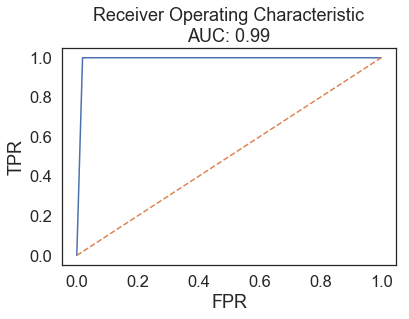

In [341]:
def lor_mean(etiology, n_treated, replicate):

    index, cosine, twin_signal = signature_recovery(etiology, n_treated, replicate, plot=False)

    with open(os.path.join(regression_folder, f'regression_lor.{etiology}.{n_treated}.{replicate}.json'), 'rt') as f:
        merge_res = json.load(f)

    mean_lor, x = [], []
    for k in sorted(merge_res, key=lambda v: np.mean(merge_res[v]), reverse=True):
        if k in list(map(str, index)):
            mean_lor.append(np.mean(merge_res[k]))
            x.append(0)
        else:
            mean_lor.append(np.mean(merge_res[k]))
            x.append(1)

    return x, mean_lor


def plot_lor_mean(etiology):

    fig, ax = plt.subplots(figsize=(10, 3))
    all_x = []
    values = []
    for i, n_treated in enumerate([10, 25, 50, 100, 150]):
        for replicate in range(1, 11):
            x, mean_lor = lor_mean(etiology, n_treated, replicate)
            all_x += list((np.array(x) - 0.5) * (0.2 / 0.5) + i)
            values += list(mean_lor)
    ax.scatter(all_x, values, alpha=0.5, color='black')
    ax.hlines(0, -0.4, 4.4, linestyles='dashed', color='red', alpha=0.5)
    ax.set_ylabel('mean log odds ratio')
    ax.set_title(f'{synthetic.etiologies[etiology]}')
    ax.tick_params(length=0, which='major', pad=65, labelsize=14, axis='x')
    ax.tick_params(length=0, which='minor', pad=5, labelsize=14, rotation=90)
    ax.set_xticks(sum([[i - 0.2, i + 0.2] for i in range(5)], []), minor=True)
    ax.set_xticklabels([synthetic.etiologies[etiology], 'other'] * 5, minor=True)
    ax.set_xticks(range(5), minor=False)
    ax.set_xticklabels(list(map(lambda x: f'{x} exposed', [10, 25, 50, 100, 150])))
    fig.savefig(f'figures/breastlungcolon.{etiology}.mean_logodds_plot.png', dpi=200, bbox_inches='tight')
    plt.show()
    
    
def plot_lor_significance(etiology):

    fig, ax = plt.subplots(figsize=(10, 3))
    all_x = []
    values = []
    colors = []
    for i, n_treated in enumerate([10, 25, 50, 100, 150]):
        x = []
        pvals_red, pvals_pink, pvals_other = plot_all_lor(etiology, n_treated)
        values += list(map(lambda x: -np.log10(x + 1e-4), pvals_red))
        x += [0] * len(pvals_red)
        
        colors += ['red'] * len(pvals_red)
        values += list(map(lambda x: -np.log10(x + 1e-4), pvals_pink + pvals_other))
        
        x += [1] * len(pvals_pink)
        colors += ['pink'] * len(pvals_pink)
        
        x += [1] * len(pvals_other)
        colors += ['black'] * len(pvals_other)
        
        all_x += list((np.array(x) - 0.5) * (0.2 / 0.5) + i) 
        
    ax.scatter(all_x, values, alpha=0.7, color=colors)
    ax.hlines(3, -0.4, 4.4, linestyles='dashed', color='red', alpha=0.5)
    ax.set_ylabel('-log pvalue')
    ax.set_title(f'{synthetic.etiologies[etiology]}')
    ax.tick_params(length=0, which='major', pad=50, labelsize=14, axis='x')
    ax.tick_params(length=0, which='minor', pad=5, labelsize=14, rotation=90)
    ax.set_xticks(sum([[i - 0.2, i + 0.2] for i in range(5)], []), minor=True)
    ax.set_xticklabels(['true', 'false'] * 5, minor=True)
    ax.set_xticks(range(5), minor=False)
    ax.set_xticklabels(list(map(lambda x: f'{x} exposed', [10, 25, 50, 100, 150])))
    ax.set_yticks([0, 1, 2, 3, 4])
    ax.set_yticklabels([0, 1, 2, 3, '$\infty$'])
    fig.savefig(f'figures/breastlungcolon.{etiology}.significance_plot.png', dpi=200, bbox_inches='tight')
    plt.show()

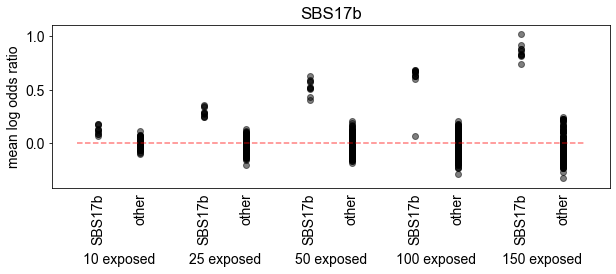

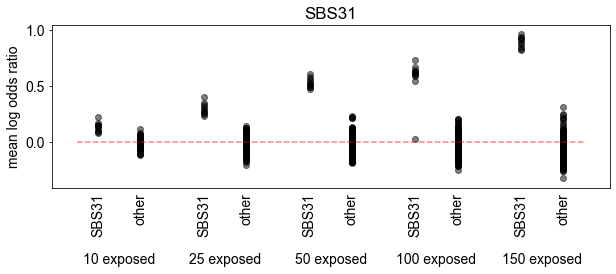

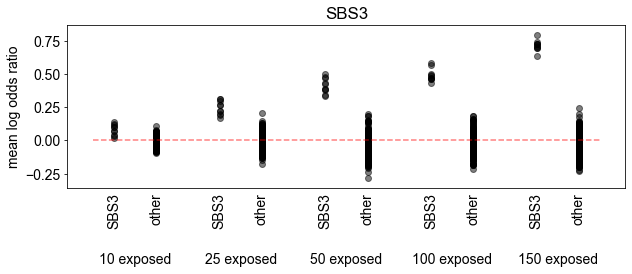

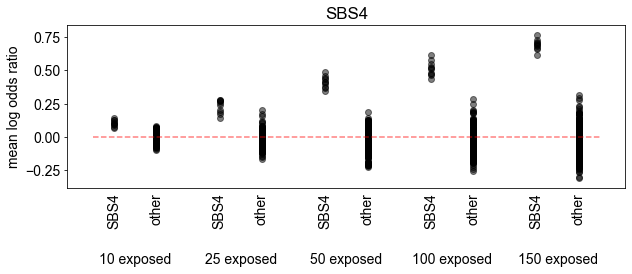

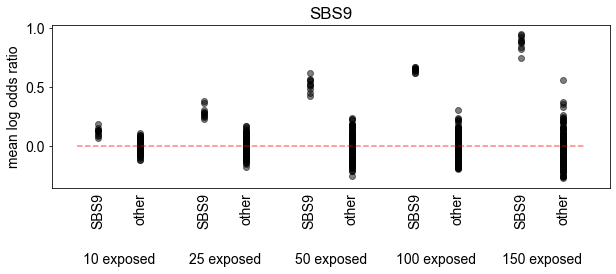

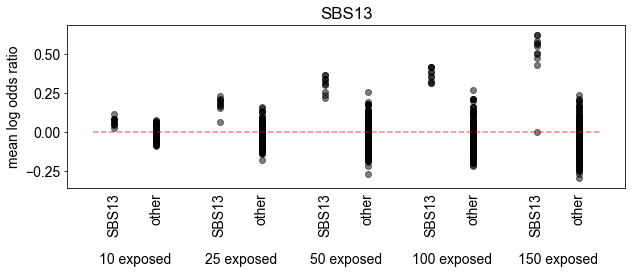

In [342]:
for etiology in synthetic.etiologies:
    plot_lor_mean(etiology)

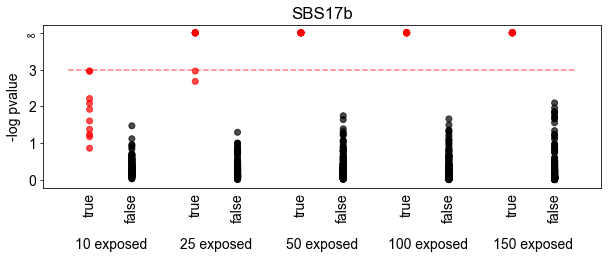

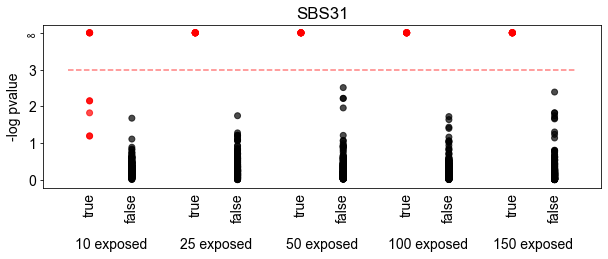

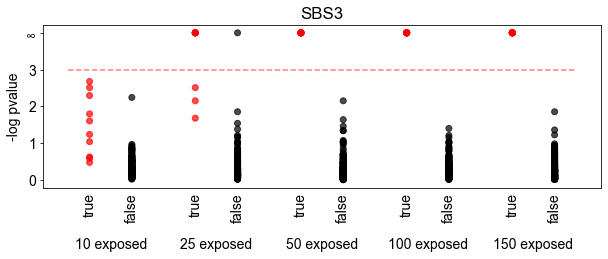

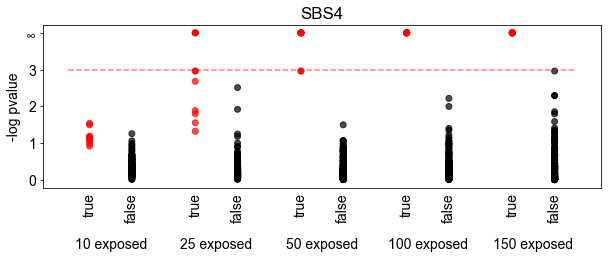

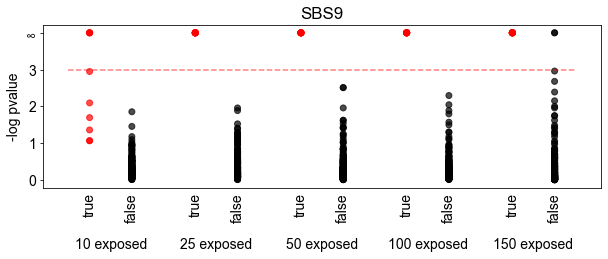

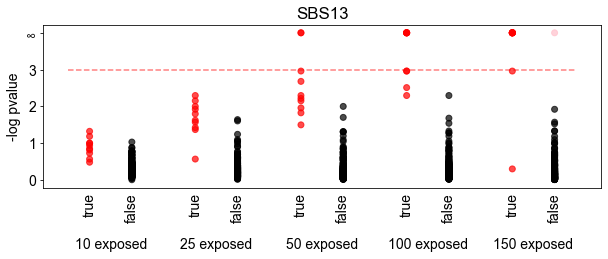

In [343]:
# TODO: matrix with AUCs for each signature and n_treated

for etiology in synthetic.etiologies:
    plot_lor_significance(etiology)

# ... now with fold-change

In [344]:
regression_folder = '/home/fmuinos/projects/oriol/treatment_effects/simulations/regression_results/breastlungcolon'

channel_index = synthetic.channel_index


def fold_change(etiology, n_treated, replicate):

    index, cosine, twin_signal = signature_recovery(etiology, n_treated, replicate, plot=False)
    df = pd.read_csv(os.path.join(regression_folder, f'regression_summary.{etiology}.{n_treated}.{replicate}.tsv'), sep='\t')
    x, y = [], []
    x.append(0)
    y.append(df.loc[index[0], 'effect_size'])
    x += [1 for i in df.loc[:, 'signature'] if i not in [index[0]]]
    y += list(df[~df.signature.isin([index[0]])]['effect_size'].values)
    
    return x, y


def plot_fold_change(etiology):

    fig, ax = plt.subplots(figsize=(10, 3))
    ax.tick_params(length=0, which='major', pad=100, labelsize=14, axis='x')
    ax.tick_params(length=0, which='minor', pad=5, labelsize=14, rotation=90)

    ax.set_xticks(sum([[i - 0.2, i + 0.2] for i in range(5)], []), minor=True)
    ax.set_xticklabels([etiology, 'other'] * 5, minor=True)
    ax.set_xticks(range(5), minor=False)
    ax.set_xticklabels(list(map(lambda x: f'treated={x}', [10, 25, 50, 100, 150])))
    
    for i, n_treated in enumerate([10, 25, 50, 100, 150]):
        for replicate in range(1, 11):
            x, y = fold_change(etiology, n_treated, replicate)
            ax.scatter((np.array(x) - 0.5) * (0.2 / 0.5) + i, y, alpha=0.5, color='green')
    ax.hlines(2, -0.4, 4.4, linestyles='dashed', color='red', alpha=0.5)
    ax.set_ylabel('fold change')
    ax.set_title(f'{etiology}')
    fig.savefig(f'figures/{etiology}.fold_change_plot.svg', dpi=200, bbox_inches='tight')
    plt.show()

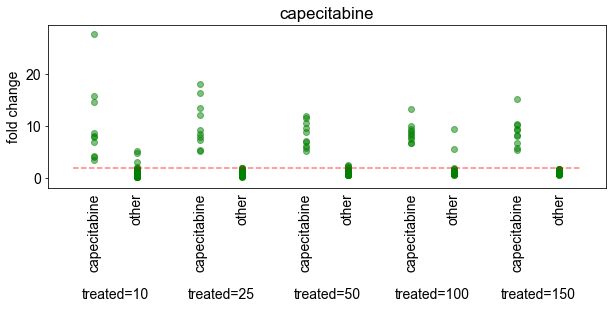

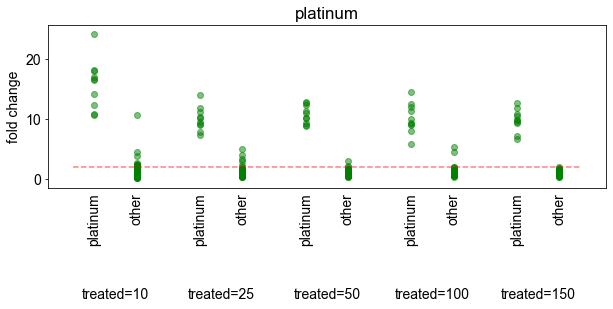

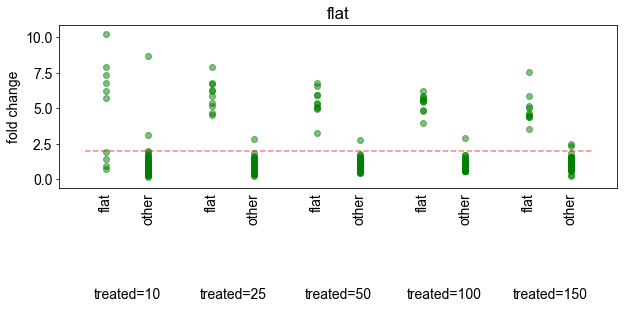

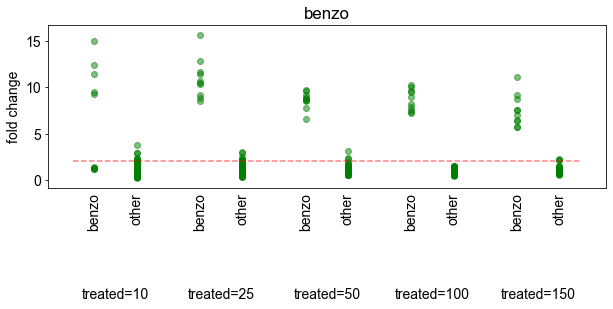

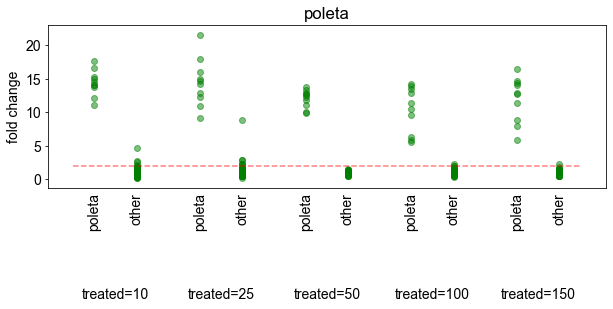

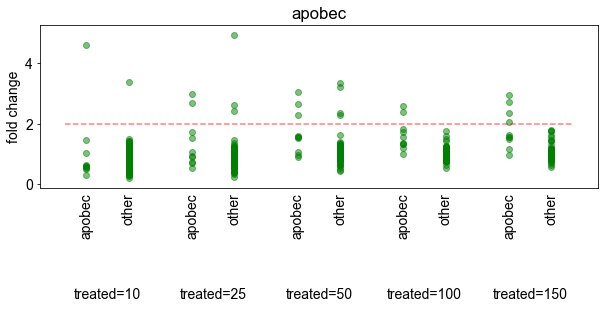

In [118]:
for etiology in synthetic.etiologies:
    plot_fold_change(etiology)

# Volcano Plot

In [345]:
def get_effects_pvals(etiology, n_treated, replicate):

    index, cosine, twin_signal = signature_recovery(etiology, n_treated, replicate, plot=False)
    with open(os.path.join(regression_folder, f'regression_lor.{etiology}.{n_treated}.{replicate}.json'), 'rt') as f:
        merge_res = json.load(f)
    summary = pd.read_csv(os.path.join(regression_folder, f'regression_summary.{etiology}.{n_treated}.{replicate}.tsv'), sep='\t')
    
    effects, pvals, colors = [], [], []
    for k in sorted(merge_res, key=lambda v: np.mean(merge_res[v]), reverse=True):
        y = []
        for lor in merge_res[k]:
            y.append(lor)
        pval = np.sum(np.array(y) < 0) / len(y)
        pvals.append(pval)
        if int(k) == index[0]:
            colors.append('red')
        else:
            colors.append('black')
        effects.append(summary.loc[int(k), 'effect_size'])
        
    return effects, pvals, colors

    
def plot_volcano(etiology):

    fig, ax = plt.subplots(figsize=(6, 6))
    x, y, c = [], [], []
    for n_treated in [10, 25, 50, 100, 150]:
        for replicate in range(10):
            effects, pvals, colors = get_effects_pvals(etiology, n_treated, replicate + 1)
            x += effects
            y += list(map(lambda x: -np.log10(x + 1e-4), pvals))
            c += colors
    ax.scatter(x, y, alpha=0.5, color=c)
    ax.hlines(3, -0.1, np.max(x), linestyles='dashed', color='red', alpha=0.5)
    ax.vlines(2, -0.1, np.max(y), linestyles='dashed', color='red', alpha=0.5)
    ax.set_yticks([0, 1, 2, 3, 4])
    ax.set_yticklabels([0, 1, 2, 3, '$\infty$'])    
    ax.set_ylabel('$-\log_{10}$ p-value')
    ax.set_xlabel('effect size (fold change)')
    ax.set_title(synthetic.etiologies[etiology])
    fig.savefig(f'figures/breastlungcolon.{etiology}.volcano.png', dpi=200, bbox_inches='tight')
    plt.show()

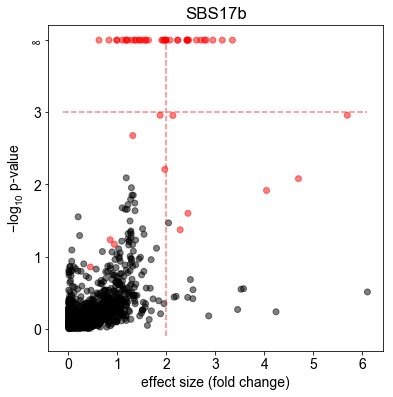

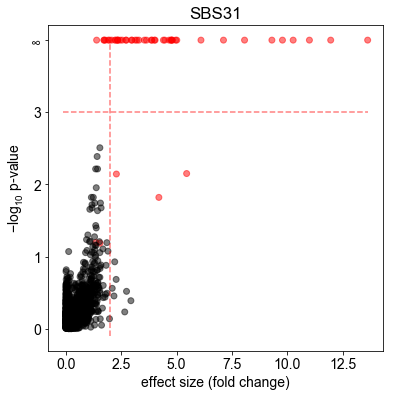

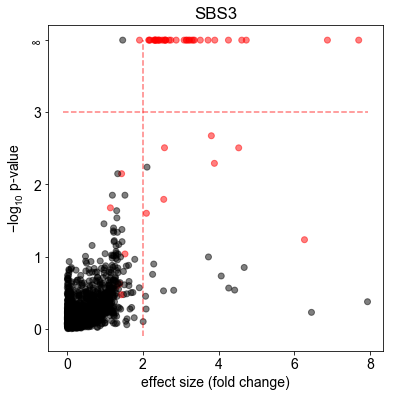

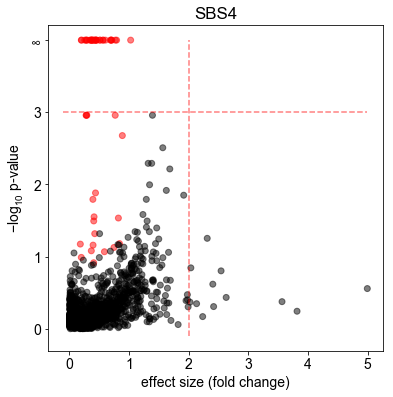

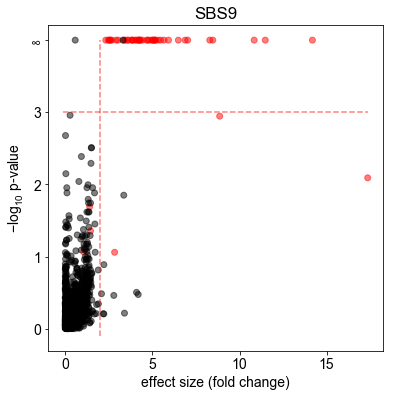

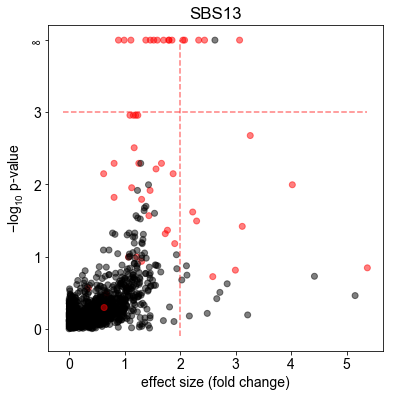

In [346]:
for etiology in synthetic.etiologies:
    plot_volcano(etiology)

# Shuffled treatments!

# Recovering Treatment Dependencies of Signatures 

In [350]:
regression_folder = '/home/fmuinos/projects/oriol/treatment_effects/simulations/regression_results'
deconstruction_folder = '/workspace/users/fmuinos/treatment_effects/simulations/deconstruction'

channel_index = synthetic.channel_index

def signature_recovery(etiology, n_treated, replicate, plot=False):
    
    twin_signals = False
    case = f'{etiology}.{n_treated}.{replicate}.catalogue.tsv'
    df = pd.read_csv(os.path.join(deconstruction_folder, f'{case}/{case}.processes.tsv'), sep='\t')
    cosines = []
    for col in df.columns:
        reference = signatures[synthetic.etiologies[etiology]].values
        profile = df[col].values 
        cosine = metrics.pairwise.cosine_similarity([reference], [profile])[0][0]
        profile_dict = dict(zip(channel_index, profile))
        cosines.append(cosine)
    similar = [c for c in cosines if c > 0.8]
    if len(similar) > 1:
        twin_signals = True
    cosine = max(cosines)
    index = [np.argmax(cosines)]
    if len(similar) > 1:
        index += list(np.argsort(cosines)[::-1][1: len(similar)])
    if plot:
        fig, ax = plt.subplots(figsize=(20, 5))
        plot_signature(profile_dict, title=f'{etiology}:{n_treated}:{np.round(cosine, 3)}', ax=ax)
        plt.show()
    return index, cosine, twin_signals

def get_effects_pvals_shuffle(etiology, n_treated, replicate, shuffle):

    index, cosine, twin_signal = signature_recovery(etiology, n_treated, replicate, plot=False)
    with open(os.path.join(regression_folder, f'shuffle.{shuffle}.regression_lor.{etiology}.{n_treated}.{replicate}.json'), 'rt') as f:
        merge_res = json.load(f)
    summary = pd.read_csv(os.path.join(regression_folder, f'shuffle.{shuffle}.regression_summary.{etiology}.{n_treated}.{replicate}.tsv'), sep='\t')
    
    effects, pvals, colors = [], [], []
    for k in sorted(merge_res, key=lambda v: np.mean(merge_res[v]), reverse=True):
        y = []
        for lor in merge_res[k]:
            y.append(lor)
        pval = np.sum(np.array(y) < 0) / len(y)
        pvals.append(pval)
        if int(k) == index[0]:
            colors.append('red')
        else:
            colors.append('black')
        effects.append(summary.loc[int(k), 'effect_size'])
        
    return effects, pvals, colors

    
def plot_volcano_shuffle(etiology, n_treated, shuffle):

    fig, ax = plt.subplots(figsize=(6, 6))
    x, y, c = [], [], []
    for replicate in range(10):
        try:
            effects, pvals, colors = get_effects_pvals_shuffle(etiology, n_treated, replicate + 1, shuffle)
            x += effects
            y += list(map(lambda x: -np.log10(x + 1e-4), pvals))
            c += colors
        except:
            pass
    ax.scatter(x, y, alpha=0.5, color=c)
    ax.hlines(3, -0.1, max(2, np.max(x)), linestyles='dashed', color='red', alpha=0.5)
    ax.vlines(2, -0.1, max(np.max(y), 4), linestyles='dashed', color='red', alpha=0.5)
    ax.set_yticks([0, 1, 2, 3, 4])
    ax.set_yticklabels([0, 1, 2, 3, '$\infty$'])    
    ax.set_ylabel('$-\log_{10}$ p-value')
    ax.set_xlabel('effect size (fold change)')
    ax.set_title(f'{synthetic.etiologies[etiology]}\n{n_treated} samples exposed\nshuffle={shuffle}%')
    fig.savefig(f'figures/breast.shuffle.{shuffle}.{etiology}.{n_treated}.volcano.png', dpi=200, bbox_inches='tight')
    plt.show()

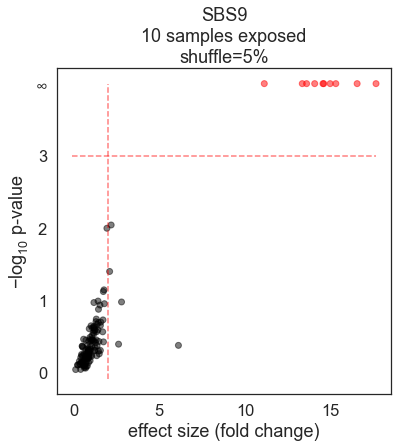

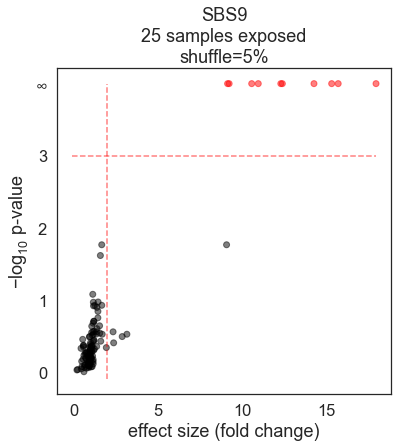

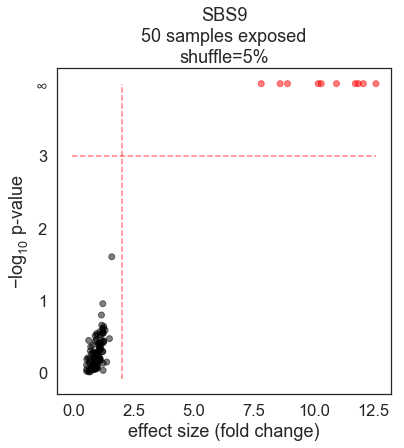

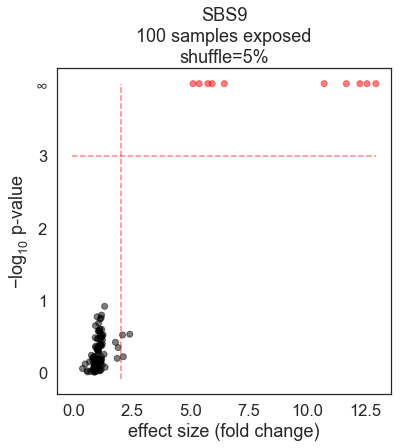

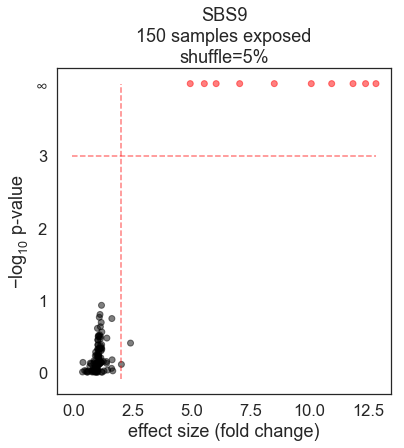

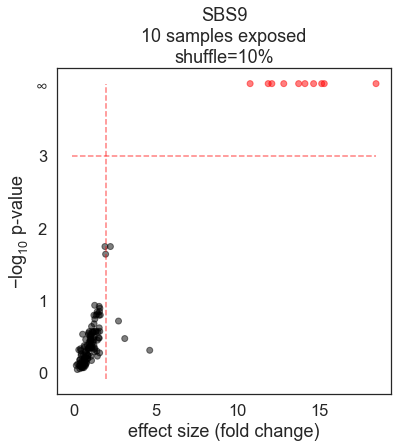

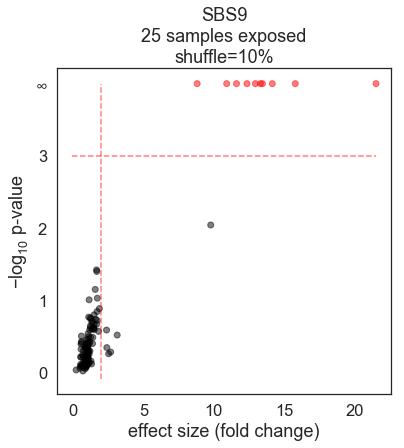

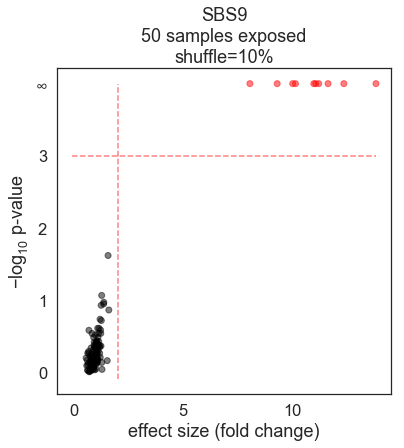

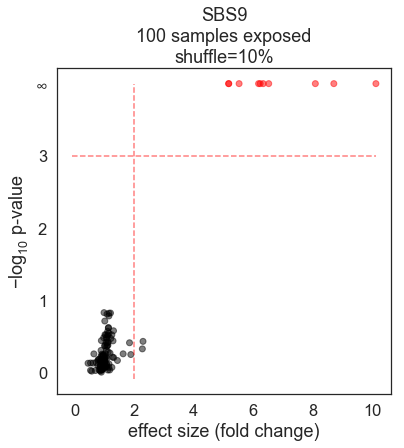

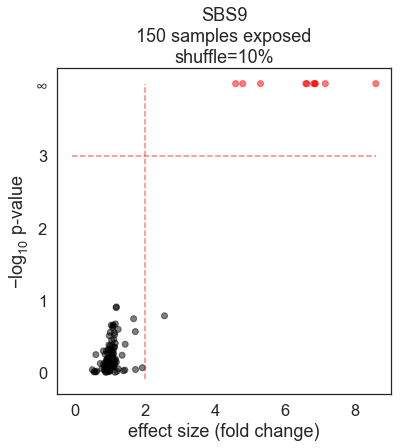

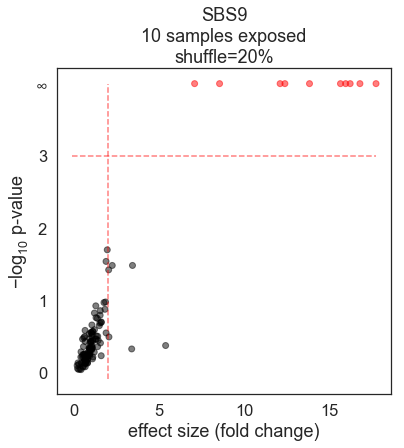

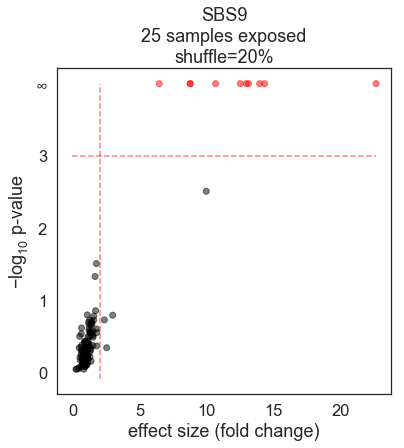

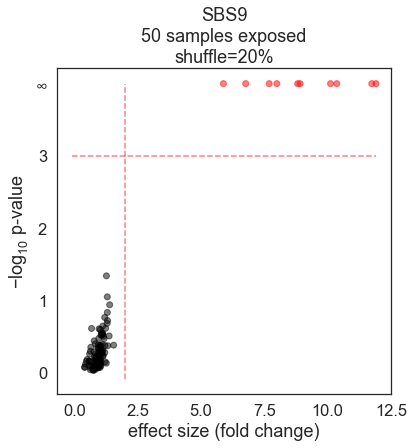

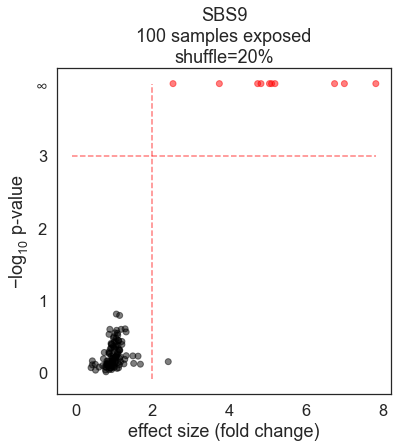

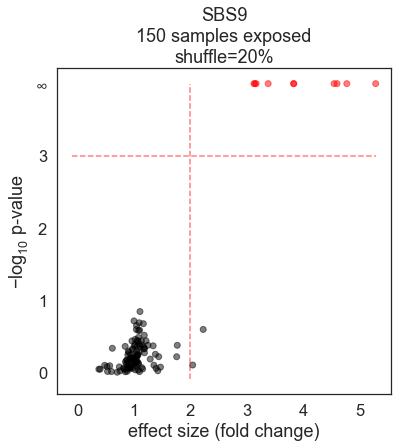

In [352]:
for shuffle in [5, 10, 20]:
    for n_treated in [10, 25, 50, 100, 150]:
        plot_volcano_shuffle('poleta', n_treated, shuffle)

In [402]:
regression_folder = '/home/fmuinos/projects/oriol/treatment_effects/simulations/regression_results/breastlungcolon'
deconstruction_folder = '/workspace/users/fmuinos/treatment_effects/simulations/deconstruction/breastlungcolon'

channel_index = synthetic.channel_index

def plot_lor_shuffle(etiology, n_treated, replicate, shuffle):

    index, cosine, twin_signal = signature_recovery(etiology, n_treated, replicate, plot=False)
    
    with open(os.path.join(regression_folder, f'shuffle.{shuffle}.regression_lor.{etiology}.{n_treated}.{replicate}.json'), 'rt') as f:
        merge_res = json.load(f)

    fig, ax = plt.subplots()
    pval_red   = []
    pval_pink  = []
    pval_other = []
    for k in sorted(merge_res, key=lambda v: np.mean(merge_res[v]), reverse=True):
        x, y = [], []
        for lor in merge_res[k]:
            x.append(k)
            y.append(lor)
        pval = np.sum(np.array(y) < 0) / len(y)
        color = 'black'
        if k == str(index[0]):
            color = 'red'
            pval_red.append(pval)
        elif k in list(map(str, index)):
            color = 'pink'
            pval_pink.append(pval)
        else:
            pval_other.append(pval)
            
        ax.scatter(x, y, alpha=0.2, color=color)
        
    ax.set_xlabel('signatures')
    ax.set_ylabel('log odds ratio')
    ax.set_title(f'{etiology}:{n_treated}:{replicate}')
    fig.savefig(f'figures/breastlungcolon.{etiology}.{n_treated}.logodds_test.png', bbox_inches='tight')
    plt.close(fig)
    return pval_red, pval_pink, pval_other

def plot_all_lor_shuffle(etiology, n_treated, shuffle):
    pvals_red = []
    pvals_pink = []
    pvals_other = []
    for replicate in range(10):
        p_red, p_pink, p_other = plot_lor_shuffle(etiology, n_treated, replicate + 1, shuffle)
        pvals_red += p_red
        pvals_pink += p_pink
        pvals_other += p_other
    return pvals_red, pvals_pink, pvals_other

def roc_curve_plot(p_red, p_pink, p_other, ax=None):

    y_true = [1]*len(p_red) + [0]*(len(p_pink)+len(p_other))
    y_score = list(map(lambda x: -x, p_red + p_pink + p_other))
    fprs, tprs, thresholds = metrics.roc_curve(y_true, y_score)
    auc = metrics.roc_auc_score(y_true, y_score)
    ax.plot(fprs, tprs)
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), '--')
    ax.set_title(f'Receiver Operating Characteristic\nAUC: {np.round(auc, 2)}')
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')

def roc_plot_shuffle(etiology, n_treated, shuffle):
    pvals_red, pvals_pink, pvals_other = plot_all_lor_shuffle(etiology, n_treated, shuffle)
    fig, ax = plt.subplots()
    auc = roc_curve_plot(pvals_red, pvals_pink, pvals_other, ax=ax)
    plt.show()

In [390]:
regression_folder = '/home/fmuinos/projects/oriol/treatment_effects/simulations/regression_results'

channel_index = synthetic.channel_index

def plot_lor_shuffle(etiology, n_treated, replicate, shuffle):

    index, cosine, twin_signals = signature_recovery(etiology, n_treated, replicate, plot=False)

    with open(os.path.join(regression_folder, f'shuffle.{shuffle}.regression_lor.{etiology}.{n_treated}.{replicate}.json'), 'rt') as f:
        merge_res = json.load(f)

    fig, ax = plt.subplots()
    
    for k in sorted(merge_res, key=lambda v: np.mean(merge_res[v]), reverse=True):
        x, y = [], []
        for lor in merge_res[k]:
            x.append(k)
            y.append(lor)
        color = 'black'
        if k == str(index):
            color = 'red'
        ax.scatter(x, y, alpha=0.2, color=color)
    ax.set_xlabel('signatures')
    ax.set_ylabel('log odds ratio')
    ax.set_title(f'{etiology}:{n_treated}:{replicate}:shuffle {shuffle}%')
    fig.savefig(f'figures/shuffle.{shuffle}.{etiology}.{n_treated}.logodds_test.png', bbox_inches='tight')

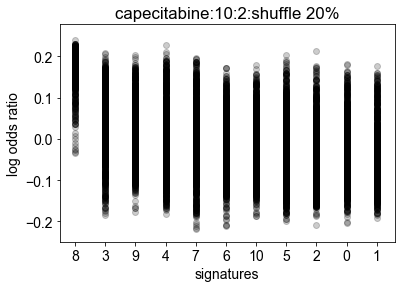

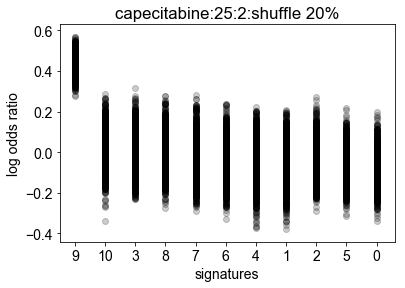

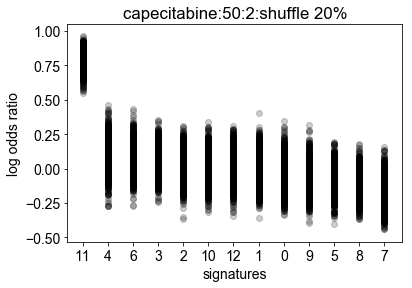

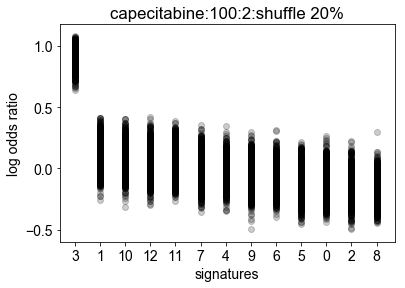

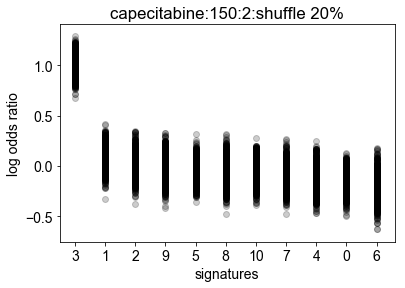

In [366]:
for n_treated in [10, 25, 50, 100, 150]:
    plot_lor_shuffle('capecitabine', n_treated, 2, 20)

In [371]:
regression_folder = '/home/fmuinos/projects/oriol/treatment_effects/simulations/regression_results'


def lor_mean_shuffle(etiology, n_treated, replicate, shuffle=None):

    index, cosine, twin_signals = signature_recovery(etiology, n_treated, replicate, plot=False)

    with open(os.path.join(regression_folder, f'shuffle.{shuffle}.regression_lor.{etiology}.{n_treated}.{replicate}.json'), 'rt') as f:
        merge_res = json.load(f)

    mean_lor, x = [], []
    for k in sorted(merge_res, key=lambda v: np.mean(merge_res[v]), reverse=True):
        if k == str(index):
            mean_lor.append(np.mean(merge_res[k]))
            x.append(0)
        else:
            mean_lor.append(np.mean(merge_res[k]))
            x.append(1)

    return x, mean_lor

def plot_lor_mean_shuffle(etiology, shuffle=None):

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.tick_params(length=0, which='major', pad=100, labelsize=14, axis='x')
    ax.tick_params(length=0, which='minor', pad=5, labelsize=14, rotation=90)
    ax.set_xticks(sum([[i - 0.2, i + 0.2] for i in range(5)], []), minor=True)
    ax.set_xticklabels([etiology, 'other'] * 5, minor=True)
    ax.set_xticks(range(5), minor=False)
    ax.set_xticklabels(list(map(lambda x: f'treated={x}', [10, 25, 50, 100, 150])))
    for i, n_treated in enumerate([10, 25, 50, 100, 150]):
        for replicate in range(1, 11):
            try:
                x, mean_lor = lor_mean_shuffle(etiology, n_treated, replicate, shuffle=shuffle)
                ax.scatter((np.array(x) - 0.5) * (0.2 / 0.5) + i , mean_lor, alpha=0.5, color='black')
            except FileNotFoundError as e:
                pass
    ax.hlines(0, -0.4, 4.4, linestyles='dashed', color='red', alpha=0.5)
    ax.set_ylabel('mean log odds ratio')
    ax.set_title(f'{etiology}: shuffle {shuffle}%')
    fig.savefig(f'figures/shuffle.{shuffle}.{etiology}.mean_logodds_plot.svg', dpi=200, bbox_inches='tight')
    plt.show()

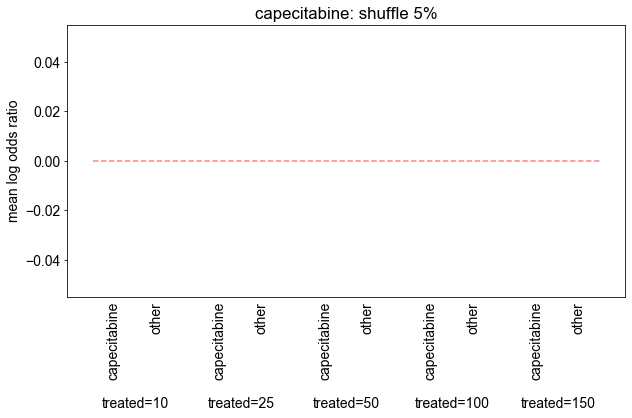

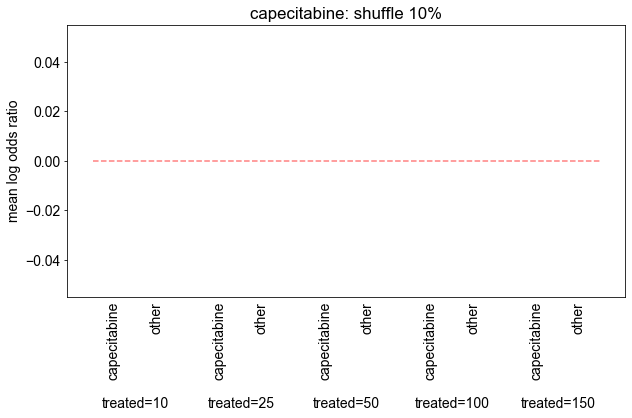

KeyboardInterrupt: 

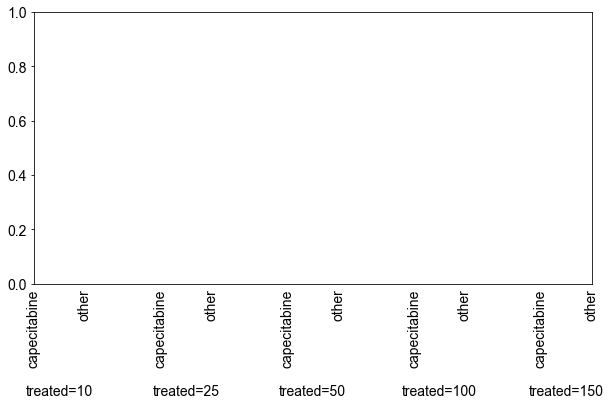

In [372]:
for etiology in synthetic.etiologies:
    for shuffle in [5, 10, 20]:
        plot_lor_mean_shuffle(etiology, shuffle=shuffle)

# ... now with fold-change

In [126]:
regression_folder = '/home/fmuinos/projects/oriol/treatment_effects/simulations/regression_results'

channel_index = synthetic.channel_index


def fold_change(etiology, n_treated, replicate, shuffle=None):

    index, cosine = signature_recovery(etiology, n_treated, replicate, plot=False)
    df = pd.read_csv(os.path.join(regression_folder, f'shuffle.{shuffle}.regression_summary.{etiology}.{n_treated}.{replicate}.tsv'), sep='\t')
    x, y = [], []
    x.append(0)
    y.append(df.loc[index, 'effect_size'])
    x += [1 for i in df.loc[:, 'signature'] if i not in [index]]
    y += list(df[~df.signature.isin([index])]['effect_size'].values)
    
    return x, y


def plot_fold_change(etiology, shuffle=None):

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.tick_params(length=0, which='major', pad=100, labelsize=14, axis='x')
    ax.tick_params(length=0, which='minor', pad=5, labelsize=14, rotation=90)

    ax.set_xticks(sum([[i - 0.2, i + 0.2] for i in range(5)], []), minor=True)
    ax.set_xticklabels([etiology, 'other'] * 5, minor=True)
    ax.set_xticks(range(5), minor=False)
    ax.set_xticklabels(list(map(lambda x: f'treated={x}', [10, 25, 50, 100, 150])))
    
    for i, n_treated in enumerate([10, 25, 50, 100, 150]):
        for replicate in range(1, 11):
            try:
                x, y = fold_change(etiology, n_treated, replicate, shuffle=shuffle)
                ax.scatter((np.array(x) - 0.5) * (0.2 / 0.5) + i, y, alpha=0.5, color='green')
            except FileNotFoundError as e:
                pass
    ax.hlines(2, -0.4, 4.4, linestyles='dashed', color='red', alpha=0.5)
    ax.set_ylabel('fold change')
    ax.set_title(f'{etiology}: shuffle {shuffle}%')
    fig.savefig(f'figures/shuffle.{shuffle}.{etiology}.fold_change_plot.svg', dpi=200, bbox_inches='tight')
    plt.show()

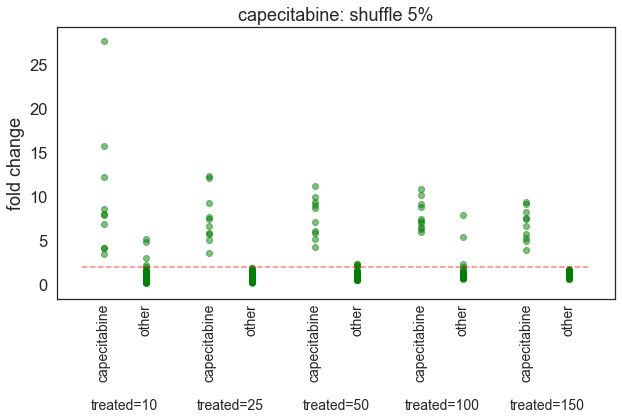

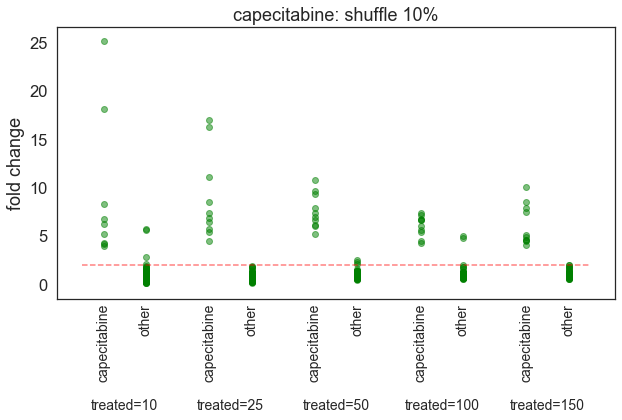

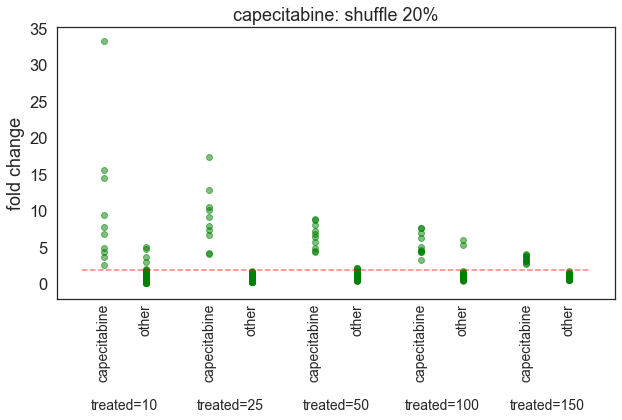

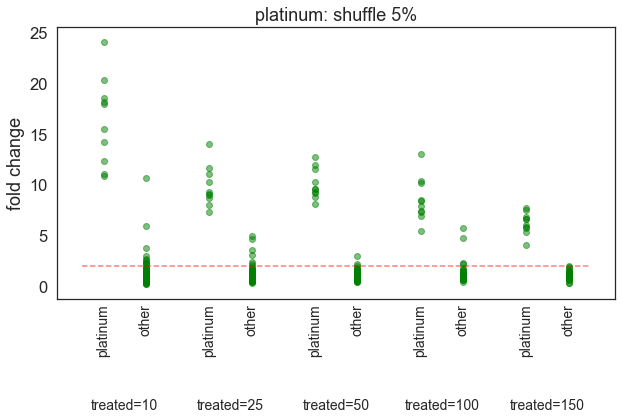

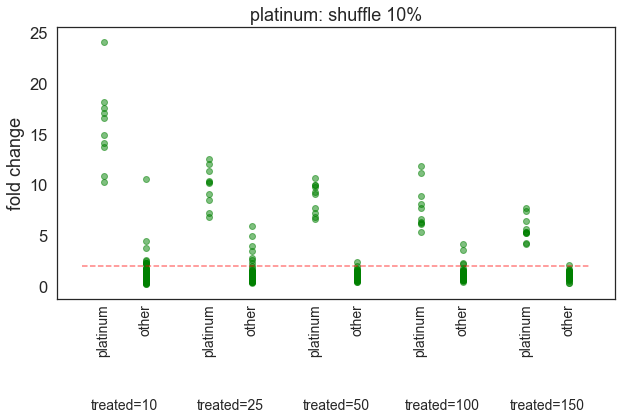

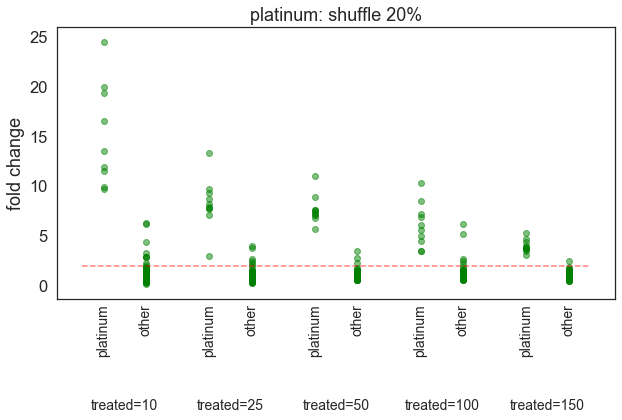

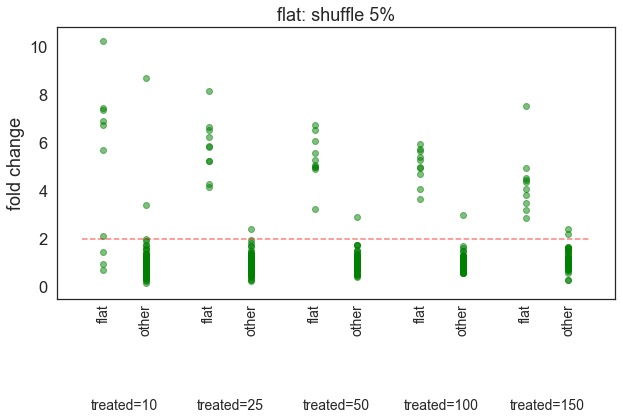

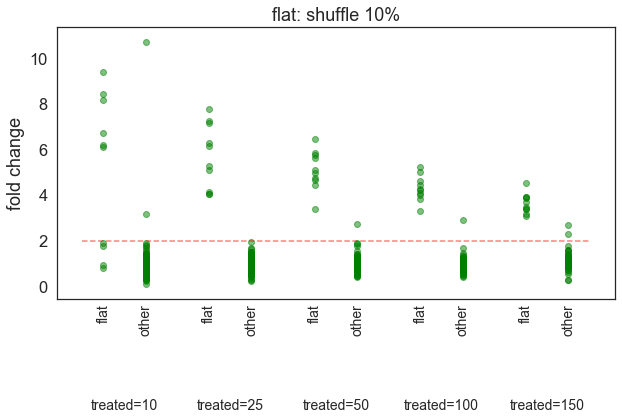

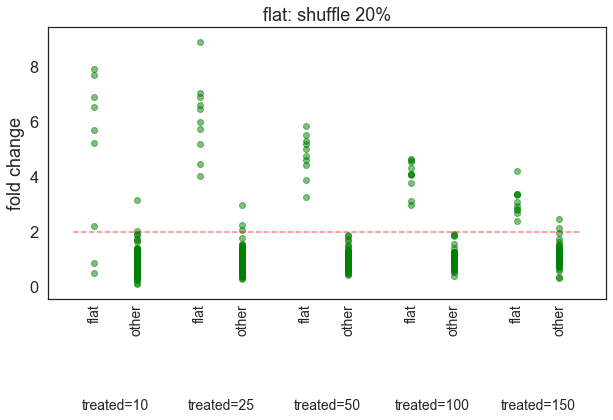

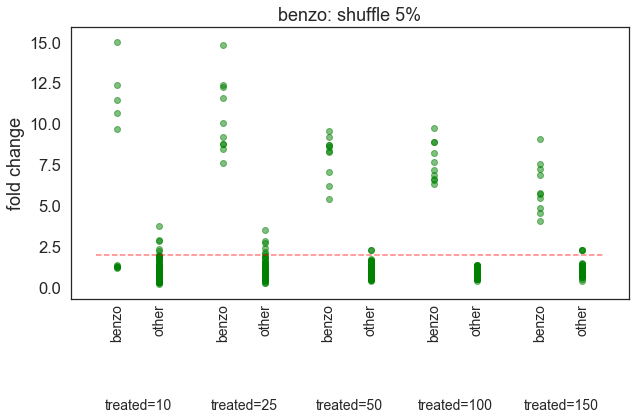

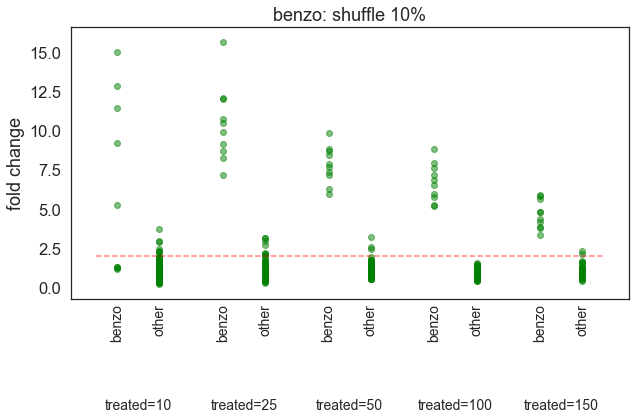

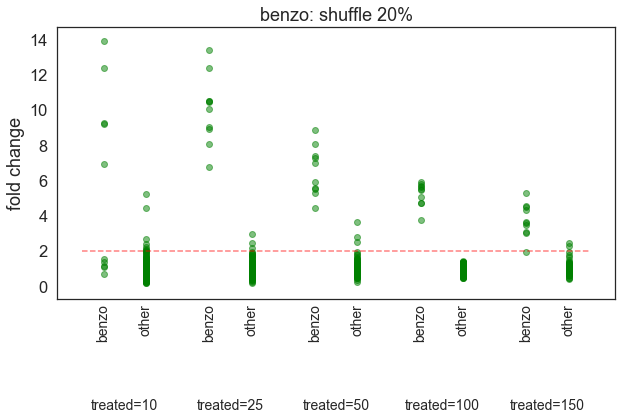

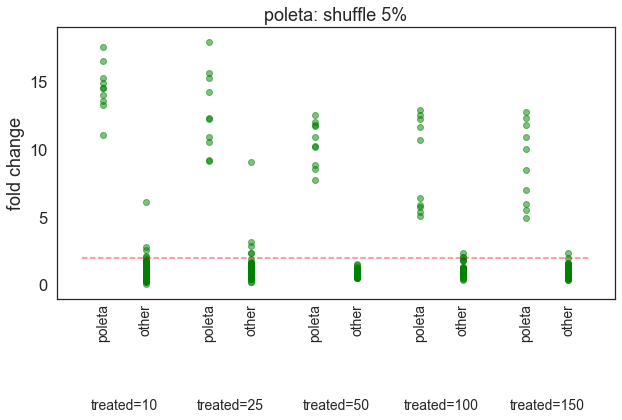

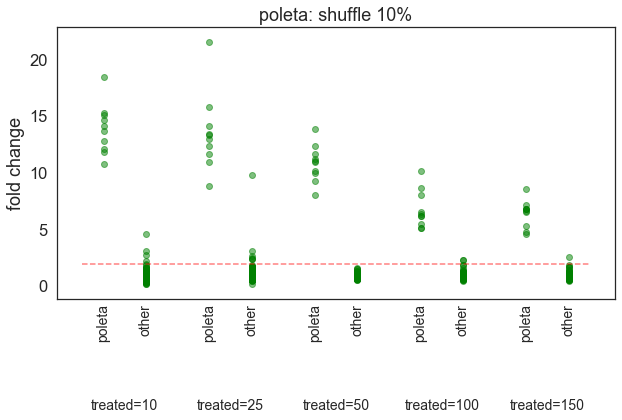

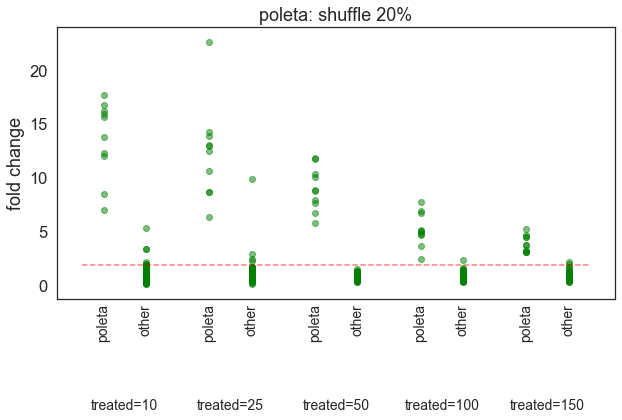

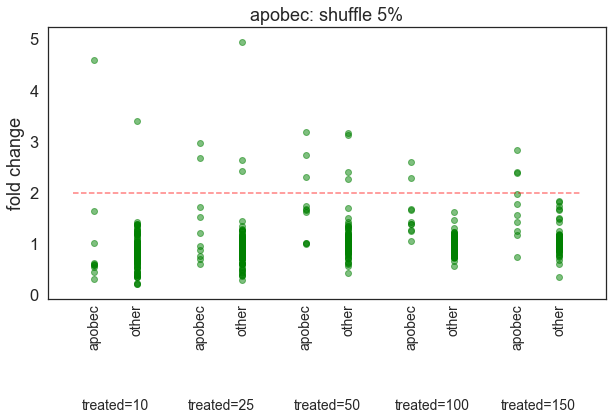

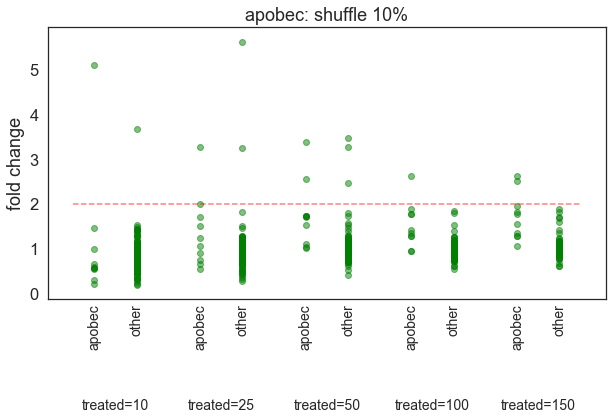

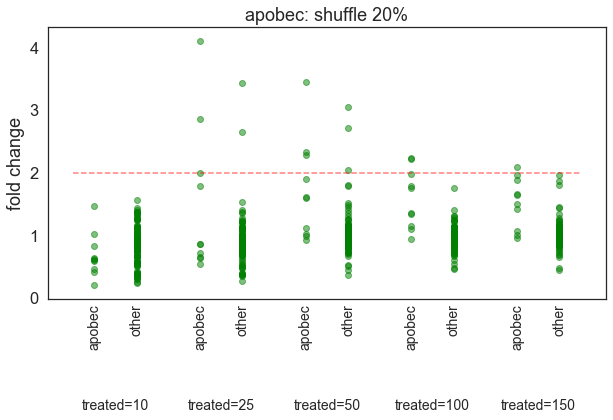

In [127]:
for etiology in synthetic.etiologies:
    for shuffle in [5, 10, 20]:
        plot_fold_change(etiology, shuffle=shuffle)

# Synthetic signal against placebo

In [143]:
deconstruction_folder = '/workspace/users/fmuinos/treatment_effects/simulations/deconstruction/breastlungcolon'
matrix_treatment_folder = '/home/fmuinos/projects/oriol/treatment_effects/simulations/treatment_matrix/breastlungcolon'
signatures_path = '/home/fmuinos/projects/oriol/treatment_effects/simulations/signatures.pickle.gz'
output = '/home/fmuinos/projects/oriol/treatment_effects/simulations/cotreatments/breastlungcolon'

for overlap in tqdm.tqdm([25, 50, 75]):
    for etiology in tqdm.tqdm(synthetic.etiologies):
        global_pool = []
        for n_treated in [10, 25, 50, 100, 150]:
            replicate_pool = []
            for replicate in range(25):
                try:
                    res = attribution_many_at_once(etiology, n_treated, replicate+1, deconstruction_folder, matrix_treatment_folder, overlap, signatures_path)
                    #res = attribution(etiology, n_treated, replicate + 1, deconstruction_folder, matrix_treatment_folder, overlap, signatures_path)
                    explained_by_etiology = np.array(res[etiology]) + 1
                    explained_by_placebo = np.array(res['placebo']) + 1
                    fold_change = list(np.log10(explained_by_etiology / explained_by_placebo))
                    replicate_pool += fold_change
                except: 
                    pass
            global_pool.append(replicate_pool)
        with open(os.path.join(output, f'{overlap}.{etiology}.cotreatment_fold_change.json'), 'wt') as f:
            json.dump(global_pool, f)





  0%|          | 0/3 [00:00<?, ?it/s]




  0%|          | 0/2 [00:00<?, ?it/s]




 50%|█████     | 1/2 [00:15<00:15, 15.74s/it]




100%|██████████| 2/2 [00:28<00:00, 14.74s/it]



 33%|███▎      | 1/3 [00:28<00:56, 28.15s/it]




  0%|          | 0/2 [00:00<?, ?it/s]




 50%|█████     | 1/2 [00:12<00:12, 12.21s/it]




100%|██████████| 2/2 [00:24<00:00, 12.24s/it]



 67%|██████▋   | 2/3 [00:52<00:27, 27.06s/it]




  0%|          | 0/2 [00:00<?, ?it/s]




 50%|█████     | 1/2 [00:11<00:11, 11.96s/it]




100%|██████████| 2/2 [00:25<00:00, 12.40s/it]



100%|██████████| 3/3 [01:18<00:00, 26.56s/it]

In [144]:
def plot_fold_change(etiology):
    all_x, all_y, overlaps = [], [], []
    for overlap in [25, 50, 75]:
        path = os.path.join(output, f'{overlap}.{etiology}.cotreatment_fold_change.json')
        with open(path, 'rt') as f:
            fold_change = json.load(f)
        
        x, y = list(zip(*[(i, v) for i, fc in enumerate(fold_change) for v in fc]))
        all_x += x
        all_y += y
        overlaps += [overlap] * len(x)
    data = pd.DataFrame({'x': all_x, 'y': all_y, 'overlap': overlaps})
    fig, ax = plt.subplots()
    seaborn.violinplot('x', 'y', hue='overlap', data=data, alpha=0.3, scale='count', inner=None, legend=False, ax=ax)
    ax.set_xticklabels(labels=list(map(str, [10, 25, 50, 100, 150])))
    ax.set_xlabel('no. samples exposed')
    ax.set_ylabel('$\log_{10}$ fold change')
    ax.set_ylim(-5, 5)
    ax.hlines(0, -0.5, 4.5, color='red', linestyles='dashed')
    ax.set_title(f'{synthetic.etiologies[etiology]}')
    ax.legend(title='Overlap', loc=4, labels=['25%', '50%', '75%'])
    plt.savefig(f'figures/breastlungcolon.manytoone.{etiology}.cotreatments.svg', dpi=200, bbox_inches='tight')

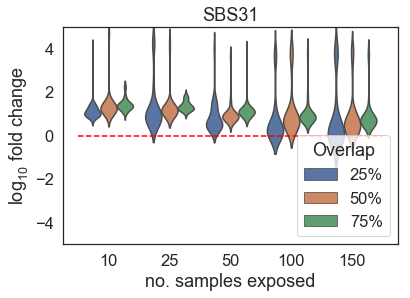

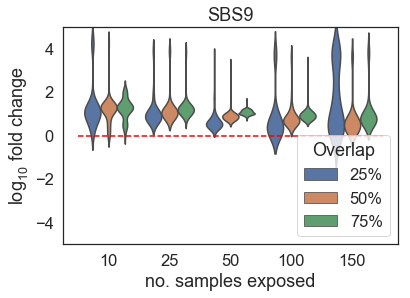

In [145]:
for etiology in synthetic.etiologies:
    plot_fold_change(etiology)

# BREASTLUNGCOLON ANALYSIS

# Recovery of synthetic signatures

In [54]:
deconstruction_folder = '/workspace/users/fmuinos/treatment_effects/simulations/deconstruction/'

channel_index = synthetic.channel_index

def signature_recovery(etiology, n_treated, replicate, plot=False):
    
    case = f'{etiology}.{n_treated}.{replicate}.catalogue.tsv'
    df = pd.read_csv(os.path.join(deconstruction_folder, f'{case}/{case}.processes.tsv'), sep='\t')
    cosines = []
    for col in df.columns:
        reference = signatures[synthetic.etiologies[etiology]].values
        profile = df[col].values 
        cosine = metrics.pairwise.cosine_similarity([reference], [profile])[0][0]
        profile_dict = dict(zip(channel_index, profile))
        cosines.append(cosine)
    cosine = max(cosines)
    index = np.argmax(cosines)
    if plot:
        fig, ax = plt.subplots(figsize=(20, 5))
        plot_signature(profile_dict, title=f'{etiology}:{n_treated}:{np.round(cosine, 3)}', ax=ax)
        plt.show()
    return index, cosine

In [160]:
for replicate in range(10):
    index, cosine = signature_recovery('capecitabine', 50, replicate + 1)

In [164]:
def scatter_cosine(etiology):
    
    fig, ax = plt.subplots()
    
    # plot layout
    major_labels = [10, 25, 50, 100, 150]  # representing n_treated
    major_ticks = np.arange(5)
    ax.set_ylim(0.7, 1.03)
    ax.set_xticks(ticks=major_ticks)
    ax.set_xticklabels(labels=map(str, major_labels))
    ax.set_xlabel('number of treated')
    ax.set_ylabel('cosine similarity')
    ax.set_title(etiology, fontsize=24)
    
    # scatter plot
    cosines = []
    x = []
    for i, n_treated in enumerate(major_labels):
        cos = list(map(lambda x: signature_recovery(etiology, n_treated, x + 1), range(10)))
        cosines += list(zip(*cos))[1]
        x += [i] * len(cos)
    ax.scatter(x, cosines, alpha=0.5)
    fig.savefig(f'figures/{etiology}.cosine.svg', dpi=200, bbox_inches='tight')
    plt.show()

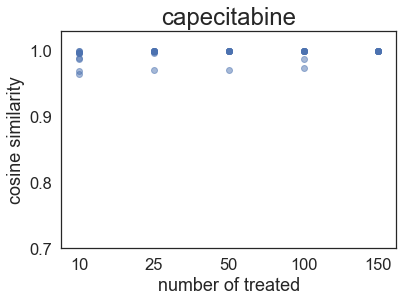

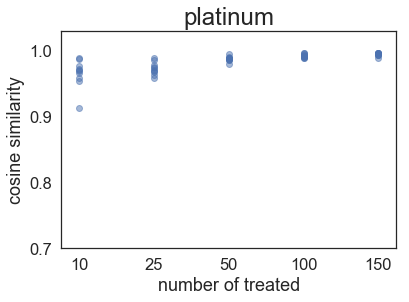

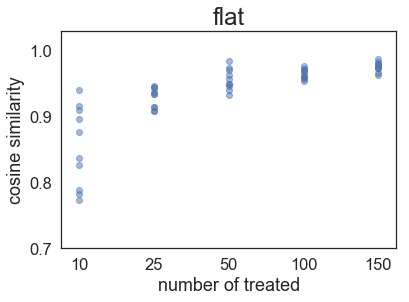

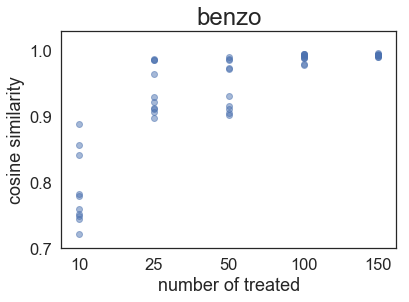

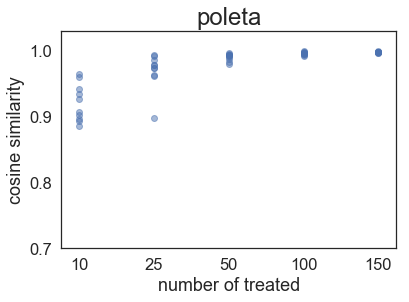

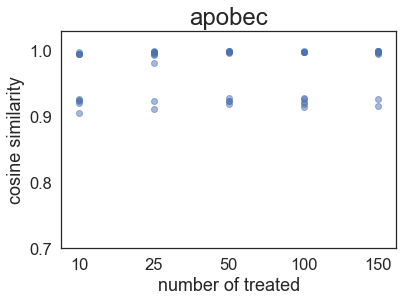

In [165]:
for etiology in synthetic.etiologies:
    scatter_cosine(etiology)

# Recovery of exposure

In [31]:
catalogue_folder = '/home/fmuinos/projects/oriol/treatment_effects/simulations/catalogues/'
deconstruction_folder = '/workspace/users/fmuinos/treatment_effects/simulations/deconstruction/'

channel_index = synthetic.channel_index

def exposure_recovery(etiology, n_treated, replicate):
    
    # load synthetic burden
    burden_fn = f'{etiology}.{n_treated}.{replicate}.burden.tsv'
    with open(os.path.join(catalogue_folder, burden_fn), 'rt') as f:
        burden = json.load(f)
    burden = np.array(burden[:n_treated])
    
    # load exposures
    case = f'{etiology}.{n_treated}.{replicate}.catalogue.tsv'
    exposure = pd.read_csv(os.path.join(deconstruction_folder, f'{case}/{case}.exposures.tsv'), sep='\t')
    index, cosine = signature_recovery(etiology, n_treated, replicate)
    exposure = exposure.iloc[index, :n_treated].values
    return burden, exposure

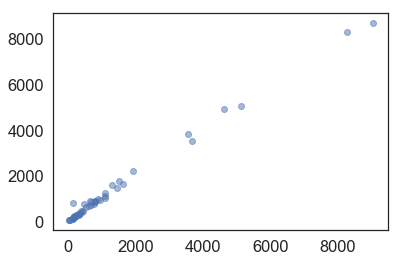

In [201]:
burden, exposure = exposure_recovery('capecitabine', 50, 1)
mre = np.mean(np.abs((burden - exposure) / burden))
plt.scatter(list(burden), list(exposure), alpha=0.5)
plt.show()

In [43]:
def scatter_error(etiology, option='error'):
    """
    option: 'error', 'correlation'
    """
    
    fig, ax = plt.subplots()
    
    # plot layout
    major_labels = [10, 25, 50, 100, 150]  # representing n_treated
    major_ticks = np.arange(5)
    ax.set_ylim(0.3, 1.03)
    ax.set_xticks(ticks=major_ticks)
    ax.set_xticklabels(labels=map(str, major_labels))
    ax.set_title(etiology, fontsize=24)
    ax.set_xlabel('number of treated')
    if option == 'error':
        ax.set_ylabel('mean relative error')
    elif option == 'correlation':
        ax.set_ylabel('correlation')
    # scatter plot
    values = []
    x = []
    for i, n_treated in enumerate(major_labels):
        for replicate in range(10):
            burden, exposure = exposure_recovery(etiology, n_treated, replicate + 1)
            if option == 'error':
                value = np.mean(np.abs((burden - exposure) / burden))
            elif option == 'correlation':
                value = scipy.stats.pearsonr(burden, exposure)[0]
            x.append(i)
            values.append(value)
    ax.scatter(x, values, alpha=0.5)
    fig.savefig(f'figures/{etiology}.exposure_{option}.svg', dpi=200, bbox_inches='tight')
    plt.show()

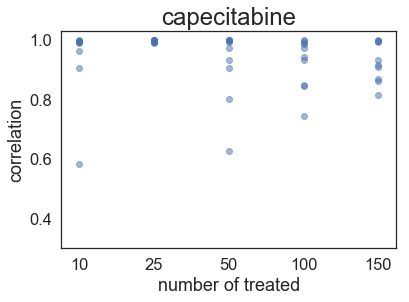

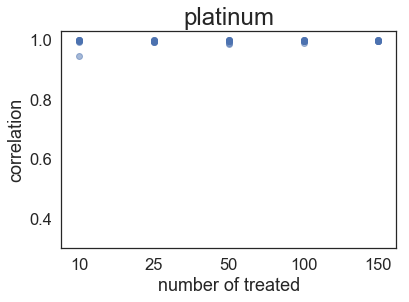

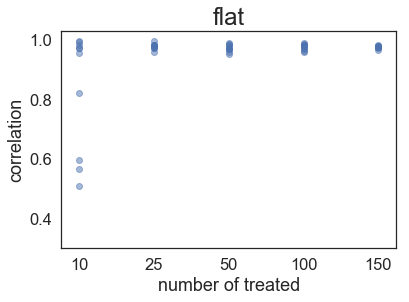

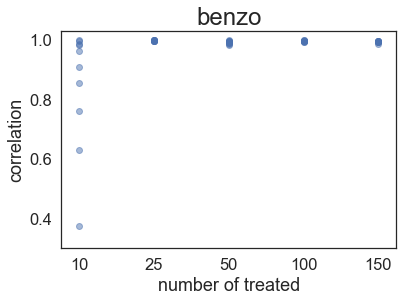

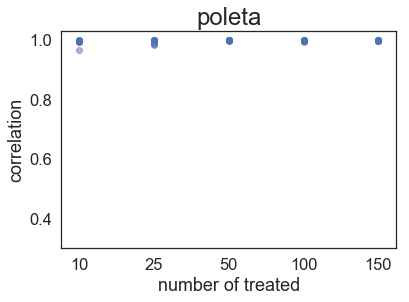

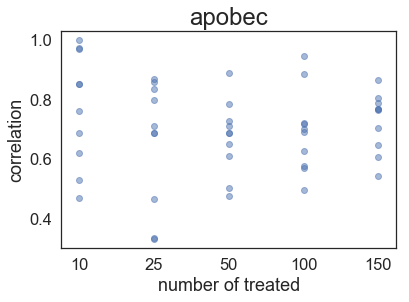

In [44]:
for etiology in synthetic.etiologies:
    scatter_error(etiology, option='correlation')

# Recovering Treatment Dependence of Signatures 

In [80]:
regression_folder = '/home/fmuinos/projects/oriol/treatment_effects/simulations/regression_results'

channel_index = synthetic.channel_index


def plot_lor(etiology, n_treated, replicate):

    index, cosine = signature_recovery(etiology, n_treated, replicate, plot=False)

    with open(os.path.join(regression_folder, f'regression_lor.{etiology}.{n_treated}.{replicate}.json'), 'rt') as f:
        merge_res = json.load(f)

    fig, ax = plt.subplots()
    
    for k in sorted(merge_res, key=lambda v: np.mean(merge_res[v]), reverse=True):
        x, y = [], []
        for lor in merge_res[k]:
            x.append(k)
            y.append(lor)
        color = 'black'
        if k == str(index):
            color = 'red'
        ax.scatter(x, y, alpha=0.2, color=color)
    ax.set_xlabel('signatures')
    ax.set_ylabel('log odds ratio')
    ax.set_title(f'{etiology}:{n_treated}:{replicate}')
    fig.savefig(f'figures/{etiology}.{n_treated}.logodds_test.svg', dpi=200, bbox_inches='tight')

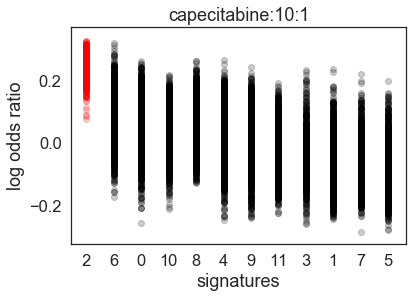

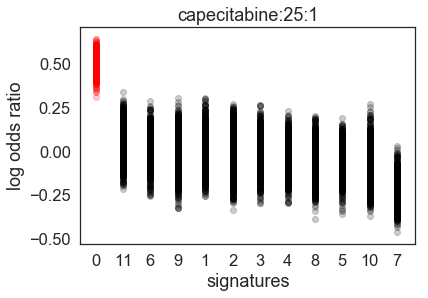

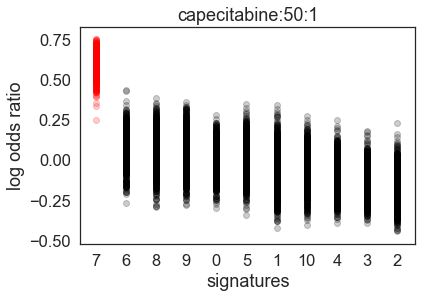

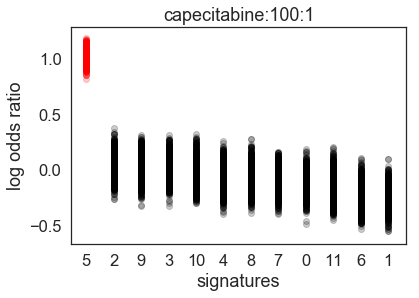

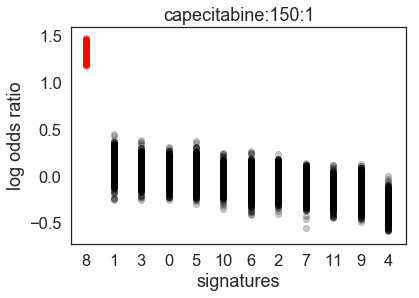

In [81]:
for n_treated in [10, 25, 50, 100, 150]:
    plot_lor('capecitabine', n_treated, 1)

In [82]:
def lor_mean(etiology, n_treated, replicate):

    index, cosine = signature_recovery(etiology, n_treated, replicate, plot=False)

    with open(os.path.join(regression_folder, f'regression_lor.{etiology}.{n_treated}.{replicate}.json'), 'rt') as f:
        merge_res = json.load(f)

    mean_lor, x = [], []
    for k in sorted(merge_res, key=lambda v: np.mean(merge_res[v]), reverse=True):
        if k == str(index):
            mean_lor.append(np.mean(merge_res[k]))
            x.append(0)
        else:
            mean_lor.append(np.mean(merge_res[k]))
            x.append(1)

    return x, mean_lor

def plot_lor_mean(etiology):

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.tick_params(length=0, which='major', pad=100, labelsize=14, axis='x')
    ax.tick_params(length=0, which='minor', pad=5, labelsize=14, rotation=90)
    ax.set_xticks(sum([[i - 0.2, i + 0.2] for i in range(5)], []), minor=True)
    ax.set_xticklabels([etiology, 'other'] * 5, minor=True)
    ax.set_xticks(range(5), minor=False)
    ax.set_xticklabels(list(map(lambda x: f'treated={x}', [10, 25, 50, 100, 150])))
    for i, n_treated in enumerate([10, 25, 50, 100, 150]):
        for replicate in range(1, 11):
            x, mean_lor = lor_mean(etiology, n_treated, replicate)
            ax.scatter((np.array(x) - 0.5) * (0.2 / 0.5) + i , mean_lor, alpha=0.5, color='black')
    ax.hlines(0, -0.4, 4.4, linestyles='dashed', color='red', alpha=0.5)
    ax.set_ylabel('mean log odds ratio')
    ax.set_title(f'{etiology}')
    fig.savefig(f'figures/{etiology}.mean_logodds_plot.svg', dpi=200, bbox_inches='tight')
    plt.show()

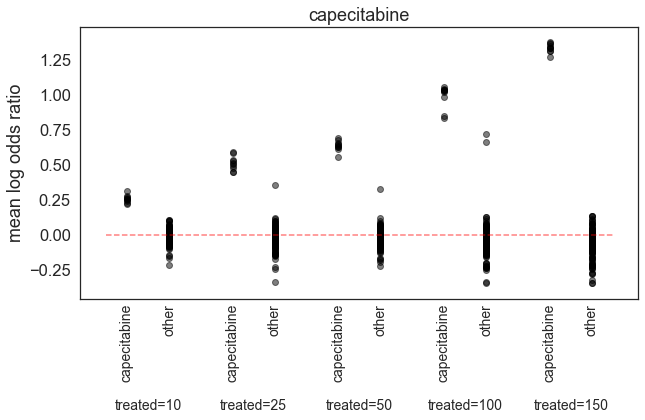

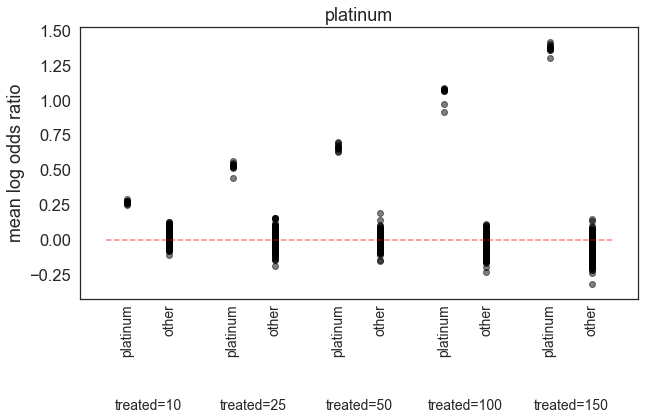

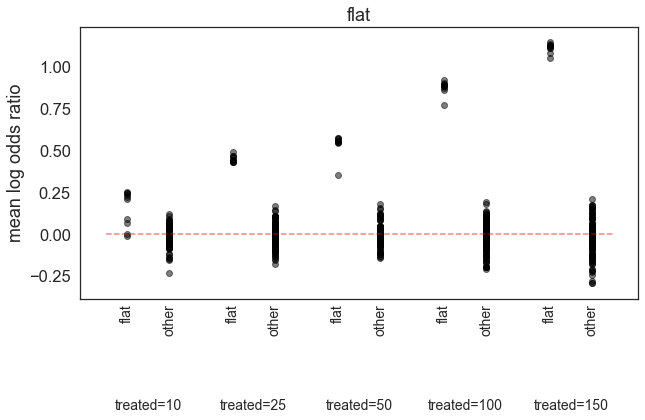

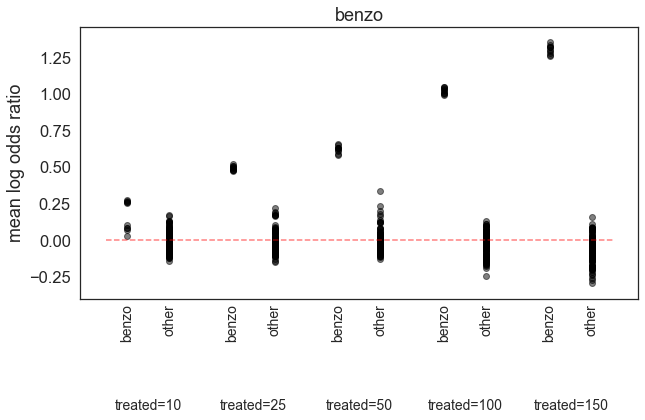

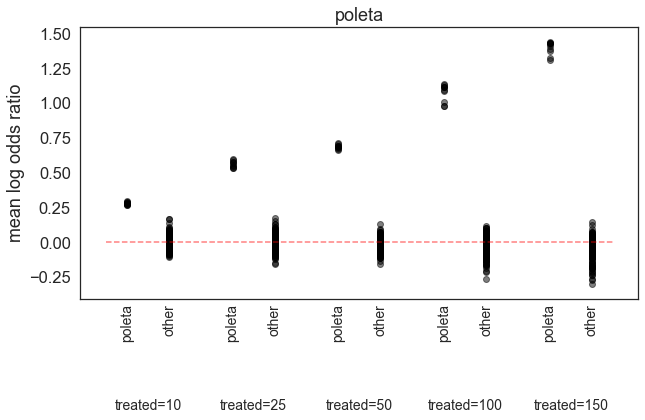

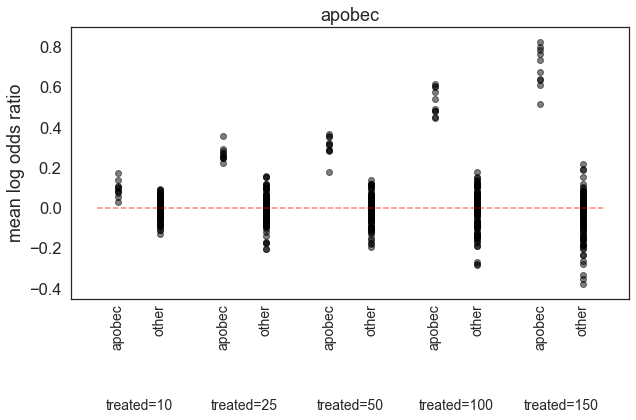

In [83]:
for etiology in synthetic.etiologies:
    plot_lor_mean(etiology)

# ... now with fold-change

In [84]:
regression_folder = '/home/fmuinos/projects/oriol/treatment_effects/simulations/regression_results'

channel_index = synthetic.channel_index


def fold_change(etiology, n_treated, replicate):

    index, cosine = signature_recovery(etiology, n_treated, replicate, plot=False)
    df = pd.read_csv(os.path.join(regression_folder, f'regression_summary.{etiology}.{n_treated}.{replicate}.tsv'), sep='\t')
    x, y = [], []
    x.append(0)
    y.append(df.loc[index, 'effect_size'])
    x += [1 for i in df.loc[:, 'signature'] if i not in [index]]
    y += list(df[~df.signature.isin([index])]['effect_size'].values)
    
    return x, y


def plot_fold_change(etiology):

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.tick_params(length=0, which='major', pad=100, labelsize=14, axis='x')
    ax.tick_params(length=0, which='minor', pad=5, labelsize=14, rotation=90)

    ax.set_xticks(sum([[i - 0.2, i + 0.2] for i in range(5)], []), minor=True)
    ax.set_xticklabels([etiology, 'other'] * 5, minor=True)
    ax.set_xticks(range(5), minor=False)
    ax.set_xticklabels(list(map(lambda x: f'treated={x}', [10, 25, 50, 100, 150])))
    
    for i, n_treated in enumerate([10, 25, 50, 100, 150]):
        for replicate in range(1, 11):
            x, y = fold_change(etiology, n_treated, replicate)
            ax.scatter((np.array(x) - 0.5) * (0.2 / 0.5) + i, y, alpha=0.5, color='green')
    ax.hlines(2, -0.4, 4.4, linestyles='dashed', color='red', alpha=0.5)
    ax.set_ylabel('fold change')
    ax.set_title(f'{etiology}')
    fig.savefig(f'figures/{etiology}.fold_change_plot.svg', dpi=200, bbox_inches='tight')
    plt.show()

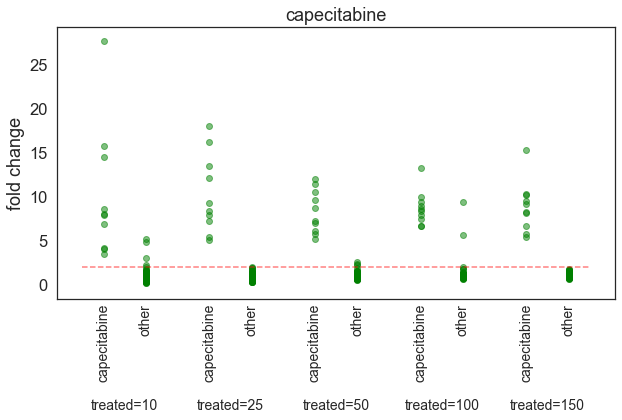

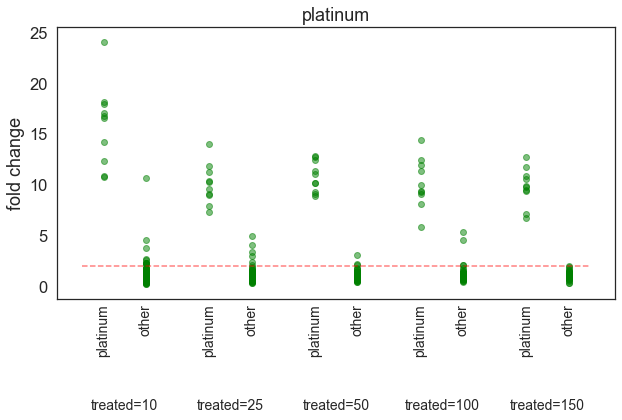

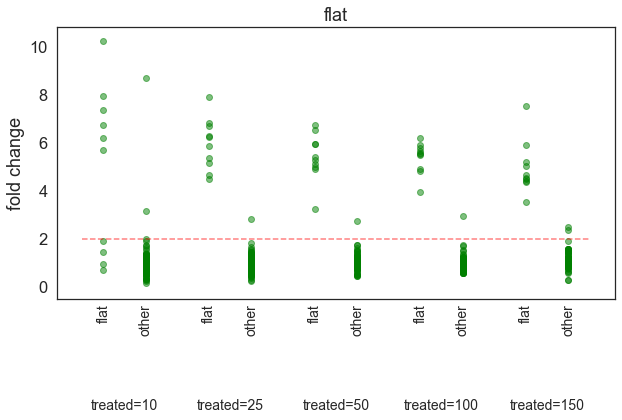

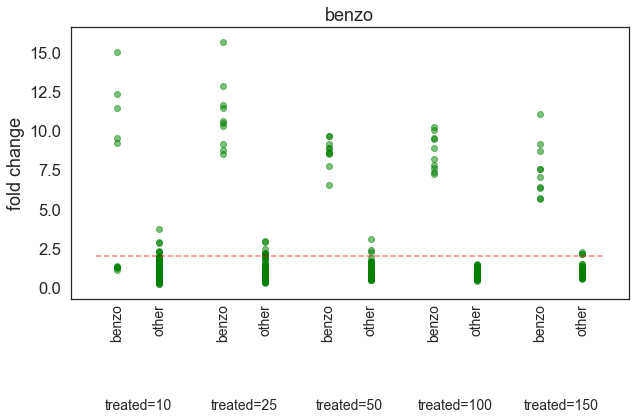

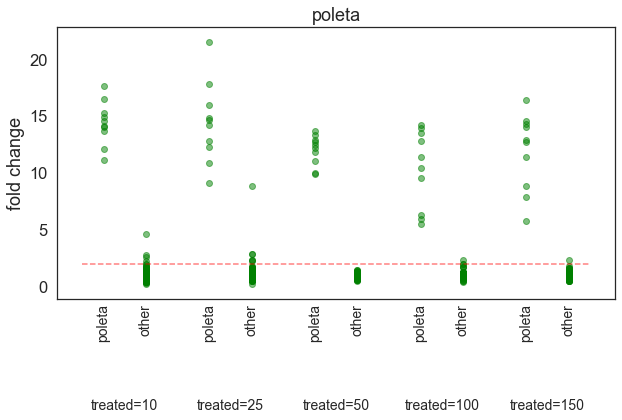

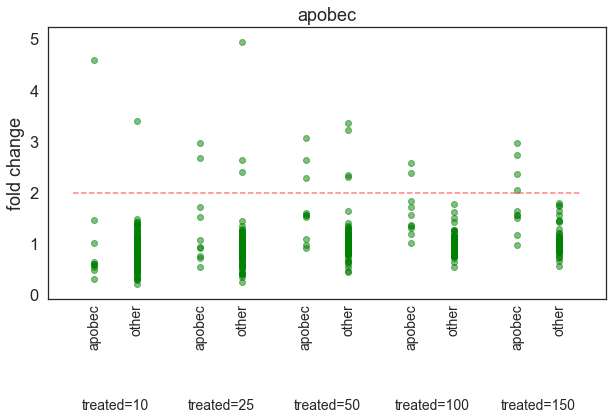

In [85]:
for etiology in synthetic.etiologies:
    plot_fold_change(etiology)

# Shuffled treatments!

# Recovering Treatment Dependencies of Signatures 

In [86]:
regression_folder = '/home/fmuinos/projects/oriol/treatment_effects/simulations/regression_results'

channel_index = synthetic.channel_index


def plot_lor_shuffle(etiology, n_treated, replicate, shuffle):

    index, cosine = signature_recovery(etiology, n_treated, replicate, plot=False)

    with open(os.path.join(regression_folder, f'shuffle.{shuffle}.regression_lor.{etiology}.{n_treated}.{replicate}.json'), 'rt') as f:
        merge_res = json.load(f)

    fig, ax = plt.subplots()
    
    for k in sorted(merge_res, key=lambda v: np.mean(merge_res[v]), reverse=True):
        x, y = [], []
        for lor in merge_res[k]:
            x.append(k)
            y.append(lor)
        color = 'black'
        if k == str(index):
            color = 'red'
        ax.scatter(x, y, alpha=0.2, color=color)
    ax.set_xlabel('signatures')
    ax.set_ylabel('log odds ratio')
    ax.set_title(f'{etiology}:{n_treated}:{replicate}')
    fig.savefig(f'figures/shuffle.{shuffle}.{etiology}.{n_treated}.logodds_test.svg', dpi=200, bbox_inches='tight')

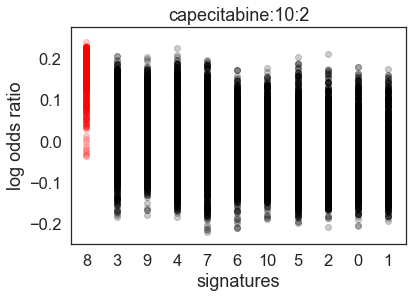

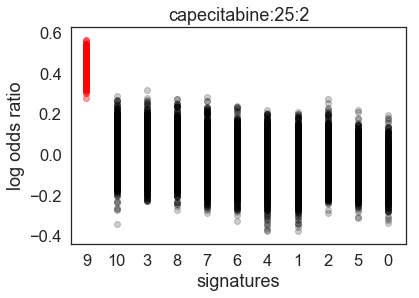

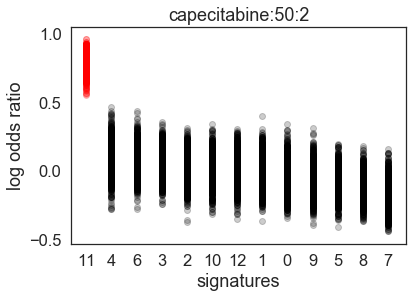

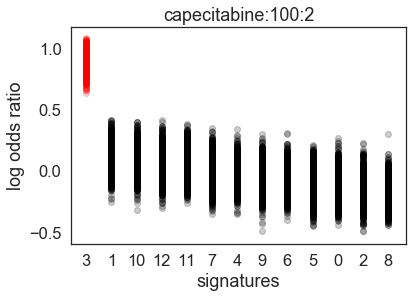

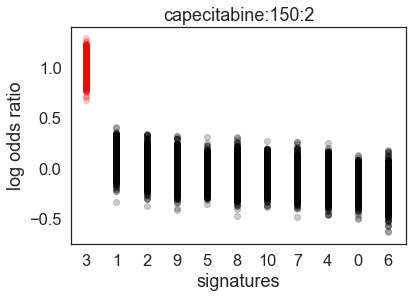

In [87]:
for n_treated in [10, 25, 50, 100, 150]:
    plot_lor_shuffle('capecitabine', n_treated, 2, 20)

In [98]:
def lor_mean_shuffle(etiology, n_treated, replicate, shuffle=None):

    index, cosine = signature_recovery(etiology, n_treated, replicate, plot=False)

    with open(os.path.join(regression_folder, f'shuffle.{shuffle}.regression_lor.{etiology}.{n_treated}.{replicate}.json'), 'rt') as f:
        merge_res = json.load(f)

    mean_lor, x = [], []
    for k in sorted(merge_res, key=lambda v: np.mean(merge_res[v]), reverse=True):
        if k == str(index):
            mean_lor.append(np.mean(merge_res[k]))
            x.append(0)
        else:
            mean_lor.append(np.mean(merge_res[k]))
            x.append(1)

    return x, mean_lor

def plot_lor_mean_shuffle(etiology, shuffle=None):

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.tick_params(length=0, which='major', pad=100, labelsize=14, axis='x')
    ax.tick_params(length=0, which='minor', pad=5, labelsize=14, rotation=90)
    ax.set_xticks(sum([[i - 0.2, i + 0.2] for i in range(5)], []), minor=True)
    ax.set_xticklabels([etiology, 'other'] * 5, minor=True)
    ax.set_xticks(range(5), minor=False)
    ax.set_xticklabels(list(map(lambda x: f'treated={x}', [10, 25, 50, 100, 150])))
    for i, n_treated in enumerate([10, 25, 50, 100, 150]):
        for replicate in range(1, 11):
            try:
                x, mean_lor = lor_mean_shuffle(etiology, n_treated, replicate, shuffle=shuffle)
                ax.scatter((np.array(x) - 0.5) * (0.2 / 0.5) + i , mean_lor, alpha=0.5, color='black')
            except FileNotFoundError as e:
                pass
    ax.hlines(0, -0.4, 4.4, linestyles='dashed', color='red', alpha=0.5)
    ax.set_ylabel('mean log odds ratio')
    ax.set_title(f'{etiology}: shuffle {shuffle}%')
    fig.savefig(f'figures/shuffle.{shuffle}.{etiology}.mean_logodds_plot.svg', dpi=200, bbox_inches='tight')
    plt.show()

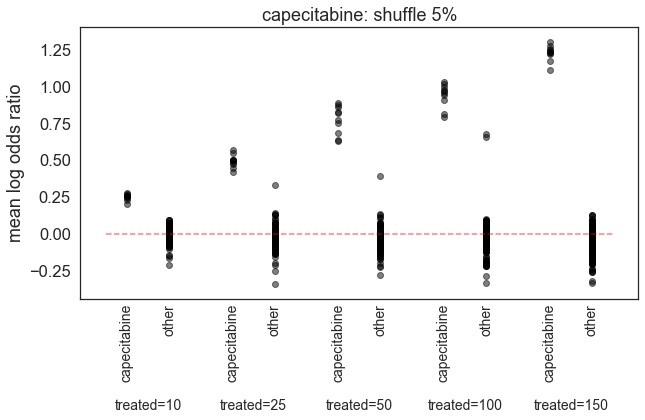

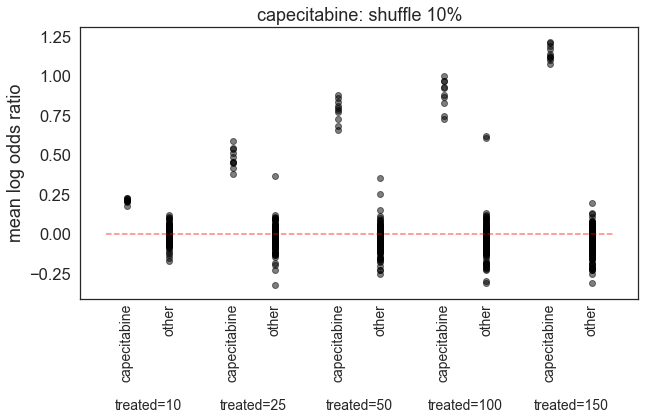

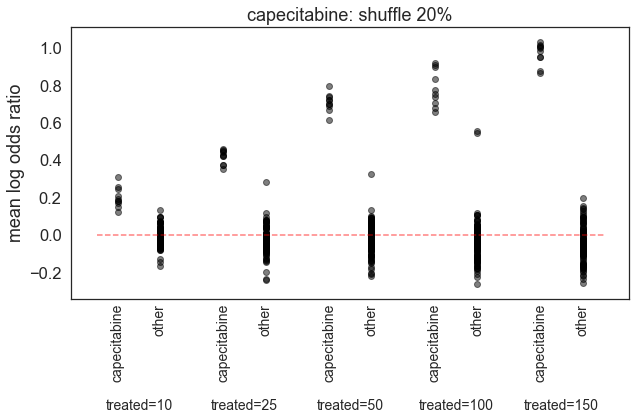

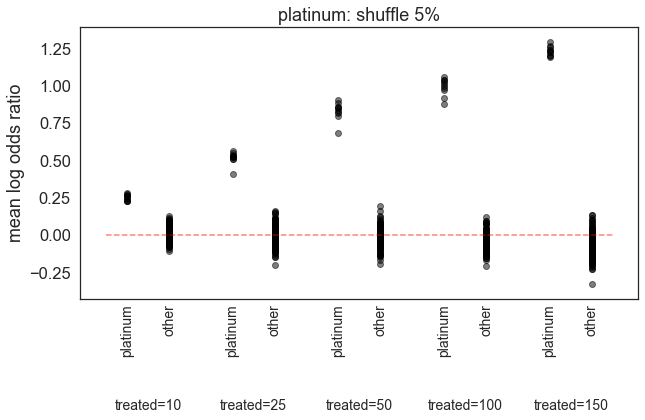

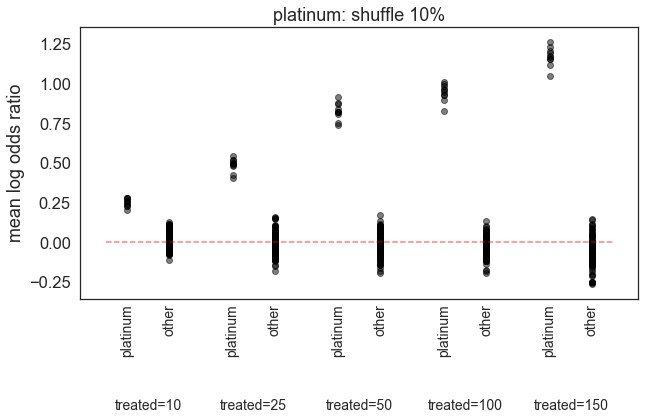

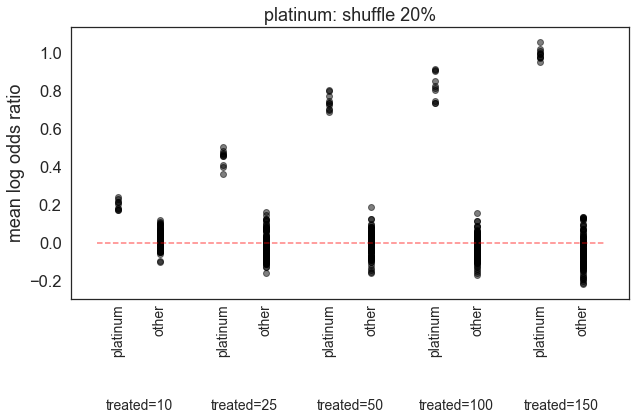

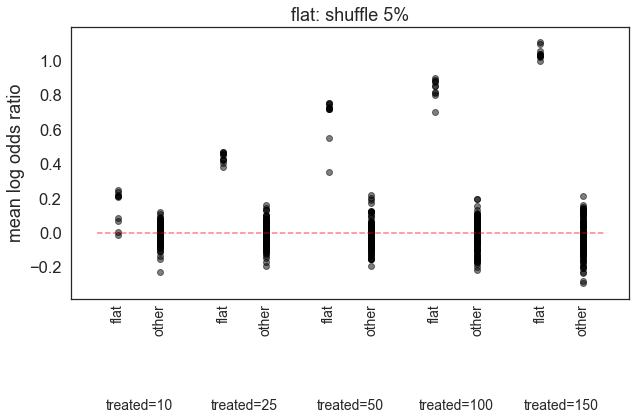

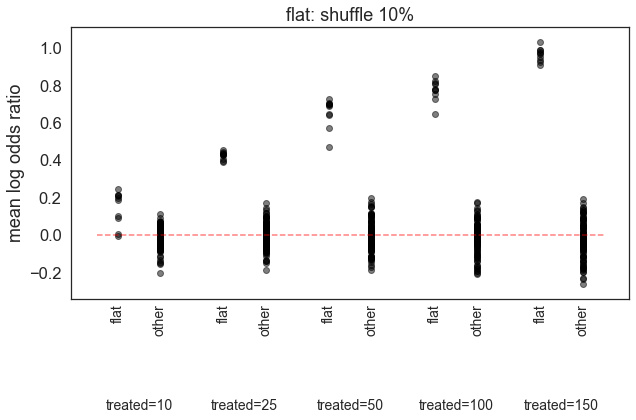

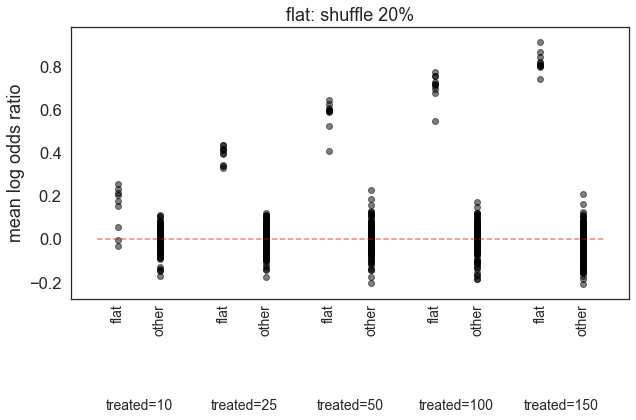

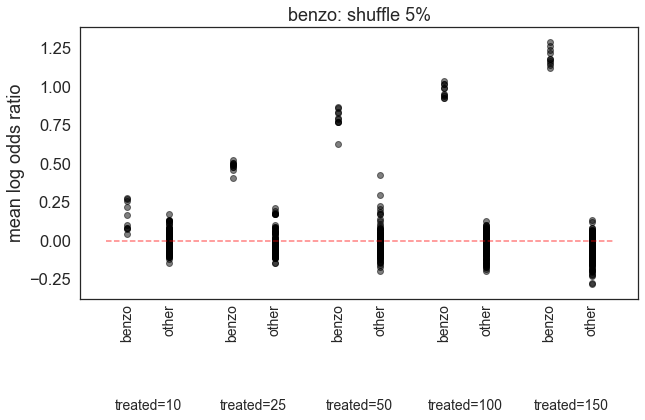

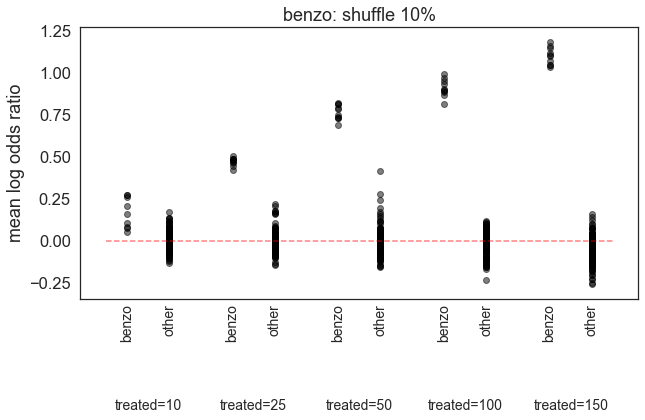

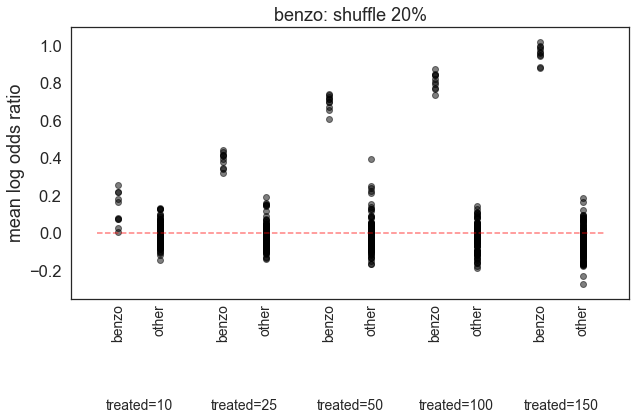

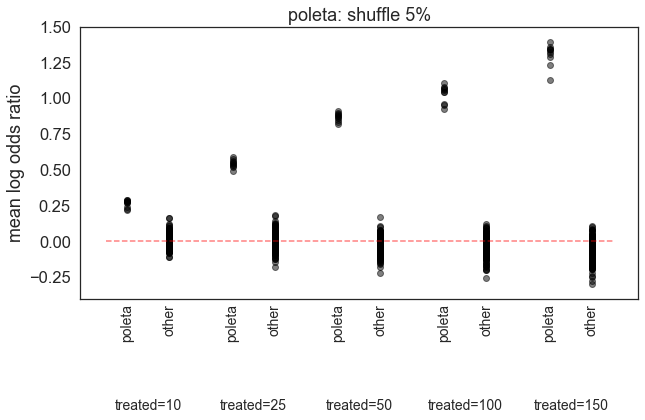

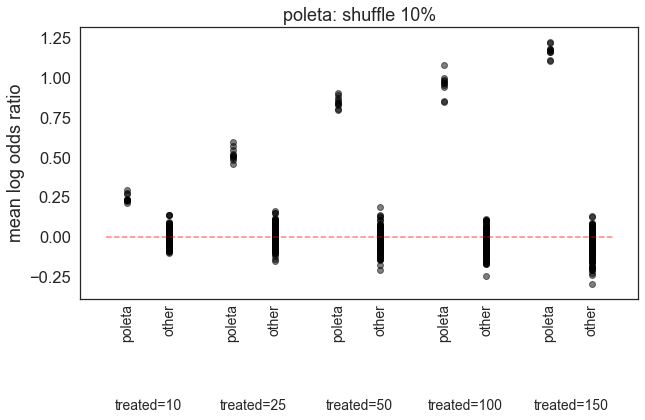

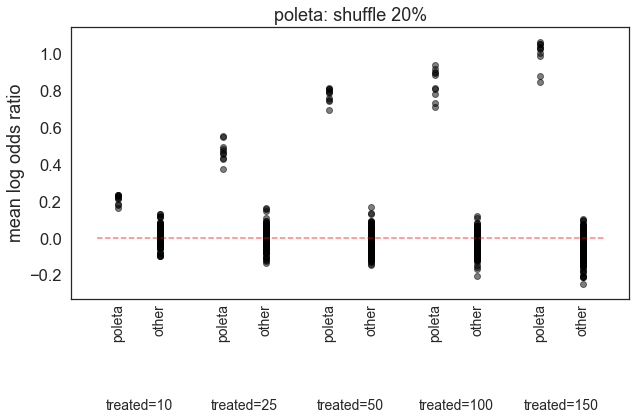

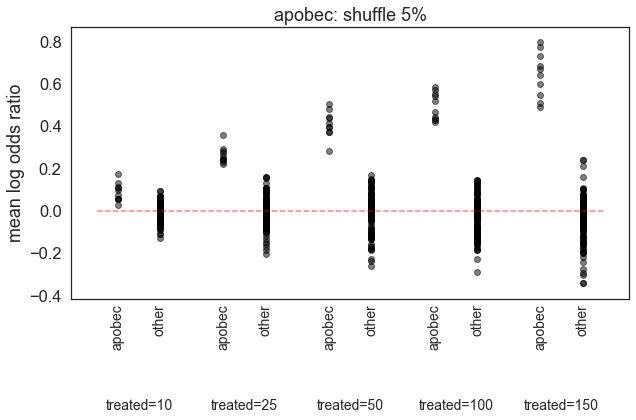

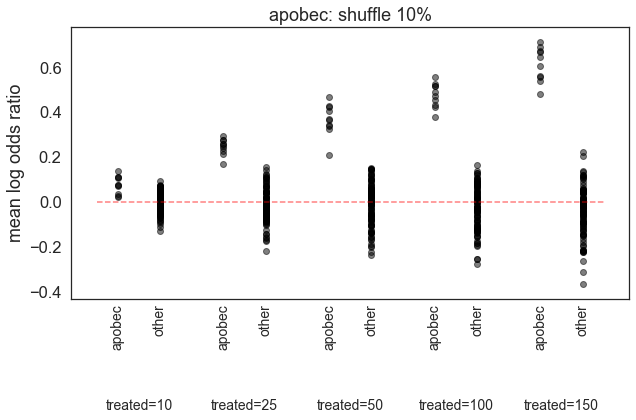

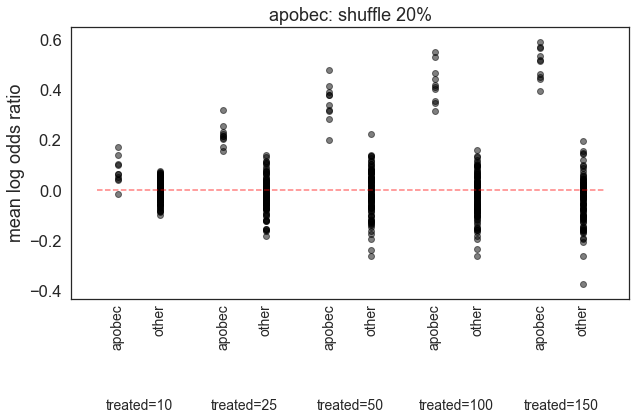

In [99]:
for etiology in synthetic.etiologies:
    for shuffle in [5, 10, 20]:
        plot_lor_mean_shuffle(etiology, shuffle=shuffle)

# ... now with fold-change

In [94]:
regression_folder = '/home/fmuinos/projects/oriol/treatment_effects/simulations/regression_results'

channel_index = synthetic.channel_index


def fold_change(etiology, n_treated, replicate, shuffle=None):

    index, cosine = signature_recovery(etiology, n_treated, replicate, plot=False)
    df = pd.read_csv(os.path.join(regression_folder, f'shuffle.{shuffle}.regression_summary.{etiology}.{n_treated}.{replicate}.tsv'), sep='\t')
    x, y = [], []
    x.append(0)
    y.append(df.loc[index, 'effect_size'])
    x += [1 for i in df.loc[:, 'signature'] if i not in [index]]
    y += list(df[~df.signature.isin([index])]['effect_size'].values)
    
    return x, y


def plot_fold_change(etiology, shuffle=None):

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.tick_params(length=0, which='major', pad=100, labelsize=14, axis='x')
    ax.tick_params(length=0, which='minor', pad=5, labelsize=14, rotation=90)

    ax.set_xticks(sum([[i - 0.2, i + 0.2] for i in range(5)], []), minor=True)
    ax.set_xticklabels([etiology, 'other'] * 5, minor=True)
    ax.set_xticks(range(5), minor=False)
    ax.set_xticklabels(list(map(lambda x: f'treated={x}', [10, 25, 50, 100, 150])))
    
    for i, n_treated in enumerate([10, 25, 50, 100, 150]):
        for replicate in range(1, 11):
            try:
                x, y = fold_change(etiology, n_treated, replicate, shuffle=shuffle)
                ax.scatter((np.array(x) - 0.5) * (0.2 / 0.5) + i, y, alpha=0.5, color='green')
            except FileNotFoundError as e:
                pass
    ax.hlines(2, -0.4, 4.4, linestyles='dashed', color='red', alpha=0.5)
    ax.set_ylabel('fold change')
    ax.set_title(f'{etiology}: shuffle {shuffle}%')
    fig.savefig(f'figures/shuffle.{shuffle}.{etiology}.fold_change_plot.svg', dpi=200, bbox_inches='tight')
    plt.show()

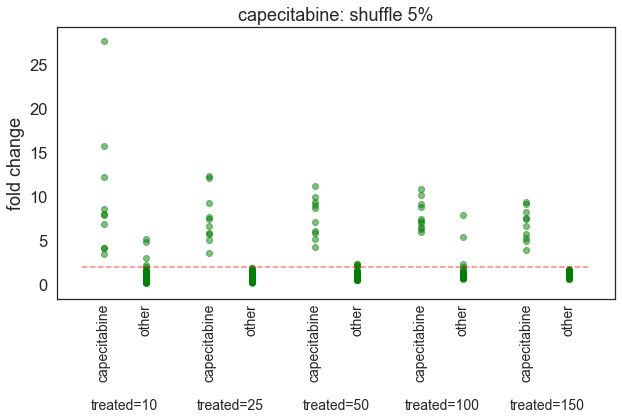

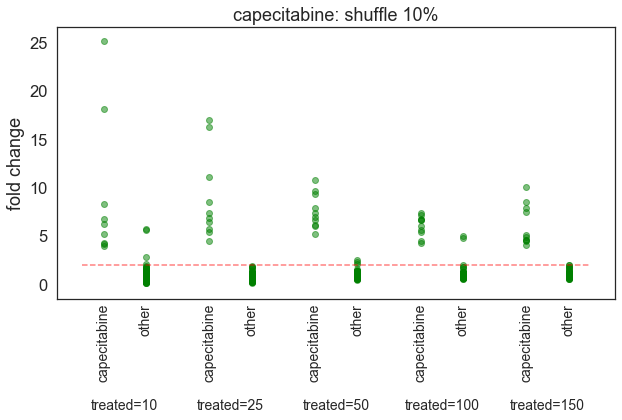

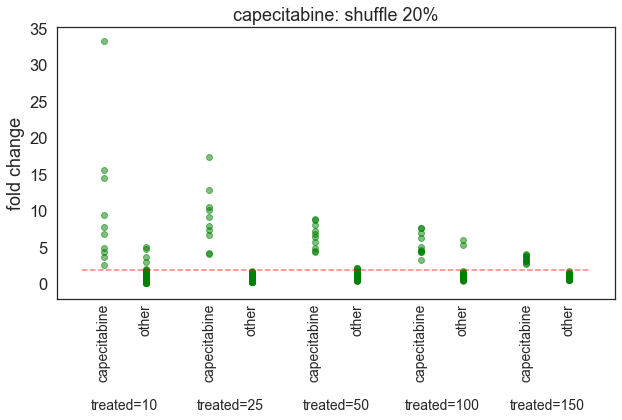

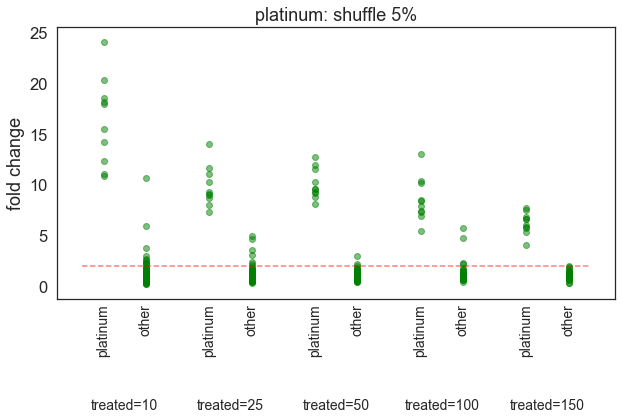

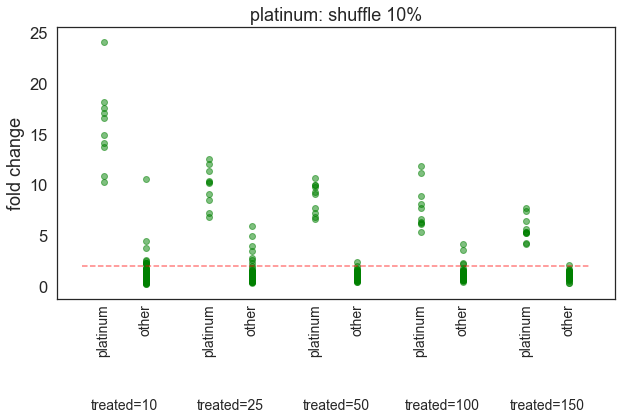

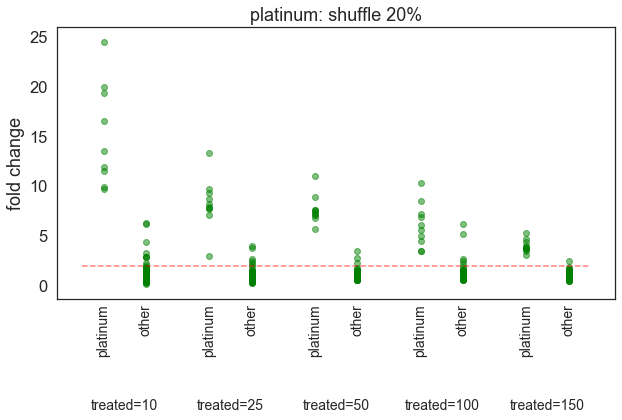

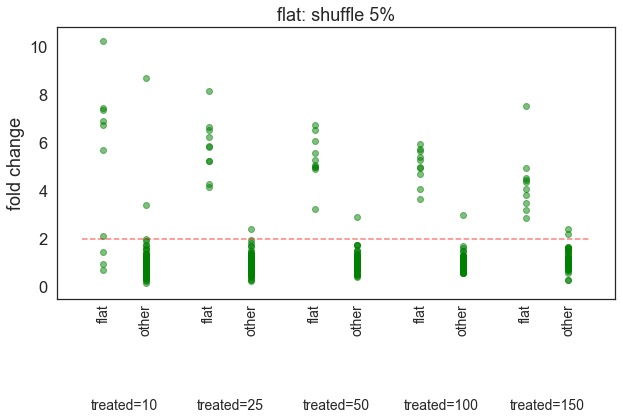

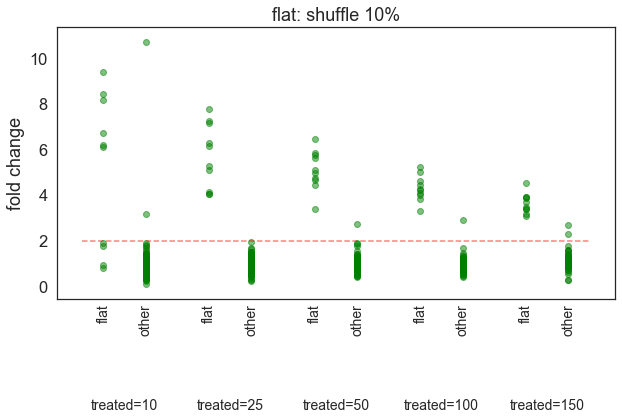

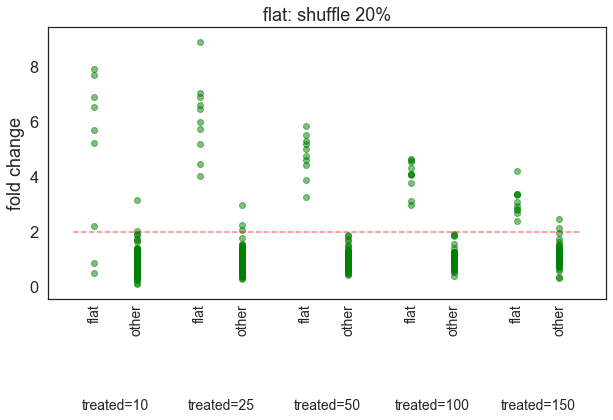

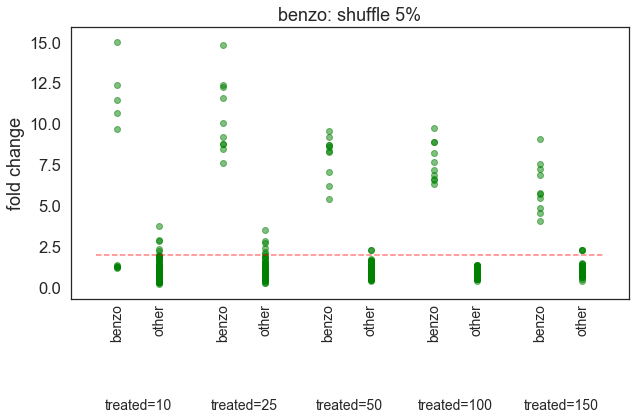

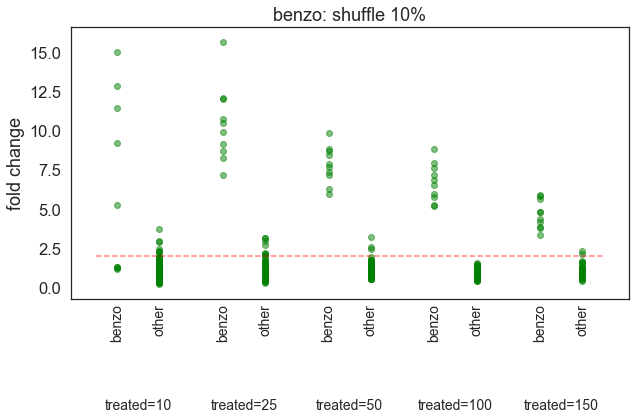

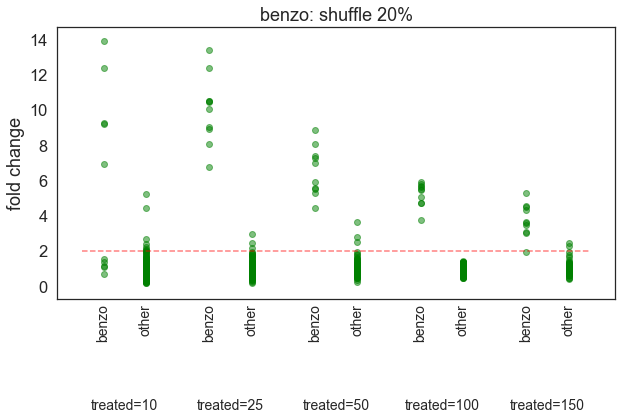

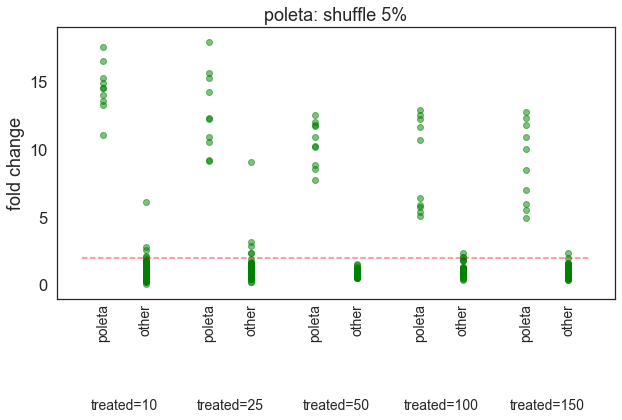

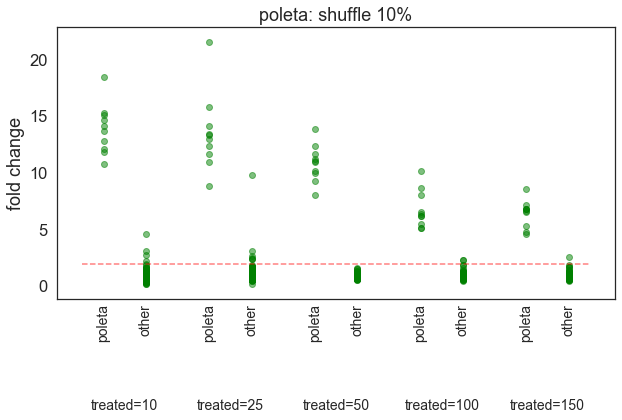

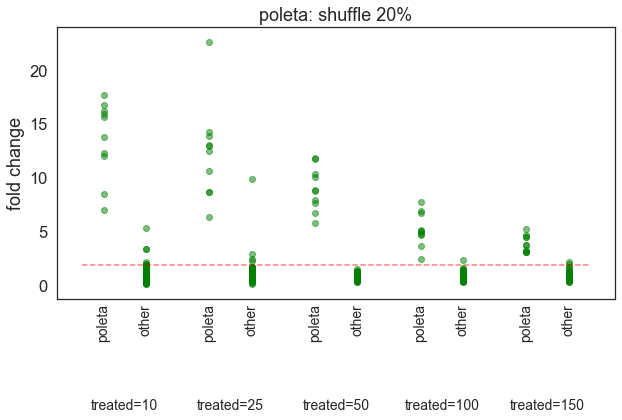

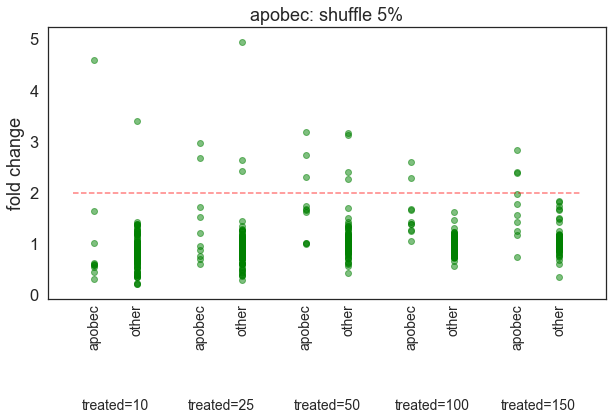

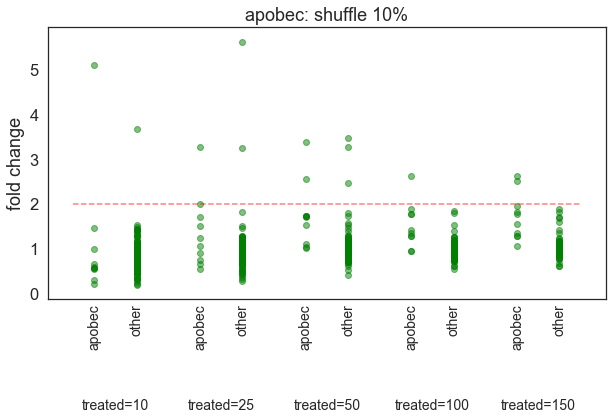

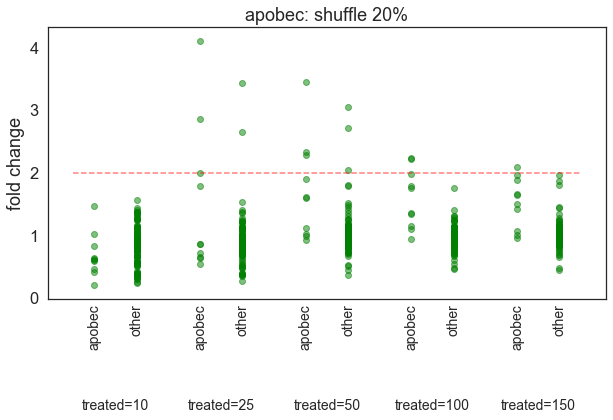

In [96]:
for etiology in synthetic.etiologies:
    for shuffle in [5, 10, 20]:
        plot_fold_change(etiology, shuffle=shuffle)

# Recovery of synthetic exposures